In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations

In [2]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [3]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [4]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [102]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/tcga_gtex_clean.h5ad')
adata = adata[adata.obs.query('X_study == "TCGA"').index]
adata.obs_names = adata.obs_names.str.strip('-01')
adata = adata[adata.obs.X_sample_type == 'Primary Tumor']

OSError: [Errno 12] Can't synchronously read data (file read failed: time = Sun Nov 24 00:57:31 2024
, filename = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/tcga_gtex_clean.h5ad', file descriptor = 56, errno = 12, error message = 'Cannot allocate memory', buf = 0x5642ff50e4be, total read size = 76771, bytes this sub-read = 76771, bytes actually read = 18446744073709551615, offset = 0)

In [ ]:
adata.obs_names_make_unique()

In [ ]:
adata.obs_names.value_counts()

In [77]:
filepath = os.path.join('/home/carora/survival/data', 'Brain.csv')
df = pd.read_csv(filepath, index_col=0)
df = df.query('x_sample_type == "Primary Tumor"')
last_col = int(np.where(df.columns == 'x_study')[0])
df = df.iloc[:, :last_col]
df = df.set_index('bcr_patient_barcode', drop=True)

In [95]:
adata[df.index]

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [84]:
adata['TCGA-HT-8'].obs

detailed_category primary_disease_or_tissue X_primary_site  \
TCGA-HT-8  Brain Lower Grade Glioma  Brain Lower Grade Glioma          Brain   
TCGA-HT-8  Brain Lower Grade Glioma  Brain Lower Grade Glioma          Brain   
TCGA-HT-8  Brain Lower Grade Glioma  Brain Lower Grade Glioma          Brain   
TCGA-HT-8  Brain Lower Grade Glioma  Brain Lower Grade Glioma          Brain   

           X_sample_type X_gender X_study  
TCGA-HT-8  Primary Tumor   Female    TCGA  
TCGA-HT-8  Primary Tumor     Male    TCGA  
TCGA-HT-8  Primary Tumor     Male    TCGA  
TCGA-HT-8  Primary Tumor     Male    TCGA

In [81]:
TCGA-61-2       4
TCGA-B0-57      4
TCGA-HT-8       4
TCGA-B0-47      3
TCGA-BP-5df

bcr_patient_uuid  \
bcr_patient_barcode                                         
TCGA-02-0047         3caf009f-d9e0-4c57-b1d9-8eb59fc833bd   
TCGA-02-0055         da5f6940-e8ee-4fd1-a8da-4cd68e02e59c   
TCGA-02-2483         a2ac9937-f351-4d78-9261-264bf6c21e0c   
TCGA-02-2485         521ea765-1bd1-423d-a75d-091243df37a9   
TCGA-06-0125         8da3103e-3e6c-4176-a583-d5fe5e60601e   
...                                                   ...   
TCGA-WY-A85A         09552B53-4393-4811-A671-A9EF6EFF4790   
TCGA-WY-A85B         CB041720-0EFA-4EB6-A9A5-B6E138BB1A99   
TCGA-WY-A85C         F62BE2B8-88C4-4A7E-8C80-8176FB5F6C56   
TCGA-WY-A85D         0D5A4C63-C3FB-4295-A433-D90CDBFC4ED6   
TCGA-WY-A85E         2272DFF7-A509-496F-B500-467C1BCE2F79   

                    form_completion_date histologic_diagnosis tumor_grade  \
bcr_patient_barcode                                                         
TCGA-02-0047                  2008-12-16                  NaN         NaN   
TCGA-02-0055                  2008-12-16                  NaN         NaN   
TCGA-02-2483                    2010-5-6                  NaN         NaN   
TCGA-02-2485                    2010-5-6                  NaN         NaN   
TCGA-06-0125                   2008-12-8                  NaN         NaN   
...                                  ...                  ...         ...   
TCGA-WY-A85A                   2014-2-27          Astrocytoma          G2   
TCGA-WY-A85B                   2014-2-20          Astrocytoma          G2   
TCGA-WY-A85C                   2014-2-26          Astrocytoma          G2   
TCGA-WY-A85D                   2014-2-26     Oligoastrocytoma          G2   
TCGA-WY-A85E                   2014-2-27     Oligoastrocytoma          G2   

                    laterality                     tumor_site  \
bcr_patient_barcode                                             
TCGA-02-0047               NaN                            NaN   
TCGA-02-0055               NaN                            NaN   
TCGA-02-2483               NaN                            NaN   
TCGA-02-2485               NaN                            NaN   
TCGA-06-0125               NaN                            NaN   
...                        ...                            ...   
TCGA-WY-A85A             Right   Supratentorial, Frontal Lobe   
TCGA-WY-A85B             Right  Supratentorial, Temporal Lobe   
TCGA-WY-A85C             Right   Supratentorial, Frontal Lobe   
TCGA-WY-A85D             Right   Supratentorial, Frontal Lobe   
TCGA-WY-A85E              Left   Supratentorial, Frontal Lobe   

                      supratentorial_localization prospective_collection  \
bcr_patient_barcode                                                        
TCGA-02-0047                                  NaN                   [NA]   
TCGA-02-0055                                  NaN                   [NA]   
TCGA-02-2483                                  NaN                   [NA]   
TCGA-02-2485                                  NaN                   [NA]   
TCGA-06-0125                                  NaN                   [NA]   
...                                           ...                    ...   
TCGA-WY-A85A         Not listed in Medical Record                     NO   
TCGA-WY-A85B         Not listed in Medical Record                     NO   
TCGA-WY-A85C         Not listed in Medical Record                     NO   
TCGA-WY-A85D         Not listed in Medical Record                     NO   
TCGA-WY-A85E                                 [NA]                     NO   

                    retrospective_collection  gender  ...  \
bcr_patient_barcode                                   ...   
TCGA-02-0047                            [NA]    MALE  ...   
TCGA-02-0055                            [NA]  FEMALE  ...   
TCGA-02-2483                            [NA]    MALE  ...   
TCGA-02-2485                            [NA]    MALE  ...   
TCGA-06-0125                            [NA]

In [80]:
df.loc['TCGA-B0-47']

KeyError: 'TCGA-B0-47'

In [55]:
adata.obs_names[adata.obs_names.isin(df.index)]

Index(['TCGA-2J-AAB4', 'TCGA-2J-AAB6', 'TCGA-2J-AAB8', 'TCGA-2J-AAB9',
       'TCGA-2J-AABA', 'TCGA-2J-AABE', 'TCGA-2J-AABF', 'TCGA-2J-AABH',
       'TCGA-2J-AABI', 'TCGA-2J-AABK',
       ...
       'TCGA-XD-AAUG', 'TCGA-XD-AAUH', 'TCGA-XD-AAUI', 'TCGA-XD-AAUL',
       'TCGA-XN-A8T3', 'TCGA-XN-A8T5', 'TCGA-YB-A89D', 'TCGA-YH-A8SY',
       'TCGA-YY-A8LH', 'TCGA-Z5-AAPL'],
      dtype='object', length=165)

In [58]:
df.shape

(178, 83)

In [ ]:
df.bcr_patient_barcode

In [90]:
adata.obs_names.value_counts()[adata.obs_names.value_counts() > 1].sum()

603

In [91]:
adata

AnnData object with n_obs × n_vars = 9181 × 19013
    obs: 'detailed_category', 'primary_disease_or_tissue', 'X_primary_site', 'X_sample_type', 'X_gender', 'X_study'
    var: 'ensembl', 'symbol', 'var_all_tissues'
    layers: 'TPM', 'log_tpm_norm', 'raw_counts'

In [43]:
adata[pd.Index(df.bcr_patient_barcode)]

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [14]:
patients = df.bcr_patient_barcode

In [17]:
df.bcr_patient_barcode

0      TCGA-2V-A95S
1      TCGA-2Y-A9GS
2      TCGA-2Y-A9GT
3      TCGA-2Y-A9GU
4      TCGA-2Y-A9GV
           ...     
416    TCGA-ZS-A9CD
417    TCGA-ZS-A9CE
418    TCGA-ZS-A9CF
419    TCGA-ZS-A9CF
420    TCGA-ZS-A9CG
Name: bcr_patient_barcode, Length: 421, dtype: object

0      TCGA-2V-A95S-01
1      TCGA-2Y-A9GS-01
2      TCGA-2Y-A9GT-01
3      TCGA-2Y-A9GU-01
4      TCGA-2Y-A9GV-01
            ...       
416    TCGA-ZS-A9CD-01
417    TCGA-ZS-A9CE-01
418    TCGA-ZS-A9CF-01
419    TCGA-ZS-A9CF-01
420    TCGA-ZS-A9CG-01
Name: bcr_patient_barcode, Length: 421, dtype: object

In [22]:
(df.bcr_patient_barcode.astype(str) + '-01').isin(adata.obs_names).sum()

421

In [18]:
adata.obs_names

Index(['GTEX-1117F-0226-SM-5GZZ7', 'GTEX-1117F-0426-SM-5EGHI',
       'GTEX-1117F-0526-SM-5EGHJ', 'GTEX-1117F-0626-SM-5N9CS',
       'GTEX-1117F-0726-SM-5GIEN', 'GTEX-1117F-1326-SM-5EGHH',
       'GTEX-1117F-2226-SM-5N9CH', 'GTEX-1117F-2426-SM-5EGGH',
       'GTEX-1117F-2826-SM-5GZXL', 'GTEX-1117F-3026-SM-5GZYU',
       ...
       'TCGA-ZP-A9D4-01', 'TCGA-ZQ-A9CR-01', 'TCGA-ZR-A9CJ-01',
       'TCGA-ZS-A9CD-01', 'TCGA-ZS-A9CE-01', 'TCGA-ZS-A9CF-01',
       'TCGA-ZS-A9CG-01', 'TCGA-ZT-A8OM-01', 'TCGA-ZU-A8S4-01',
       'TCGA-ZX-AA5X-01'],
      dtype='object', length=16589)

In [314]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pandas as pd
from sklearn.decomposition import PCA

def survival(interactions, tissue, df):
    
    genes = re.split(r'[+&_]', interactions)
    filepath = os.path.join('/home/carora/survival/data', tissue+'.csv')
    df = pd.read_csv(filepath, index_col=0, usecols=['bcr_patient_barcode', 'OS.time','vital_status'] + genes)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()

    # Perform PCA on the gene expression data
    pca = PCA(n_components=1)
    pca.fit(df[genes])
    df['eigengene'] = pca.transform(df[genes])

    # Convert OS time to years
    df['OS.time'] = df['OS.time'] / 365

    # Calculate the median expression value
    median_expression = np.median(df['eigengene'])

    # Split the data into two groups based on the median expression
    low_expression_group = df[df['eigengene'] <= median_expression]
    high_expression_group = df[df['eigengene'] > median_expression]

    # Fit the Kaplan-Meier estimator for each group
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(low_expression_group['OS.time'], event_observed=low_expression_group['vital_status'])

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(high_expression_group['OS.time'], event_observed=high_expression_group['vital_status'])

    ## Plot the Kaplan-Meier curves
    #plt.figure(figsize=(8, 8))
    #kmf_low.plot(label='Low Expression', ci_show=False, show_censors=True)
    #kmf_high.plot(label='High Expression', ci_show=False, show_censors=True)
    #plt.title(f'{tissue}: {interactions}', fontsize=24)
    #plt.xlabel('Time (Years)', fontsize=24)
    #plt.ylabel('Survival Probability', fontsize=24)
    #plt.xlim(left=0)
    #plt.ylim(bottom=0)
    #plt.xticks(fontsize=18)
    #plt.yticks(fontsize=18)
    ## Add annotations
    #plt.annotate("Low Risk", xy=(40, 0.6))
    #plt.annotate("High Risk", xy=(30, 0.8))
    #plt.grid(True, color='gray', linestyle='dashed')
    #plt.legend()

    # Perform the log-rank test
    results = logrank_test(low_expression_group['OS.time'], high_expression_group['OS.time'],
                           event_observed_A=low_expression_group['vital_status'],
                           event_observed_B=high_expression_group['vital_status'])
    
    return results.p_value, kmf_low, kmf_high

In [321]:
tissue='Liver'

motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs.csv')
motifs = motifs.query('Type == "4_clique"')

for interaction in motifs['Interaction'][::50]:
    try:
        p_value, kmf_low, kmf_high = survival(interaction, tissue, df)
        if p_value < 0.05:
            print(interaction, p_value)
    except:
        print('!')

CSF1+CSF1R&CCL3+CCR1 0.026519583554069574
!
ACKR1+CXCL11&CD8A_CD8B+LCK 0.009384996301721994
CD4+HLA-DQB1&ACKR1+CCL5 0.011785855952730118
!
!
COL10A1+ITGA11_ITGB1&TNF+TNFRSF1A 0.006279809219383446
COL10A1+ITGA2_ITGB1&PDGFC+PDGFRA 0.017344662172574552
!


In [5]:
p_value, kmf_low, kmf_high = survival('CD8A_CD8B+LCK', tissue, df)
p_value

NameError: name 'survival' is not defined

450                          CCL3+CCR1&CCL5+CCR1
500                        CD4+IL16&CD4+HLA-DRB1
550      COL1A1+ITGA11_ITGB1&COL4A2+ITGA11_ITGB1
600                    CD4+HLA-DPA1&CD4+HLA-DRB1
650                        CD8A+HLA-E&CD8A+HLA-F
700                        CD8B+HLA-E&CD8B+HLA-C
750    COL15A1+ITGA11_ITGB1&COL22A1+ITGA11_ITGB1
800          ITGA2_ITGB1+LAMB3&ITGA2_ITGB1+LAMA5
850     COL10A1+ITGA10_ITGB1&COL6A3+ITGA10_ITGB1
900                        CD8A+HLA-C&CD8A+HLA-A
Name: Interaction, dtype: object

In [286]:
filepath = os.path.join('/home/carora/survival/data', tissue+'.csv')
df = pd.read_csv(filepath, index_col=0)
df

bcr_patient_uuid bcr_patient_barcode  \
0    75119D1A-93E5-4AE7-9D60-69EE929A0772        TCGA-2J-AAB1   
1    33833131-1482-42D5-9CF5-01CADE540234        TCGA-2J-AAB4   
2    70797499-16E6-48CC-8AE4-1E692713DAD3        TCGA-2J-AAB6   
3    2E8F90F4-AED3-43B0-985C-DFDC2581F24F        TCGA-2J-AAB8   
4    A5748656-5330-417A-8938-01F69DDB3576        TCGA-2J-AAB9   
..                                    ...                 ...   
178  B84B58C7-95B8-4162-8E61-414F8FE422C6        TCGA-YB-A89D   
179  B84B58C7-95B8-4162-8E61-414F8FE422C6        TCGA-YB-A89D   
180  503D7E36-DF78-428D-9971-09FF707645C2        TCGA-YH-A8SY   
181  EDE2E8A7-465E-4725-880D-519899ABA0C0        TCGA-YY-A8LH   
182  6A4E10B6-E6C4-4210-AE4D-0D8E8D0CB3EC        TCGA-Z5-AAPL   

    form_completion_date invasive_adenocarcinoma_indicator  \
0              2014-7-16                               YES   
1              2014-7-16                               YES   
2              2014-7-16                               YES   
3              2014-7-16                               YES   
4              2014-7-16                               YES   
..                   ...                               ...   
178            2014-2-28                               YES   
179            2014-2-28                               YES   
180            2014-5-13                               YES   
181             2014-4-3                               YES   
182           2014-11-13                               YES   

                      histologic_diagnosis     histologic_diagnosis_other  \
0    Pancreas-Adenocarcinoma-Other Subtype        invasive adenocarcinoma   
1    Pancreas-Adenocarcinoma-Other Subtype  invasive, well-differentiated   
2      Pancreas-Adenocarcinoma Ductal Type                           [NA]   
3      Pancreas-Adenocarcinoma Ductal Type                           [NA]   
4      Pancreas-Adenocarcinoma Ductal Type                           [NA]   
..                                     ...                            ...   
178    Pancreas-Adenocarcinoma Ductal Type                           [NA]   
179    Pancreas-Adenocarcinoma Ductal Type                           [NA]   
180                                   [NA]                           [NA]   
181    Pancreas-Adenocarcinoma Ductal Type                           [NA]   
182    Pancreas-Adenocarcinoma Ductal Type                           [NA]   

    tumor_sample_type prospective_collection retrospective_collection  gender  \
0             Primary                     NO                      YES    MALE   
1             Primary                     NO                      YES    MALE   
2             Primary                     NO                      YES    MALE   
3             Primary                     NO                      YES    MALE   
4             Primary                     NO                      YES  FEMALE   
..                ...                    ...                      ...     ...   
178           Primary                    YES                       NO    MALE   
179           Primary                    YES                       NO    MALE   
180           Primary                     NO                      YES  FEMALE   
181           Primary                     NO                      YES  FEMALE   
182           Primary                    YES                       NO  FEMALE   

     ...   TENM1 GABARAPL3.1 RP11-486E2.1   BATF3 AC010525.4 RP11-713D19.1  \
0    ... -3.1714     -9.9658      -9.9658  1.9188    -1.3921       -3.3076   
1    ... -4.0350     -9.9658      -9.9658  2.3536    -2.5479       -1.8836   
2    ... -5.5735     -9.9658      -9.9658  2.1147    -1.6394       -2.1140   
3    ... -6.5064     -9.9658      -9.9658  2.0844    -1.3183       -9.9658   
4    ... -5.5735     -9.9658      -9.9658  2.6302    -9.9658       -9.9658   
..   ...     ...         ...          ...     ...        ...           ...   
178  ... -3.3076     -9.9658      -9.9658  2.5683    -3

In [265]:
df

vital_status  OS.time   CSF1R    CSF1
bcr_patient_barcode                                       
TCGA-2J-AAB1                    1       66  4.1531  4.1612
TCGA-2J-AAB4                    0      729  4.4745  5.6065
TCGA-2J-AAB6                    1      293  3.9393  4.4061
TCGA-2J-AAB8                    0       80  3.3952  3.7302
TCGA-2J-AAB9                    1      627  4.5236  4.9773
...                           ...      ...     ...     ...
TCGA-YB-A89D                    0      160  5.1780  4.9658
TCGA-YB-A89D                    0      160  5.3335  4.8763
TCGA-YH-A8SY                    0      388  3.6961  4.0935
TCGA-YY-A8LH                    0     1834  1.7316  2.6090
TCGA-Z5-AAPL                    0       21  3.8915  4.6537

[183 rows x 4 columns]

In [245]:
df

vital_status  OS.time   ITGB1    CCL3    CCR5   COL1A1  \
bcr_patient_barcode                                                           
TCGA-2J-AAB1                    1       66  8.1081  1.6695  0.5069   9.6254   
TCGA-2J-AAB4                    0      729  8.7004  2.4332  1.5064   9.5304   
TCGA-2J-AAB6                    1      293  8.7444  3.2707 -0.0574  11.0588   
TCGA-2J-AAB8                    0       80  8.9643  4.0670  0.6969  11.7218   
TCGA-2J-AAB9                    1      627  8.8979  2.0569  1.6281  10.3201   
...                           ...      ...     ...     ...     ...      ...   
TCGA-YB-A89D                    0      160  8.9877  4.4777  1.4388  11.7914   
TCGA-YB-A89D                    0      160  8.8559  5.7233  2.3536  11.7163   
TCGA-YH-A8SY                    0      388  8.6960  3.3869  0.0014  13.1107   
TCGA-YY-A8LH                    0     1834  7.6470  0.4865 -0.5973   7.4957   
TCGA-Z5-AAPL                    0       21  7.1366  4.1852  3.1604   8.3835   

                     ITGA11  eigengene  
bcr_patient_barcode                     
TCGA-2J-AAB1         2.6161   0.974785  
TCGA-2J-AAB4         2.7227   0.241905  
TCGA-2J-AAB6         3.8729  -1.021141  
TCGA-2J-AAB8         5.4296  -2.913949  
TCGA-2J-AAB9         3.0002  -0.393332  
...                     ...        ...  
TCGA-YB-A89D         5.0981  -3.141287  
TCGA-YB-A89D         4.5705  -3.406570  
TCGA-YH-A8SY         5.2013  -3.091870  
TCGA-YY-A8LH         0.5470   4.344892  
TCGA-Z5-AAPL         1.9377   0.730880  

[183 rows x 8 columns]

In [200]:
u, d, v = np.linalg.svd(df[genes])

In [233]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Fit PCA on unscaled data
pca = PCA(n_components=1)
pca.fit(df[genes])
df['eigengene'] = pca.transform(df[genes])

# Explained variance on unscaled data
explained_variance_unscaled = pca.explained_variance_ratio_[0]
print(f"Explained Variance (Unscaled Data): {explained_variance_unscaled}")

# Step 2: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[genes])

# Step 3: Fit PCA on scaled data
pca_scaled = PCA(n_components=1)
pca_scaled.fit(scaled_data)
df['eigengene_scaled'] = pca_scaled.transform(scaled_data)

# Explained variance on scaled data
explained_variance_scaled = pca_scaled.explained_variance_ratio_[0]
print(f"Explained Variance (Scaled Data): {explained_variance_scaled}")


Explained Variance (Unscaled Data): 0.65926139106483
Explained Variance (Scaled Data): 0.6163877344932309


In [5]:
from itertools import combinations

In [10]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index_col=0)
genes = set(lr['ligand']).union(lr['receptor'])
pairs = list(combinations(genes, 2))
pairs = [tuple(sorted(x)) for x in pairs]

In [11]:
df = pd.DataFrame(list(combinations(genes, 2)), columns=['gene1', 'gene2'])
df['all_genes'] = pd.Series(pairs).apply(lambda x: list(x))
df['interaction'] = df.gene1.astype(str) + '_' + df.gene2.astype(str)
df = df.set_index('interaction')
df.head()

gene1     gene2           all_genes
interaction                                          
LRRC4B_CALCA     LRRC4B     CALCA     [CALCA, LRRC4B]
LRRC4B_CCL22     LRRC4B     CCL22     [CCL22, LRRC4B]
LRRC4B_PAFAH1B2  LRRC4B  PAFAH1B2  [LRRC4B, PAFAH1B2]
LRRC4B_COL1A2    LRRC4B    COL1A2    [COL1A2, LRRC4B]
LRRC4B_NPS       LRRC4B       NPS       [LRRC4B, NPS]

In [20]:
#df.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/all_ccc_gene_pairs.csv')

In [228]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv')
#lr = lr[~(lr['ligand'] == lr['receptor'])]
#lr.to_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index=False)

In [229]:
lr

ligand receptor
0      CDH1    ITGB1
1      CDH1    ITGA2
2      CDH1    ITGAE
3      CDH1    ITGB7
4      CDH1    KLRG1
...     ...      ...
3743  LAMB2    ITGA1
3744  LAMB3    ITGA1
3745  LAMC1    ITGA1
3746  LAMC2    ITGA1
3747  LAMC3    ITGA1

[3748 rows x 2 columns]

In [230]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv')
lr['interaction'] = lr.ligand + '_' + lr.receptor
lr['all_genes'] = lr.apply(lambda x: [x['ligand'], x['receptor']], axis=1)
#lr.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv', index=False)

In [219]:
sum(lr['ligand'] == lr['receptor'])

18

In [7]:
from itertools import combinations

In [14]:
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')

In [15]:
all_pairs = {f"{pair[0]}&{pair[1]}": [pair[0], pair[1]] for pair in combinations(lr['interaction'], 2) if pair[0] != pair[1]}

In [32]:
df = pd.DataFrame(all_pairs.keys(), columns=['interaction'])

In [33]:
df['interaction1'] = df.interaction.str.split('&', expand=True)[0]
df['interaction2'] = df.interaction.str.split('&', expand=True)[1]

In [35]:
df['all_genes'] = df.interaction.str.split(r'[_+&]').apply(lambda x: list(set(x)))

In [37]:
#df.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/pairs_of_interactions.csv', index=False)

In [14]:
from itertools import combinations
import pandas as pd

# Load data
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')

# Extract genes for complex A and B
complex_a_genes = lr.apply(lambda row: [row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])], axis=1)
complex_b_genes = lr.apply(lambda row: [row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])], axis=1)

# Remove interactions that are contained by other interactions
interactions_genes = (complex_a_genes + complex_b_genes).apply(set)
duplicates = interactions_genes.apply(lambda x: any(x < other for other in interactions_genes.values))
complex_a_genes = complex_a_genes[~duplicates]
complex_b_genes = complex_b_genes[~duplicates]

# Combine unique complex genes and index by sorted gene list for lookup
all_complexes = pd.concat([complex_a_genes, complex_b_genes]).reset_index(drop=True)
all_complexes = all_complexes.apply(lambda x: frozenset(x)).drop_duplicates().reset_index(drop=True)
all_complexes.index = all_complexes.apply(lambda x: '_'.join(sorted(x)))

In [34]:
from itertools import combinations

# Generate all unique pairs of complexes
complex_pairs = list(combinations(all_complexes.index, 2))

# Get the list of genes for each pair of complexes
complex_gene_combinations = {}
for complex1, complex2 in complex_pairs:
    # Get the genes for each complex from the `all_complexes` DataFrame
    genes1 = all_complexes.loc[complex1]
    genes2 = all_complexes.loc[complex2]
    
    # Combine genes from both complexes into a sorted list and remove duplicates
    combined_genes = sorted(set(genes1).union(genes2))
    
    # Store the pair and its combined genes in a dictionary
    complex_gene_combinations[f"{complex1}+{complex2}"] = combined_genes

df = pd.Series(complex_gene_combinations).to_frame(name='all_genes')

del complex_gene_combinations

In [43]:
df['complex1'] = pd.Series(df.index.str.split('+'), index=df.index).apply(lambda x: sorted(x)[0])
df['complex2'] = pd.Series(df.index.str.split('+'), index=df.index).apply(lambda x: sorted(x)[1])

In [55]:
df.index = df['complex1'].astype(str) + '+' + df['complex2'].astype(str)
df.index.name = 'interaction'
df = df[['complex1', 'complex2', 'all_genes']]

In [57]:
#df.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/all_ccc_complex_pairs.csv')

# CCC Crosstalk Network

In [18]:
# USE THIS IF YOU WANT TO MOVE TO WILCOXON SIGNED-RANK

# Set tissues that don't have both conditions to other tissues and group them together
#common_tissues = nmean.columns.intersection(tmean.columns)
#nmean.columns = np.where(nmean.columns.isin(common_tissues), nmean.columns, 'other_tissues')
#tmean.columns = np.where(tmean.columns.isin(common_tissues), tmean.columns, 'other_tissues')
#
#nmean = ndf.T.groupby(lambda x: sub2tissue[x]).mean().T # group normal subtissues by major tissue
#tmean = tdf.T.groupby(lambda x: sub2tissue[x]).mean().T # group tumor subtissues by major tissue
#common_tissues = nmean.columns.intersection(tmean.columns)
#
#nmean = nmean.loc[:, common_tissues]
#tmean = tmean.loc[:, common_tissues]


# Get differences and subset to only those with enough variance
#diff = tdf - ndf

#min_std = 1e-4
#diff = diff[diff.std(axis=1) > min_std]

In [20]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_unfiltered.csv.gz')

In [23]:
(network['pval_adj'] < 0.05).value_counts()

pval_adj
False    1236311
True      101119
Name: count, dtype: int64

In [55]:
from igraph import Graph

# Extract edges (node pairs) and weights
edges = list(zip(network['complex1'], network['complex2']))
weights = (2*network['auroc'] - 1).tolist()

# Create the undirected graph
G = Graph.TupleList(edges, directed=False, edge_attrs=['weight'])
G.es['weight'] = weights  # Set the 'auroc' values as edge weights

In [56]:
matrix = pd.DataFrame(G.get_adjacency(attribute='weight'), index=G.vs['name'], columns=G.vs['name'])

In [57]:
import leidenalg as la
import igraph as ig

#G = ig.Graph.Weighted_Adjacency(matrix, mode=ig.ADJ_UNDIRECTED)

G_pos = G.subgraph_edges(G.es.select(weight_gt = 0), delete_vertices=False);
G_neg = G.subgraph_edges(G.es.select(weight_lt = 0), delete_vertices=False);
G_neg.es['weight'] = [-w for w in G_neg.es['weight']];

partition = la.find_partition_multiplex(
    graphs = [G_pos, G_neg],
    partition_type = la.ModularityVertexPartition,
    layer_weights = [1, -1],
    #max_comm_size = 500,
    n_iterations=-1,
    weights='weight',
    seed=42,
)

clusters = pd.Series(partition[0], index=G.vs['name'])
clusters.value_counts()

0     436
1     396
2     351
3     333
78      1
     ... 
36      1
35      1
34      1
33      1
48      1
Length: 124, dtype: int64

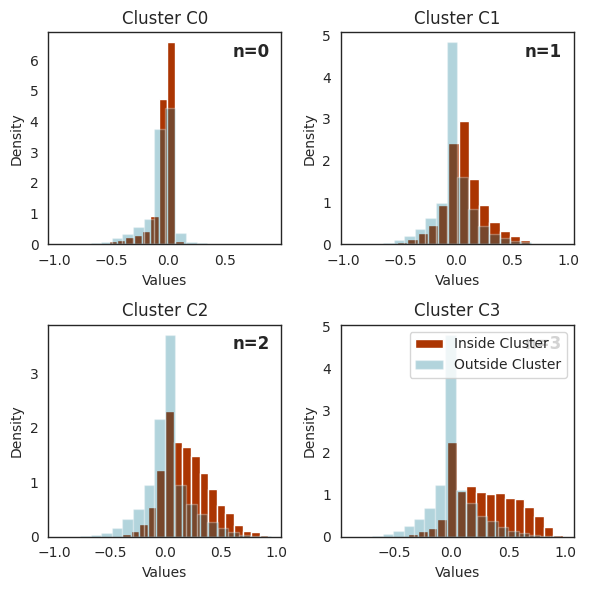

In [58]:
# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()  # Flatten for easier indexing

for n in range(4):
    ax = axes[n]  # Select the subplot in the grid for the current 'n'
    clust = clusters[clusters == n].index
    others = matrix.columns[~matrix.columns.isin(clust)]
    
    # Plot histogram of values within 'clust'
    ax.hist(matrix.loc[clust, clust].values.flatten(), density=True, alpha=1, bins=20, color=tcolor, label='Inside Cluster')
    # Plot histogram of values between 'clust' and 'others'
    ax.hist(matrix.loc[clust, others].values.flatten(), density=True, alpha=0.3, bins=20, color=ncolor, label='Outside Cluster')
    
    # Add text displaying the value of 'n'
    ax.text(0.95, 0.95, f'n={n}', ha='right', va='top', transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    # Optional: add labels or legends
    ax.set_title(f'Cluster C{n}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

0.47410445833216425

In [92]:
for n in range(4):
    clust = clusters[clusters == n].index
    print(np.median(((1 + matrix.loc[clust, clust].values) / 2).flatten()))

0.4821428571428571
0.5231481481481481
0.5806878306878307
0.6283068783068783


In [74]:
set(pd.Series(clusters[clusters == 1].index.str.split('_')).sum()).intersection(pd.Series(clusters[clusters == 2].index.str.split('_')).sum())

{'ACVR1',
 'ACVR2A',
 'BMPR2',
 'CNTN1',
 'CXCR2',
 'DDC',
 'EGFR',
 'FGFR1',
 'FPR2',
 'GPER1',
 'IGF1R',
 'IL1RAP',
 'IL2RB',
 'IL2RG',
 'INHBB',
 'ITGB1',
 'ITGB3',
 'LRP5',
 'LRP6',
 'PLXNA3',
 'PTCH1',
 'PTCH2',
 'TGFBR1',
 'TGFBR2'}

In [94]:
import ast
ccc = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')

# convert: string -> list -> set
ccc['all_genes'] = ccc['all_genes'].apply(lambda x: ast.literal_eval(x)).apply(set)
ccc_gene_sets = set(tuple(sorted(gene_set)) for gene_set in ccc['all_genes'])

In [39]:
from igraph import Graph
import igraph as ig 

network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/network_filtered.csv')

# Extract edges (node pairs) and weights
edges = list(zip(network.query('pval_adj < 0.05')['complex1'], network.query('pval_adj < 0.05')['complex2']))

# Create the undirected graph
G = Graph.TupleList(edges, directed=False)

In [98]:
network

complex1 complex2     auroc          pval       std      n_median  \
0        ANGPTL1    GPR17  0.018519  3.492804e-11  0.000034  1.818131e-07   
1          GPR17    MERTK  0.018519  3.492804e-11  0.000008  1.217874e-10   
2          GPR17      VWF  0.023148  7.780518e-11  0.000047  2.391124e-08   
3            GHR    GPR17  0.024471  8.772806e-11  0.000007  3.334726e-09   
4          GPR17   SEMA3G  0.026455  1.460248e-10  0.000057  1.102156e-09   
...          ...      ...       ...           ...       ...           ...   
1337425  GLYCAM1    MPZL1  0.500000           NaN  0.000000  0.000000e+00   
1337426  GLYCAM1   PLXNA1  0.500000           NaN  0.000000  0.000000e+00   
1337427  GLYCAM1   PLXNA3  0.500000           NaN  0.000000  0.000000e+00   
1337428  GLYCAM1   PLXNA2  0.500000           NaN  0.000000  0.000000e+00   
1337429  GLYCAM1   IGSF11  0.500000           NaN  0.000000  0.000000e+00   

         t_median  pval_adj              all_genes    ccc  
0             0.0  0.000017   ('ANGPTL1', 'GPR17')  False  
1             0.0  0.000017     ('GPR17', 'MERTK')  False  
2             0.0  0.000017       ('GPR17', 'VWF')  False  
3             0.0  0.000017       ('GHR', 'GPR17')  False  
4             0.0  0.000017    ('GPR17', 'SEMA3G')  False  
...           ...       ...                    ...    ...  
1337425       0.0       NaN   ('GLYCAM1', 'MPZL1')  False  
1337426       0.0       NaN  ('GLYCAM1', 'PLXNA1')  False  
1337427       0.0       NaN  ('GLYCAM1', 'PLXNA3')  False  
1337428       0.0       NaN  ('GLYCAM1', 'PLXNA2')  False  
1337429       0.0       NaN  ('GLYCAM1', 'IGSF11')  False  

[1337430 rows x 10 columns]

# Motifs

In [30]:
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

def read_and_plot_motifs(folder):
    df          = pd.read_csv(os.path.join(folder, 'motifs_permutations.csv'))
    real_counts = pd.read_csv(os.path.join(folder, 'counts.csv'), index_col='motif')
    
    perm_triplets = df[['3_path', '3_clique']].sum(1)
    real_triplets = real_counts.T[['3_path', '3_clique']].loc['number'].sum()

    perm_quadruplets = df.sum(1) - perm_triplets
    real_quadruplets = real_counts.values.sum() - real_triplets
    
    # TRIPLETS AND QUADRUPLETS COUNTS

    data = pd.DataFrame({
        'Triplets': perm_triplets,
        'Quadruplets': perm_quadruplets
    })
    df_long = data.melt(var_name="Feature", value_name="Value")

    real_values = [real_triplets, real_quadruplets]

    # TRIPLETS FRACTIONS

    real_3_fracs = real_counts.loc[['3_path', '3_clique']] / real_triplets
    perm_3_fracs = (df[['3_path', '3_clique']].T / perm_triplets).T

    perm_3_fracs_long = perm_3_fracs.melt(var_name="Feature", value_name="Value")
    real_3_values = real_3_fracs.values.flatten()  # Flatten to align with feature order

    # QUADRUPLETS FRACTIONS

    cols = [col for col in df.columns if col not in ['3_path', '3_clique']]

    real_4_fracs = real_counts.loc[cols] / real_quadruplets
    perm_4_fracs = (df[cols].T / perm_quadruplets).T

    perm_4_fracs_long = perm_4_fracs.melt(var_name="Feature", value_name="Value")
    real_4_values = real_4_fracs.values.flatten()  # Flatten to align with feature order
    

    # ----- PLOT ------
    
    fig, axs = plt.subplot_mosaic(
        '''
        ABCCC
        ''',
        figsize=(18, 6)
    )

    style = dict(marker='s', linestyle=' ', markersize=10,
                 markerfacecolor=tcolor, markeredgecolor='k')

    # Plot 1: Permuted and Real Counts (sorted by median, descending)
    sorted_features_1 = df_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    df_long_sorted = df_long[df_long["Feature"].isin(sorted_features_1)]
    df_long_sorted['Value'] = np.log10(df_long_sorted['Value'])

    real_values_series_1 = np.log10(pd.Series(real_values, index=df_long["Feature"].unique()))
    real_values_sorted_1 = real_values_series_1.loc[sorted_features_1]

    # Plot log10 counts on a linear scale
    #real_values_sorted_1 = np.log10(real_values_sorted_1)
    #log_values_sorted_1 = np.log10(df_long_sorted.groupby("Feature")["Value"].median().loc[sorted_features_1])

    sns.boxplot(x="Feature", y="Value", data=df_long_sorted, color=ncolor, order=sorted_features_1, ax=axs['A'])
    #axs['A'].plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style)
    axs['A'].plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style, label='log10 Counts')
    axs['A'].set_title("Total Occurrences")
    axs['A'].set_ylabel("Counts (log10)")
    axs['A'].set_xlabel("Feature")

    # Plot 2: Fractions of Triplets (sorted by median, descending)
    sorted_features_2 = perm_3_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    perm_3_fracs_sorted = perm_3_fracs_long[perm_3_fracs_long["Feature"].isin(sorted_features_2)]

    real_3_values_series = pd.Series(real_3_values, index=perm_3_fracs_long["Feature"].unique())
    real_3_values_sorted = real_3_values_series.loc[sorted_features_2]

    sns.boxplot(x="Feature", y="Value", data=perm_3_fracs_sorted, color=ncolor, order=sorted_features_2, ax=axs['B'])
    axs['B'].plot(range(len(real_3_values_sorted)), real_3_values_sorted, **style)
    axs['B'].set_title("Distribution of Triplets")
    axs['B'].set_ylabel("Proportion")
    axs['B'].set_xlabel("Feature")
    axs['B'].set_xticks(range(len(real_3_values_sorted)))

    # Plot 3: Fractions of Quadruplets (sorted by median, descending)
    sorted_features_3 = perm_4_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
    perm_4_fracs_sorted = perm_4_fracs_long[perm_4_fracs_long["Feature"].isin(sorted_features_3)]

    real_4_values_series = pd.Series(real_4_values, index=perm_4_fracs_long["Feature"].unique())
    real_4_values_sorted = real_4_values_series.loc[sorted_features_3]

    sns.boxplot(x="Feature", y="Value", data=perm_4_fracs_sorted, color=ncolor, order=sorted_features_3, ax=axs['C'])
    axs['C'].plot(range(len(real_4_values_sorted)), real_4_values_sorted, **style)
    axs['C'].set_title("Distribution of Quadruplets")
    axs['C'].set_ylabel("Proportion")
    axs['C'].set_xlabel("Feature")
    axs['C'].set_xticks(range(len(real_4_values_sorted)))

    # Adjust the label padding dynamically based on the image height
    img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
    img_width = 0.15  # Increased image width for larger icons
    img_height = img_width  # Keep aspect ratio the same

    # Get the position of the main axes for all subplots
    for ax_name in ['A', 'B', 'C']:
        ax = axs[ax_name]
        xl, yl, xh, yh = np.array(ax.get_position()).ravel()
        w = xh - xl
        h = yh - yl

        # Calculate dynamic labelpad based on image height
        figure_height_in_inches = fig.get_size_inches()[1]
        figure_to_axes_ratio = h / figure_height_in_inches
        dynamic_labelpad = img_height / figure_to_axes_ratio * 72  # Convert to points (1 inch = 72 points)
        #ax.set_xlabel("Feature", labelpad=dynamic_labelpad)

        # Loop through x-axis labels and place an image for each feature
        for i, label in enumerate(sorted_features_1 if ax_name == 'A' else (sorted_features_2 if ax_name == 'B' else sorted_features_3)):
            img_path = os.path.join(img_dir, f"{label}.png")

            if os.path.exists(img_path):
                img = mpimg.imread(img_path)

                # Get the x-coordinate of the current feature label (in data coordinates)
                label_display_coords = ax.get_xticklabels()[i].get_position()  # Get the label position directly
                label_x = label_display_coords[0]  # Extract the x-coordinate of the label

                # Transform the label's x-coordinate from data coordinates to figure coordinates
                label_display_coords = ax.transData.transform((label_x, 0))  # Data to figure
                fig_coords = fig.transFigure.inverted().transform(label_display_coords)  # Figure coordinates

                # Center the image over the x-axis label
                xpos = fig_coords[0] - img_width / 2  # Adjust x position to center image
                ypos = yl - img_height - 0.03  # Adjust y position below the x-axis labels

                # Add new axes for the image
                ax_img = fig.add_axes([xpos, ypos, img_width, img_height])
                ax_img.axison = False
                ax_img.imshow(img)

    # Remove grid from all subplots
    for ax_name in ['A', 'B', 'C']:
        axs[ax_name].grid(False)

    # Make axes black
    for ax_name in ['A', 'B', 'C']:
        ax = axs[ax_name]
        ax.spines[['bottom', 'left']].set_color('black')
        ax.spines[['right', 'top']].set_visible(False)

    # Manually adjust subplot spacing (remove tight_layout)
    #plt.subplots_adjust(left=0.07, right=0.93, top=0.93, bottom=0.15)
    lp = 85

    axs['A'].set_xlabel("Group", labelpad=lp)
    axs['A'].set_xticks([])
    axs['B'].set_xlabel("Motif", labelpad=lp)
    axs['B'].set_xticks([])
    axs['C'].set_xlabel("Motif", labelpad=lp)
    axs['C'].set_xticks([])

    handles = [
        Line2D(
            [0], [0], marker='s', color='w', markerfacecolor=tcolor, 
            markeredgecolor='k', markersize=7, label='Actual Value'
        ),
        Line2D(
            [0], [0], marker='s', color='w', markerfacecolor=ncolor, 
            markeredgecolor='k', markersize=7, label='Ensemble (Permutations)'
        ),
    ]


    axs['A'].set_ylim(bottom=0)
    axs['B'].set_ylim(bottom=0)
    axs['C'].legend(handles, ['Actual Value', 'Ensemble (Permutations)'], loc='upper right')

    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_all.pdf', bbox_inches='tight')
    #plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/crosstalk/motifs_all.png', bbox_inches='tight')

    plt.show()


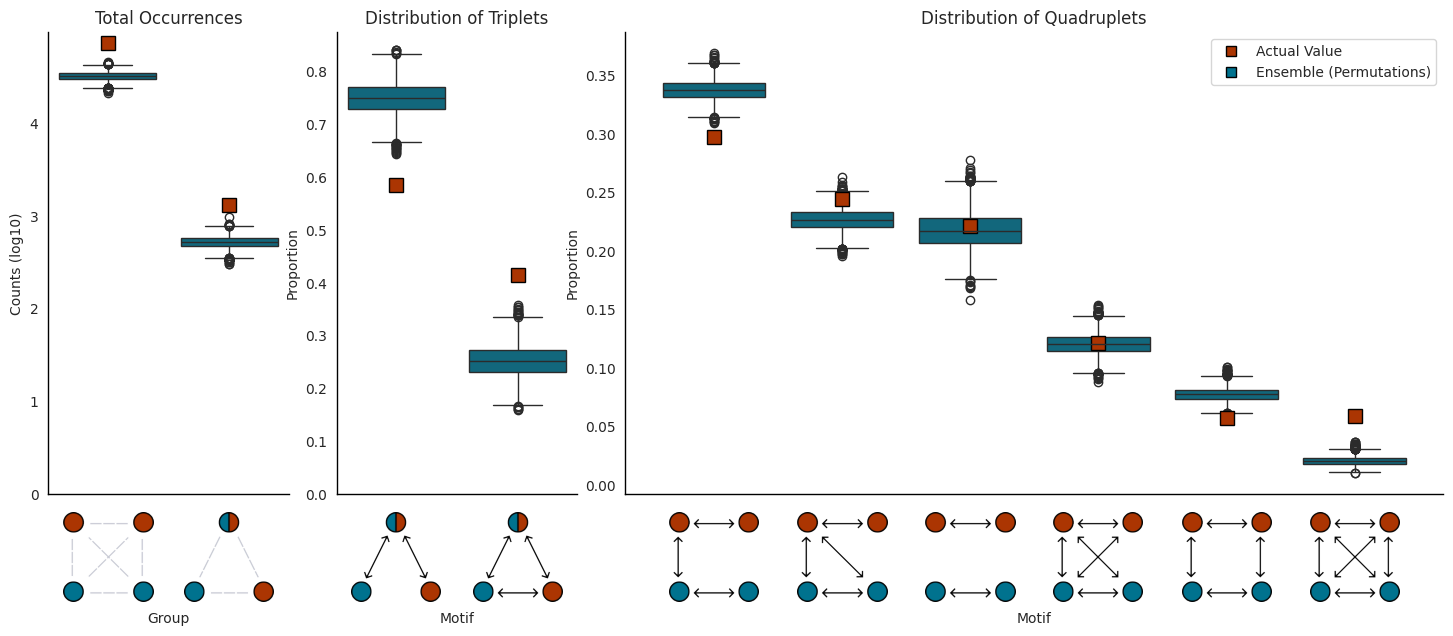

In [31]:
read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/both')

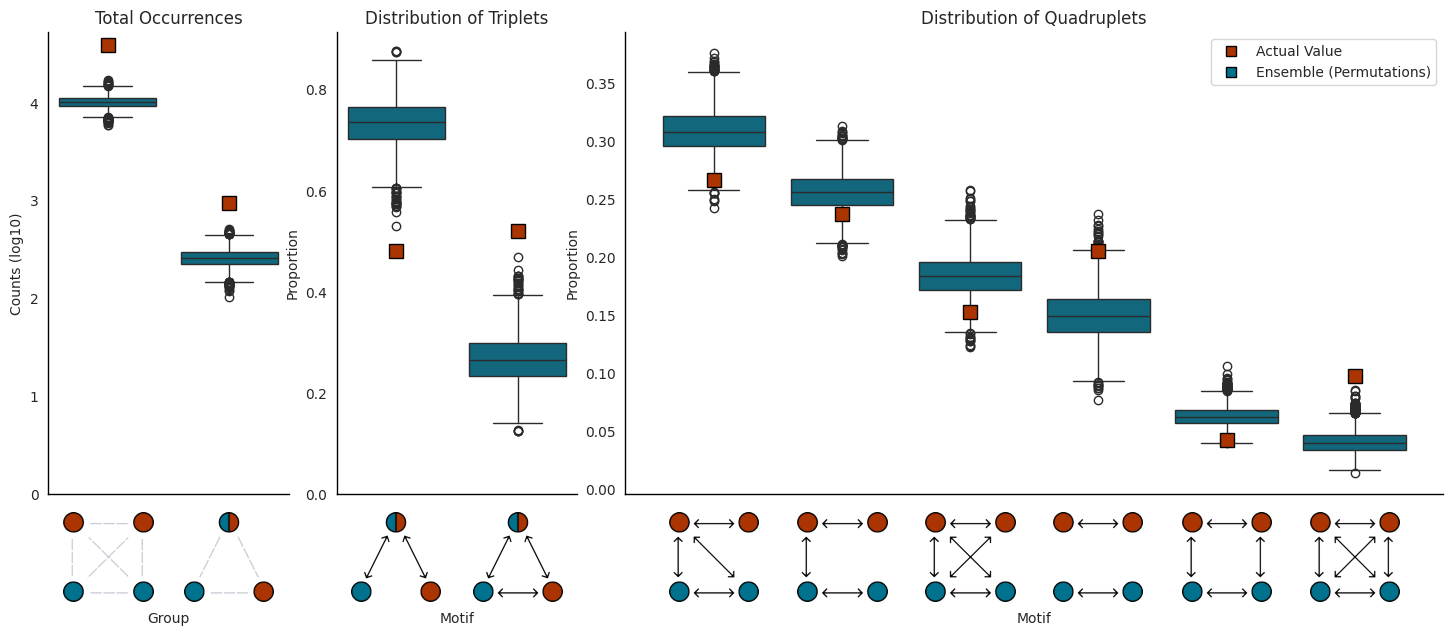

In [32]:
read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor')

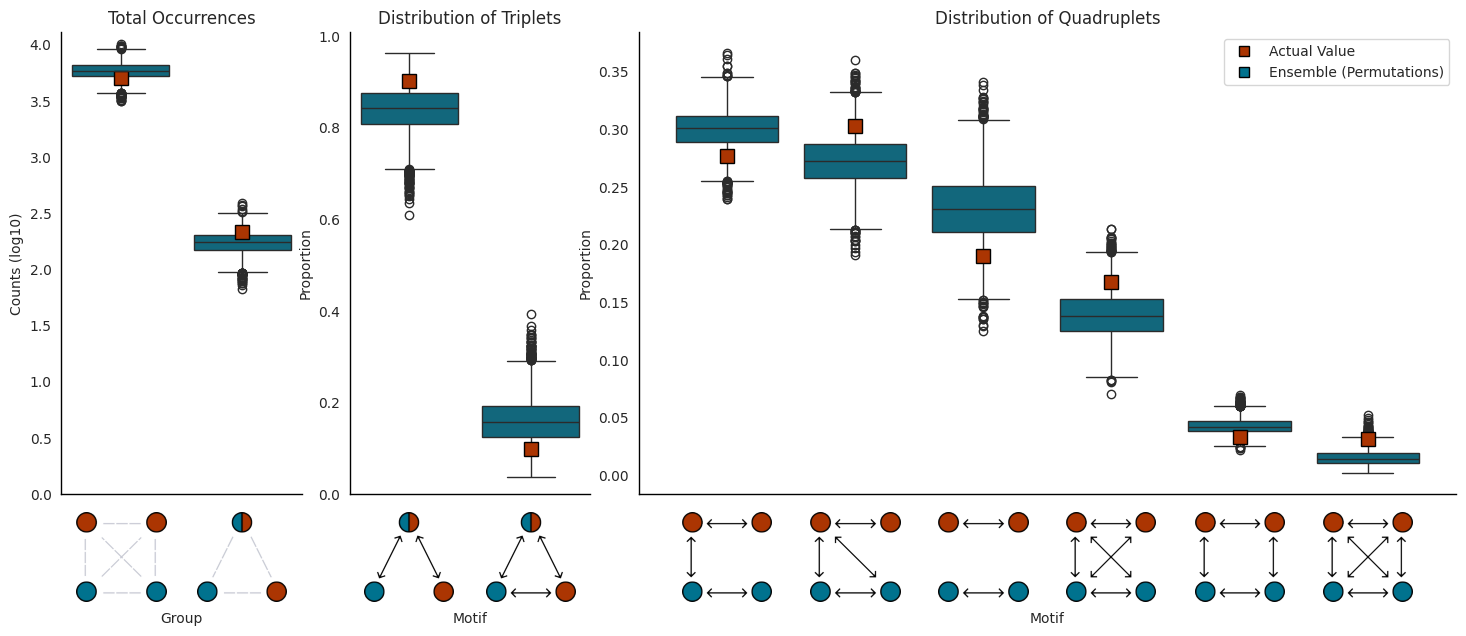

In [33]:
read_and_plot_motifs('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/normal')

In [109]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')

In [115]:
sum(df['4_no_crosstalk'] > motifs.loc['4_no_crosstalk', 'number']) / len(df)

0.0

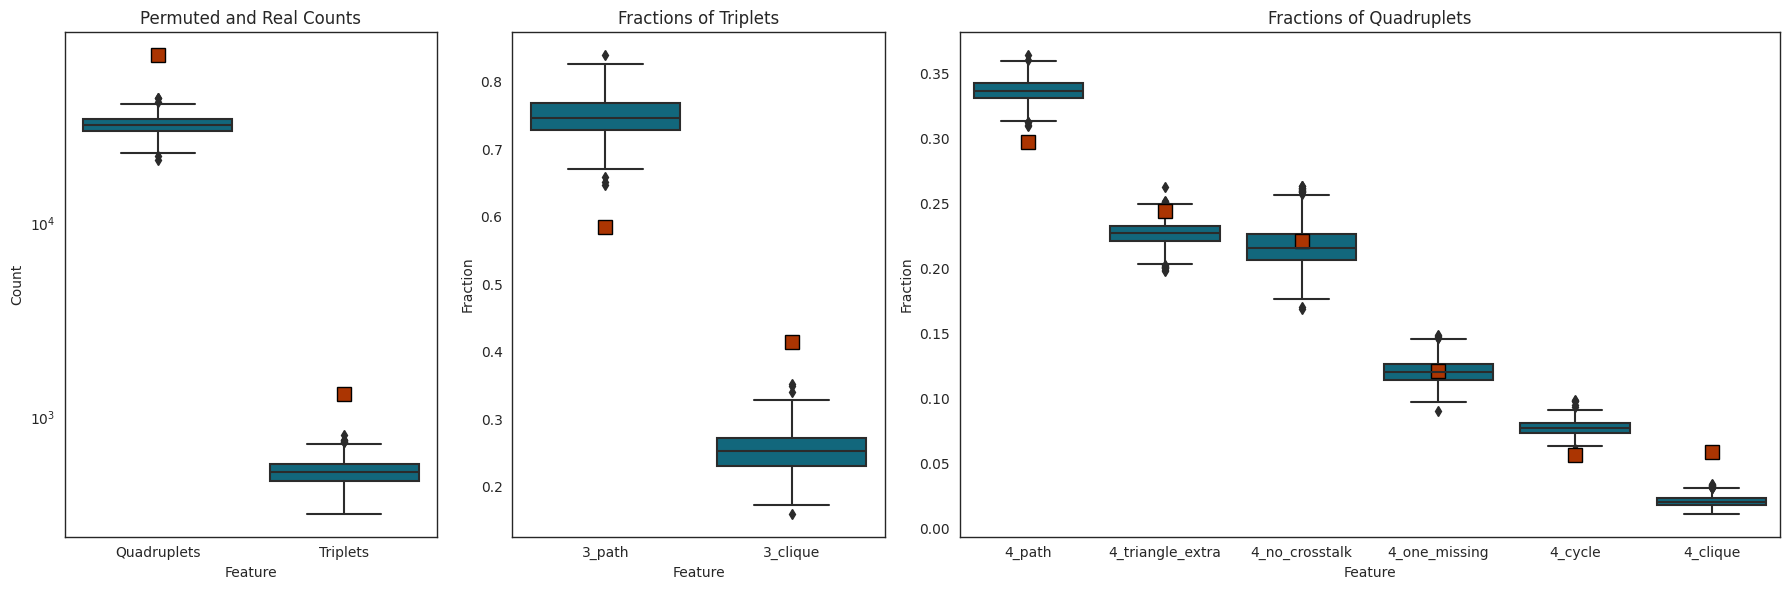

In [71]:
# Define the subplot mosaic layout
fig, axs = plt.subplot_mosaic(
    '''
    ABCC
    ''',
    figsize=(18, 6)
)

style = dict(marker='s', linestyle=' ', markersize=10,
             markerfacecolor=tcolor, markeredgecolor='k')

# Plot 1: Permuted and Real Counts (sorted by median, descending)
# Sort by median of permuted values in descending order
sorted_features_1 = df_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
df_long_sorted = df_long[df_long["Feature"].isin(sorted_features_1)]

# Convert real values to a Series, using feature names from the DataFrame
real_values_series_1 = pd.Series(real_values, index=df_long["Feature"].unique())

# Reorder real values based on the sorted order of permuted features
real_values_sorted_1 = real_values_series_1.loc[sorted_features_1]

sns.boxplot(x="Feature", y="Value", data=df_long_sorted, color=ncolor, order=sorted_features_1, ax=axs['A'])

# Plot the real values on top
axs['A'].plot(range(len(real_values_sorted_1)), real_values_sorted_1, **style)
axs['A'].set_yscale('log')
axs['A'].set_title("Permuted and Real Counts")
axs['A'].set_ylabel("Count")
axs['A'].set_xlabel("Feature")

# Plot 2: Fractions of Triplets (sorted by median, descending)
# Sort by median of permuted values in descending order
sorted_features_2 = perm_3_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
perm_3_fracs_sorted = perm_3_fracs_long[perm_3_fracs_long["Feature"].isin(sorted_features_2)]

# Convert real values to a Series, using feature names from the DataFrame
real_3_values_series = pd.Series(real_3_values, index=perm_3_fracs_long["Feature"].unique())

# Reorder real values based on the sorted order of permuted features
real_3_values_sorted = real_3_values_series.loc[sorted_features_2]

sns.boxplot(x="Feature", y="Value", data=perm_3_fracs_sorted, color=ncolor, order=sorted_features_2, ax=axs['B'])

# Plot the real values on top
axs['B'].plot(range(len(real_3_values_sorted)), real_3_values_sorted, **style)
axs['B'].set_title("Fractions of Triplets")
axs['B'].set_ylabel("Fraction")
axs['B'].set_xlabel("Feature")
axs['B'].set_xticks(range(len(real_3_values_sorted)))

# Plot 3: Fractions of Quadruplets (sorted by median, descending)
# Sort by median of permuted values in descending order
sorted_features_3 = perm_4_fracs_long.groupby("Feature")["Value"].median().sort_values(ascending=False).index
perm_4_fracs_sorted = perm_4_fracs_long[perm_4_fracs_long["Feature"].isin(sorted_features_3)]

# Convert real values to a Series, using feature names from the DataFrame
real_4_values_series = pd.Series(real_4_values, index=perm_4_fracs_long["Feature"].unique())

# Reorder real values based on the sorted order of permuted features
real_4_values_sorted = real_4_values_series.loc[sorted_features_3]

sns.boxplot(x="Feature", y="Value", data=perm_4_fracs_sorted, color=ncolor, order=sorted_features_3, ax=axs['C'])

# Plot the real values on top
axs['C'].plot(range(len(real_4_values_sorted)), real_4_values_sorted, **style)
axs['C'].set_title("Fractions of Quadruplets")
axs['C'].set_ylabel("Fraction")
axs['C'].set_xlabel("Feature")
axs['C'].set_xticks(range(len(real_4_values_sorted)))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


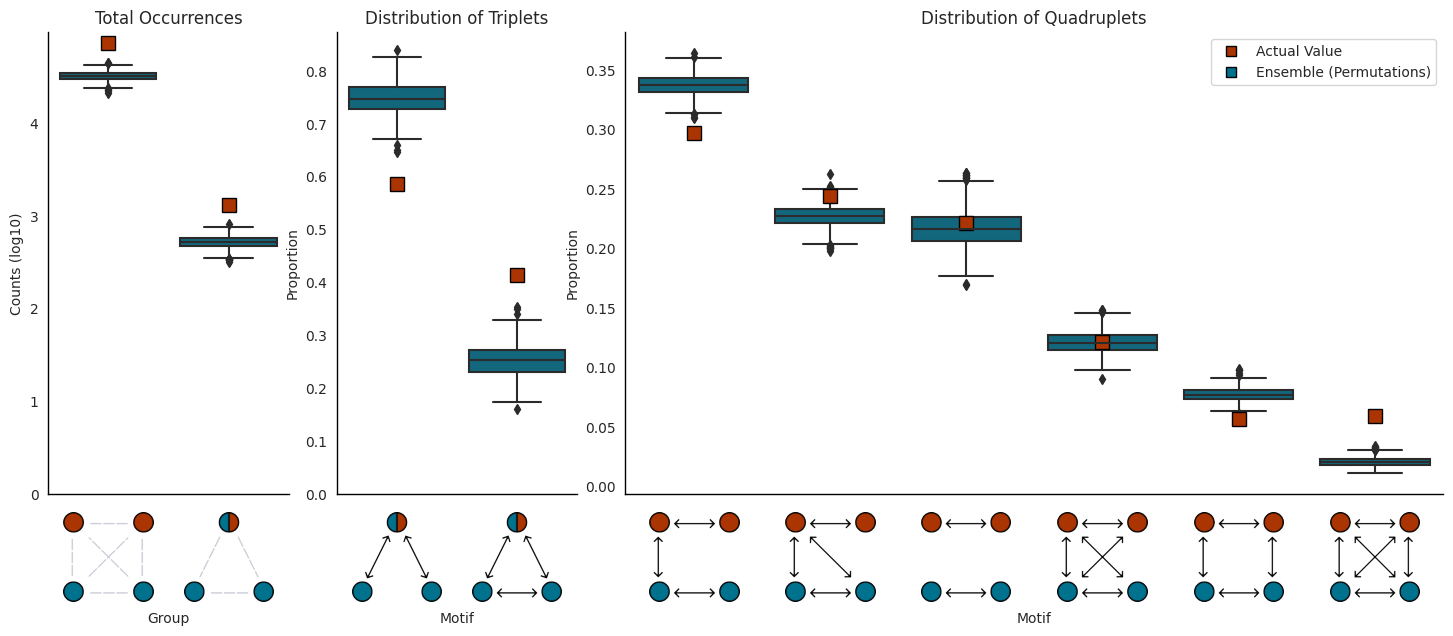

In [76]:
real_counts

number
motif                   
3_path               770
3_clique             546
4_no_crosstalk     16231
4_path             21818
4_triangle_extra   17938
4_cycle             4169
4_one_missing       8890
4_clique            4329

In [74]:
%%time
import networkx as nx
from itertools import product

# Number of nodes
nodes = [0, 1, 2]

# All possible weight combinations for undirected edges (including 0 as no edge)
# Each edge will have a weight (-1, 0, 1) and a ccc (0 or 1)
weights_and_ccc = list(product([-1, 0, 1], [0, 1]))  # Combinations of weight and ccc
edges_combinations = list(product(weights_and_ccc, repeat=3))  # 3 undirected edges: (0,1), (0,2), (1,2)

# Generate all possible networks
networks = []
for edges_combination in edges_combinations:
    # Create an undirected graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    # Assign weights and ccc to edges based on the current combination
    edges = []
    if edges_combination[0][0] != 0:  # If weight is non-zero, add the edge
        edges.append((0, 1, {"weight": edges_combination[0][0], "ccc": edges_combination[0][1]}))
    if edges_combination[1][0] != 0:  # If weight is non-zero, add the edge
        edges.append((0, 2, {"weight": edges_combination[1][0], "ccc": edges_combination[1][1]}))
    if edges_combination[2][0] != 0:  # If weight is non-zero, add the edge
        edges.append((1, 2, {"weight": edges_combination[2][0], "ccc": edges_combination[2][1]}))
    
    G.add_edges_from(edges)
    
    # Only add networks where all nodes have at least one edge
    if all(G.degree(node) > 0 for node in G.nodes()):
        networks.append(G)

# Function to compare edge attributes during isomorphism check
def edge_match(attr1, attr2):
    # Ensure both 'weight' and 'ccc' attributes match
    return attr1["weight"] == attr2["weight"] and attr1["ccc"] == attr2["ccc"]

# Filter unique networks by isomorphism class
unique_networks = []
for G in networks:
    # Check if the network is isomorphic to any already added network
    if not any(nx.is_isomorphic(G, H, edge_match=edge_match) for H in unique_networks):
        unique_networks.append(G)

# Filter networks where exactly two edges have ccc == 1, and each node has exactly one such edge
valid_networks = []
for G in unique_networks:
    # Count how many edges have ccc == 1
    ccc1_edges_count = sum(1 for _, _, data in G.edges(data=True) if data["ccc"] == 1)
    
    # Ensure exactly two edges have ccc == 1
    if ccc1_edges_count == 2:        
        valid_networks.append(G)

# Output results
print(f"Total networks generated: {len(networks)}")
print(f"Unique networks after filtering: {len(unique_networks)}")
print(f"Valid networks (with exactly two edges having ccc == 1 and each node has exactly one such edge): {len(valid_networks)}")

# Optional: Print edges of valid networks
#for i, net in enumerate(valid_networks):
#    print(f"Valid Network {i + 1}:")
#    print("Edges:", list(net.edges(data=True)))
#    print()


Total networks generated: 160
Unique networks after filtering: 30
Valid networks (with exactly two edges having ccc == 1 and each node has exactly one such edge): 9
CPU times: user 241 ms, sys: 2.07 ms, total: 243 ms
Wall time: 240 ms


In [85]:
import networkx as nx
from itertools import product

# Number of nodes (now 4 nodes)
nodes = [0, 1, 2, 3]

# All possible combinations of weight (-1, 0, 1) and ccc (0 or 1) for each edge
weights_and_ccc = list(product([-1, 0, 1], [0, 1]))  # Combinations of weight and ccc
edges_combinations = list(product(weights_and_ccc, repeat=6))  # 6 undirected edges for 4 nodes

# Generate all possible networks
networks = []
for edges_combination in edges_combinations:
    # Create an undirected graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    # Assign weights and ccc to edges based on the current combination
    edges = []
    # Map edges for a complete graph with 4 nodes (6 edges in total)
    edge_list = [
        (0, 1), (0, 2), (0, 3),
        (1, 2), (1, 3),
        (2, 3)
    ]
    
    for i, (edge, (weight, ccc)) in enumerate(zip(edge_list, edges_combination)):
        if weight != 0:  # If weight is non-zero, add the edge
            edges.append((edge[0], edge[1], {"weight": weight, "ccc": ccc}))
    
    G.add_edges_from(edges)
    
    # Only add networks where all nodes have at least one edge
    if all(G.degree(node) > 0 for node in G.nodes()):
        networks.append(G)

# Function to compare edge attributes during isomorphism check
def edge_match(attr1, attr2):
    # Ensure both 'weight' and 'ccc' attributes match
    return attr1["weight"] == attr2["weight"] and attr1["ccc"] == attr2["ccc"]

# Filter networks where exactly two edges have ccc == 1, and each node has exactly one such edge
valid_networks = []
for G in networks:
    # Count how many edges have ccc == 1
    ccc1_edges_count = sum(1 for _, _, data in G.edges(data=True) if data["ccc"] == 1)
    
    # Ensure exactly two edges have ccc == 1
    if ccc1_edges_count == 2:
        # Initialize the count of 'ccc == 1' edges for each node
        node_ccc_count = {node: 0 for node in G.nodes()}  # Ensure this is a dictionary
        
        # Count edges with ccc == 1 for each node
        for edge_u, edge_v, data in G.edges(data=True):
            if data["ccc"] == 1:
                node_ccc_count[edge_u] += 1
                node_ccc_count[edge_v] += 1
        
        # Only add the network if every node has exactly one edge with ccc == 1
        if all(count == 1 for count in node_ccc_count.values()):
            valid_networks.append(G)

# Function to check if a network is isomorphic to any already accepted network
def is_unique_network(G, unique_networks):
    for H in unique_networks:
        if nx.is_isomorphic(G, H, edge_match=edge_match):
            return False
    return True

# List to store unique networks
unique_networks = []

# Loop through valid networks and keep only the unique ones (based on isomorphism)
for G in valid_networks:
    if is_unique_network(G, unique_networks):
        unique_networks.append(G)

# Output results
print(f"Total networks generated: {len(networks)}")
print(f"Valid networks (with exactly two edges having ccc == 1 and each node has exactly one such edge): {len(valid_networks)}")
print(f"Unique networks after isomorphism filtering: {len(unique_networks)}")

# Optional: Print edges of unique networks
for i, net in enumerate(unique_networks):
    print(f"Unique Network {i + 1}:")
    print("Edges:", list(net.edges(data=True)))
    print()


Total networks generated: 40704
Valid networks (with exactly two edges having ccc == 1 and each node has exactly one such edge): 3072
Unique networks after isomorphism filtering: 69
Unique Network 1:
Edges: [(0, 1, {'weight': -1, 'ccc': 0}), (0, 2, {'weight': -1, 'ccc': 0}), (0, 3, {'weight': -1, 'ccc': 1}), (1, 2, {'weight': -1, 'ccc': 1}), (1, 3, {'weight': -1, 'ccc': 0}), (2, 3, {'weight': -1, 'ccc': 0})]

Unique Network 2:
Edges: [(0, 1, {'weight': -1, 'ccc': 0}), (0, 2, {'weight': -1, 'ccc': 0}), (0, 3, {'weight': -1, 'ccc': 1}), (1, 2, {'weight': -1, 'ccc': 1}), (1, 3, {'weight': -1, 'ccc': 0})]

Unique Network 3:
Edges: [(0, 1, {'weight': -1, 'ccc': 0}), (0, 2, {'weight': -1, 'ccc': 0}), (0, 3, {'weight': -1, 'ccc': 1}), (1, 2, {'weight': -1, 'ccc': 1}), (1, 3, {'weight': -1, 'ccc': 0}), (2, 3, {'weight': 1, 'ccc': 0})]

Unique Network 4:
Edges: [(0, 1, {'weight': -1, 'ccc': 0}), (0, 2, {'weight': -1, 'ccc': 0}), (0, 3, {'weight': -1, 'ccc': 1}), (1, 2, {'weight': -1, 'ccc': 1})

In [86]:
78 / 24

3.25

In [68]:
[count == 1 for count in node_ccc_count.values()]

[True, True, False]

In [65]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1, 'ccc': 1}), (0, 2, {'weight': 1, 'ccc': 1}), (1, 2, {'weight': 1, 'ccc': 1})])

In [69]:
node_ccc_count

{0: 1, 1: 1, 2: 2}

In [64]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1, 'ccc': 1}), (0, 2, {'weight': 1, 'ccc': 1}), (1, 2, {'weight': 1, 'ccc': 1})])

In [60]:
[1 for _, _, data in G.edges(data=True) if data["ccc"] == 1]

[1, 1, 1]

In [48]:
import networkx as nx
from itertools import product

# Number of nodes
nodes = [0, 1, 2, 3]

# All possible weight combinations for undirected edges (including 0 as no edge)
# Each edge will have a weight (-1, 0, 1) and a ccc (0 or 1)
weights_and_ccc = list(product([-1, 0, 1], [0, 1]))  # Combinations of weight and ccc
edges_combinations = list(product(weights_and_ccc, repeat=6))  # 6 undirected edges: (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)

# Generate all possible networks
networks = []
for edges_combination in edges_combinations:
    # Create an undirected graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    # Assign weights and ccc to edges based on the current combination
    edges = []
    if edges_combination[0][0] != 0:  # If weight is non-zero, add the edge
        edges.append((0, 1, {"weight": edges_combination[0][0], "ccc": edges_combination[0][1]}))
    if edges_combination[1][0] != 0:  # If weight is non-zero, add the edge
        edges.append((0, 2, {"weight": edges_combination[1][0], "ccc": edges_combination[1][1]}))
    if edges_combination[2][0] != 0:  # If weight is non-zero, add the edge
        edges.append((0, 3, {"weight": edges_combination[2][0], "ccc": edges_combination[2][1]}))
    if edges_combination[3][0] != 0:  # If weight is non-zero, add the edge
        edges.append((1, 2, {"weight": edges_combination[3][0], "ccc": edges_combination[3][1]}))
    if edges_combination[4][0] != 0:  # If weight is non-zero, add the edge
        edges.append((1, 3, {"weight": edges_combination[4][0], "ccc": edges_combination[4][1]}))
    if edges_combination[5][0] != 0:  # If weight is non-zero, add the edge
        edges.append((2, 3, {"weight": edges_combination[5][0], "ccc": edges_combination[5][1]}))
    
    G.add_edges_from(edges)
    
    # Only add networks where all nodes have at least one edge
    if all(G.degree(node) > 0 for node in G.nodes()):
        networks.append(G)

# Function to compare edge attributes during isomorphism check
def edge_match(attr1, attr2):
    # Ensure both 'weight' and 'ccc' attributes match
    return attr1["weight"] == attr2["weight"] and attr1["ccc"] == attr2["ccc"]

# Filter unique networks
unique_networks = []
for G in networks:
    if not any(nx.is_isomorphic(G, H, edge_match=edge_match) for H in unique_networks):
        unique_networks.append(G)

# Filter networks where exactly two edges have ccc == 1, and each node has exactly one edge with ccc == 1
valid_networks = []
for G in unique_networks:
    # Count how many edges have ccc == 1
    ccc1_edges_count = sum(1 for _, _, data in G.edges(data=True) if data["ccc"] == 1)
    
    # Check if exactly two edges have ccc == 1
    if ccc1_edges_count == 2:
        # Ensure each node has exactly one edge with ccc == 1
        node_ccc_count = {node: 0 for node in G.nodes()}
        for _, _, data in G.edges(data=True):
            if data["ccc"] == 1:
                node_ccc_count[_[0]] += 1
                node_ccc_count[_[1]] += 1
        
        # Keep the network if every node has exactly one edge with ccc == 1
        if all(count == 1 for count in node_ccc_count.values()):
            valid_networks.append(G)

# Output results
print(f"Total networks generated: {len(networks)}")
print(f"Unique networks after filtering: {len(unique_networks)}")
print(f"Valid networks (with exactly two edges having ccc == 1 and each node has exactly one such edge): {len(valid_networks)}")

# Optional: Print edges of valid networks
for i, net in enumerate(valid_networks):
    print(f"Valid Network {i + 1}:")
    print("Edges:", list(net.edges(data=True)))
    print()


KeyboardInterrupt: 

In [43]:
(56 + 7) / (3 * 8)

2.625

In [80]:
z_score = (real_counts.T - df.mean()) / df.std()
z_score = z_score.loc['number']
z_score = z_score.sort_values()

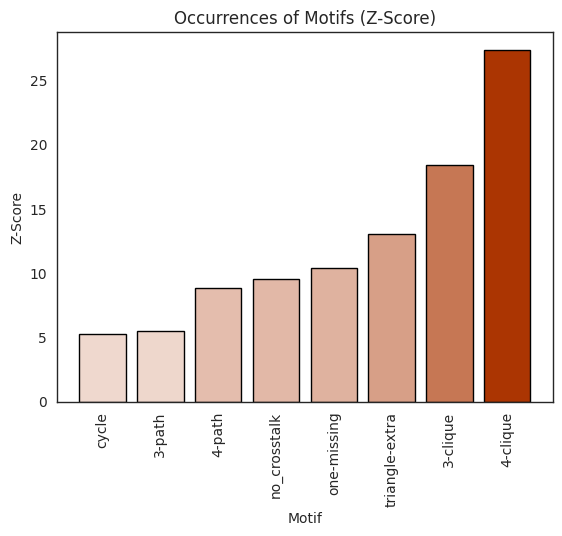

In [117]:
import matplotlib.colors as mcolors

max_value = max(z_score)  # Determine the max value for normalization

# Define ncolor and create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', ['white', tcolor])

# Normalize the z_score values to range [0, 1]
norm = plt.Normalize(0, max_value)
colors = cmap(norm(z_score))

# Plot the bars
plt.bar(z_score.index, z_score.values, color=colors, edgecolor='k', width=0.8)
plt.ylabel('Z-Score')
plt.xlabel('Motif')
plt.title('Occurrences of Motifs (Z-Score)')
plt.xticks(rotation=90)

plt.show()


# GPCRs

In [5]:
# Read GPCRs
gpcrs = pd.read_csv('/home/fraimondi/BIOINFO1_BK/francesco/GPCR/gpcrs_genes.txt')['Symbol'].values

# Read ligands
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc_lr_pairs.csv')
lr = lr[lr.receptor.isin(gpcrs)]

# Read G-Proteins coupling
gprots_couplings = pd.read_csv('/home/lnemati/resources/gpcr_couplings/gpcr_couplings.csv')
gprots_couplings = gprots_couplings.query('type != "precogx_only"')
gprots_couplings.set_index('gpcr', inplace=True, drop=False)
gprots_couplings.index.name = None
gprots_couplings = gprots_couplings.groupby('gpcr')['gprot'].apply(list)
gprots = gprots_couplings.values.sum()


In [6]:
# Get G-Proteins, GPCRs and their ligands
gpcrs_genes = set(gpcrs) | set(gprots) | set(lr.ligand.values) | set(lr.receptor.values)

In [7]:
#t_matrix = pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/tumor_gpcrs_median_corr.csv', index_col=0)
#n_matrix = pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/normal_gpcrs_median_corr.csv', index_col=0)
ncoev    = pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/normal_jaccard_coevolution.csv', index_col=0)

df = pd.DataFrame(columns=['gpcr', 'interactor', 'interactor_type', 'condition', 'value'])

for gpcr in gprots_couplings.index.intersection(ncoev.index):
    couplings = ncoev.index.intersection(gprots_couplings.loc[gpcr])
    values = ncoev.loc[gpcr, couplings].to_frame(name = 'value')
    values['gpcr'] = gpcr
    values['interactor'] = values.index
    values['interactor_type'] = 'G-Protein'
    values['tissue'] = 'Coevolution'
    values['condition'] = 'Coevolution'
    values['value_type'] = 'jaccard'

    df = pd.concat([df, values])
    
for gpcr in ncoev.index.intersection(lr.receptor.unique()):
    ligands = ncoev.index.intersection(lr[lr['receptor'] == gpcr].ligand.unique())
    values = ncoev.loc[gpcr, ligands].to_frame(name = 'value')
    values['gpcr'] = gpcr
    values['interactor'] = values.index
    values['interactor_type'] = 'Ligand'
    values['tissue'] = 'Coevolution'
    values['condition'] = 'Coevolution'
    values['value_type'] = 'jaccard'

    df = pd.concat([df, values])

df = df.reset_index(drop=True)

In [8]:
df = pd.concat([df, pd.read_csv('/home/lnemati/pathway_crosstalk/results/gpcrs/all_gpcr_interactions.csv')])
df = df[df['subtissue'] != 'testis']
df = df.groupby(['gpcr', 'interactor', 'condition', 'interactor_type', 'tissue', 'value_type'], as_index=False)['value'].mean()
df = df.query('value_type in ["correlation", "jaccard"]')


In [9]:
df['condition'] =df['condition'].replace({'normal': 'Normal Co-Expression', 'tumor': 'Tumor Co-Expression'})

In [10]:
# Filter out 0 values
#df = df[df['value'] != 0]

<Axes: title={'center': 'Coevolution'}, xlabel='Jaccard Index', ylabel='Proportion'>

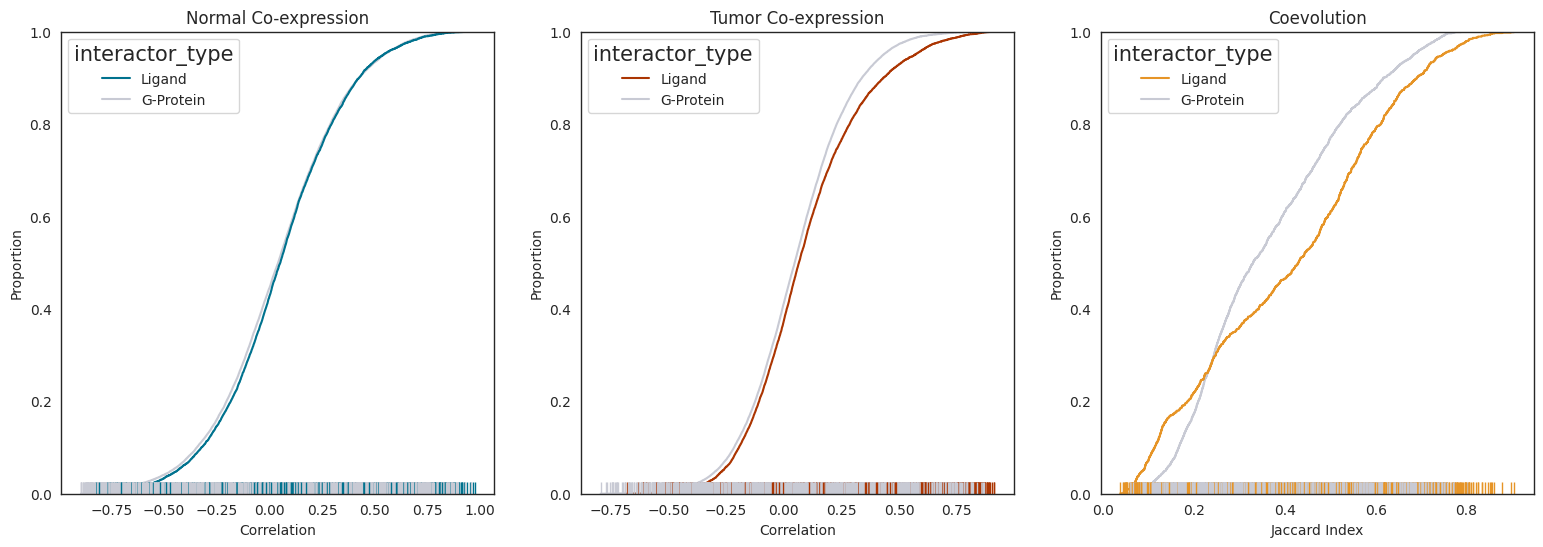

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(19,6))
ax1.set_title('Normal Co-expression')
ax1.set_xlabel('Correlation')
ndf = df[df['condition'] == 'Normal Co-Expression']
sns.ecdfplot(x='value', hue='interactor_type', data=ndf, ax=ax1, palette={'G-Protein': lightgray, 'Ligand': ncolor})
sns.rugplot(x='value', hue='interactor_type', data=ndf, ax=ax1, palette={'G-Protein': lightgray, 'Ligand': ncolor})

ax2.set_title('Tumor Co-expression')
ax2.set_xlabel('Correlation')
tdf = df[df['condition'] == 'Tumor Co-Expression']
sns.ecdfplot(x='value', hue='interactor_type', data=tdf, ax=ax2, palette={'G-Protein': lightgray, 'Ligand': tcolor})
sns.rugplot(x='value', hue='interactor_type', data=tdf, ax=ax2, palette={'G-Protein': lightgray, 'Ligand': tcolor})

ax3.set_title('Coevolution')
ax3.set_xlabel('Jaccard Index')
ncdf = df[df['condition'] == 'Coevolution']
sns.ecdfplot(x='value', hue='interactor_type', data=ncdf, ax=ax3, palette={'G-Protein': lightgray, 'Ligand': orangecolor})
sns.rugplot(x='value', hue='interactor_type', data=ncdf, ax=ax3, palette={'G-Protein': lightgray, 'Ligand': orangecolor})

#plt.savefig('/home/lnemati/pathway_crosstalk/results/gpcrs/cumulative_distribution.pdf', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/gpcrs/cumulative_distribution.png', bbox_inches='tight')

In [12]:
print('Tumor: ligands vs gprots')
xx = tdf[(tdf['interactor_type'] == 'Ligand')].value
yy = tdf[(tdf['interactor_type'] == 'G-Protein')].value

result = mannwhitneyu(xx, yy)
auroc = result.statistic / (len(xx) * len(yy))
pval = result.pvalue
print('  ',auroc, pval)

print('Normal: ligands vs gprots')
xx = ndf[(ndf['interactor_type'] == 'Ligand')].value
yy = ndf[(ndf['interactor_type'] == 'G-Protein')].value

result = mannwhitneyu(xx, yy)
auroc = result.statistic / (len(xx) * len(yy))
pval = result.pvalue
print('  ',auroc, pval)

Tumor: ligands vs gprots
   0.5356834779092683 4.7943750838203475e-23
Normal: ligands vs gprots
   0.5111753529417674 0.0022139539416447824


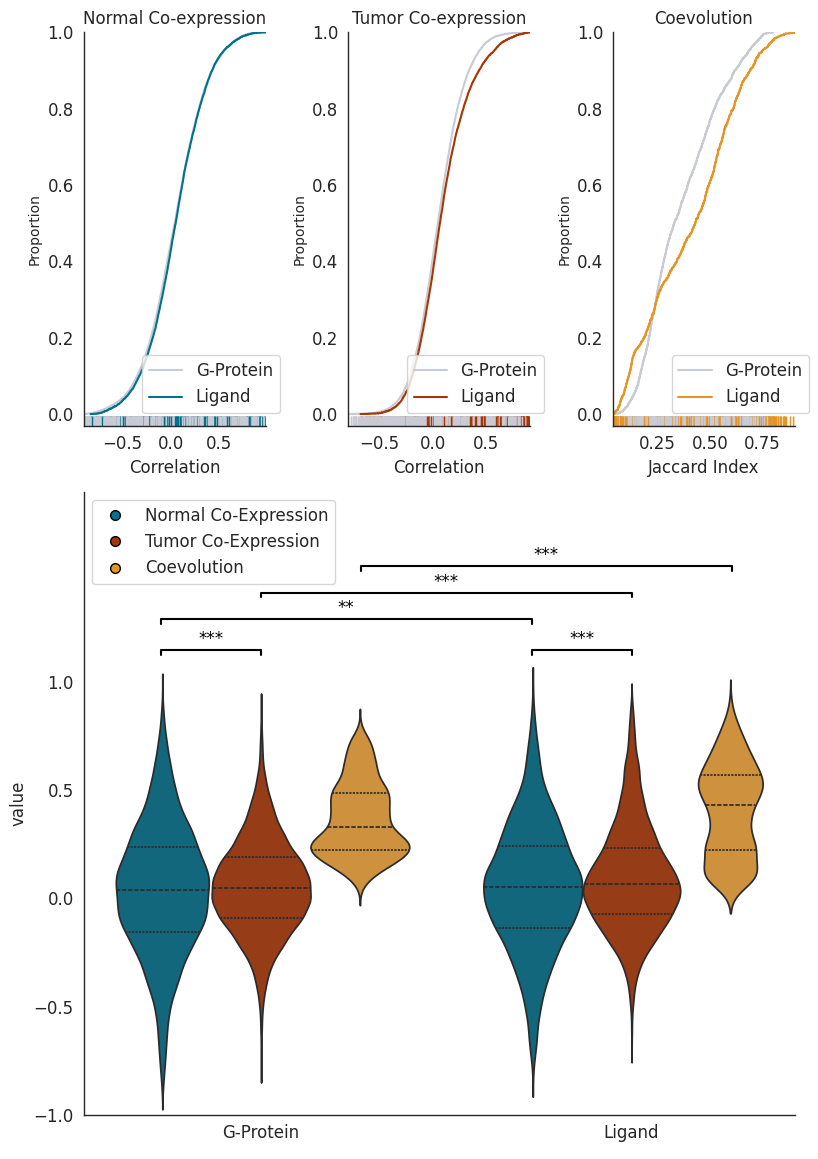

In [13]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import subplot_mosaic

fs = 12

# Perform Mann-Whitney U test for each 'interactor_type' between 'Tumor Co-Expression' and 'Normal Co-Expression'
types = df['interactor_type'].unique()
conditions = ['Normal Co-Expression', 'Tumor Co-Expression', 'Coevolution']
p_values = []
comparisons = []
aurocs = []

# Plot the violin and strip plot as before
fig, axes = subplot_mosaic(
    mosaic="""
    ABC
    ABC
    DDD
    DDD
    DDD
    """,
    figsize=(8.27, 11.69)
)

# Cumulative distributions
axes['A'].set_title('Normal Co-expression', fontsize=fs)
axes['A'].set_xlabel('Correlation', fontsize=fs)
ndf = df[df['condition'] == 'Normal Co-Expression']
sns.ecdfplot(x='value', hue='interactor_type', data=ndf, ax=axes['A'], palette={'G-Protein': lightgray, 'Ligand': ncolor})
sns.rugplot(x='value', hue='interactor_type', data=ndf, ax=axes['A'], palette={'G-Protein': lightgray, 'Ligand': ncolor})
axes['A'].set_xlim(ndf.value.min(), ndf.value.max())

axes['B'].set_title('Tumor Co-expression', fontsize=fs)
axes['B'].set_xlabel('Correlation', fontsize=fs)
tdf = df[df['condition'] == 'Tumor Co-Expression']
sns.ecdfplot(x='value', hue='interactor_type', data=tdf, ax=axes['B'], palette={'G-Protein': lightgray, 'Ligand': tcolor})
sns.rugplot(x='value', hue='interactor_type', data=tdf, ax=axes['B'], palette={'G-Protein': lightgray, 'Ligand': tcolor})
axes['B'].set_xlim(tdf.value.min(), tdf.value.max())

axes['C'].set_title('Coevolution', fontsize=fs)
axes['C'].set_xlabel('Jaccard Index', fontsize=fs)
ncdf = df[df['condition'] == 'Coevolution']
sns.ecdfplot(x='value', hue='interactor_type', data=ncdf, ax=axes['C'], palette={'G-Protein': lightgray, 'Ligand': orangecolor})
sns.rugplot(x='value', hue='interactor_type', data=ncdf, ax=axes['C'], palette={'G-Protein': lightgray, 'Ligand': orangecolor})
axes['C'].set_xlim(ncdf.value.min(), ncdf.value.max())


palette_light = {'Normal Co-Expression': lightncolor, 'Tumor Co-Expression': lighttcolor, 'Coevolution': lightorangecolor}
palette = {'Normal Co-Expression': ncolor, 'Tumor Co-Expression': tcolor, 'Coevolution': orangecolor}

sns.violinplot(
    x='interactor_type',
    y='value',
    hue='condition',
    data=df,
    #palette=palette_light,
    palette=palette,
    ax=axes['D'],
    order=['G-Protein', 'Ligand'],
    hue_order = conditions,
    inner='quart'
)

# Collect p-values for interactor_type comparisons within each condition
for type_ in types:
    subset = df[df['interactor_type'] == type_]
    tumor_values = subset[subset['condition'] == 'Tumor Co-Expression']['value']
    normal_values = subset[subset['condition'] == 'Normal Co-Expression']['value']
    
    if len(tumor_values) > 0 and len(normal_values) > 0:
        stat, p_value = mannwhitneyu(tumor_values, normal_values, alternative='two-sided')
        aurocs.append(stat / (len(tumor_values) * len(normal_values)))
        p_values.append(p_value)
        comparisons.append((type_, 'Tumor vs Normal'))

# Perform comparisons between Ligand and G-Protein within each condition
for condition in conditions:
    subset = df[df['condition'] == condition]
    ligand_values = subset[subset['interactor_type'] == 'Ligand']['value']
    gprotein_values = subset[subset['interactor_type'] == 'G-Protein']['value']
    
    if len(ligand_values) > 0 and len(gprotein_values) > 0:
        stat, p_value = mannwhitneyu(ligand_values, gprotein_values, alternative='two-sided')
        aurocs.append(stat / (len(ligand_values) * len(gprotein_values)))
        p_values.append(p_value)
        comparisons.append(('Ligand', 'G-Protein', condition))  # Ensure we keep labels consistent here

# Multiple Hypothesis Testing Correction
corrected_p_values = false_discovery_control(p_values)

# Maximum y-value for positioning significance bars
y_max = df['value'].max() + 0.05

# Annotate significance on the plot
for idx, comparison in enumerate(comparisons):        
    corrected_p = corrected_p_values[idx]
    if corrected_p < 0.001:
        annotation = '***'
    elif corrected_p < 0.01:
        annotation = '**'
    elif corrected_p < 0.05:
        annotation = '*'
    else:
        annotation = 'ns'  # Not significant
    
    if len(comparison) == 3:  # Ligand vs G-Protein comparisons
        
        if comparison[2] == 'Tumor Co-Expression':
            x_offset = 0
        elif comparison[2] == 'Normal Co-Expression':
            x_offset = -0.27
        elif comparison[2] == 'Coevolution':
            x_offset = 0.27
        
        x1 = types.tolist().index(comparison[0]) + x_offset
        x2 = types.tolist().index(comparison[1]) + x_offset
        y = y_max + (0.12 * y_max) * idx  # Offset each condition's bars slightly

        axes['D'].plot([x1, x1, x2, x2], [y, y + 0.02 * y_max, y + 0.02 * y_max, y], color='k')
        axes['D'].text((x1 + x2) / 2, y + 0.03 * y_max, annotation, ha='center', va='bottom', color='k', fontsize=fs)
        
    else: # Tumor vs Normal comparisons
        type_idx = types.tolist().index(comparison[0])
        x1, x2 = type_idx - 0.27, type_idx
        y = y_max + 0.1 * y_max

        axes['D'].plot([x1, x1, x2, x2], [y, y + 0.02 * y_max, y + 0.02 * y_max, y], color='k')
        axes['D'].text((x1 + x2) / 2, y + 0.03 * y_max, annotation, ha='center', va='bottom', color='k', fontsize=fs)

# Remove duplicate entries in the legend
handles, labels = axes['D'].get_legend_handles_labels()
unique = dict(zip(labels, handles))

# Create custom legend
handles = []

handles = [
    Line2D(
        [0], [0], marker='o', color='w', markerfacecolor=ncolor, 
        markeredgecolor='k', markersize=7, label='Normal Co-Expression'
    ),
    Line2D(
        [0], [0], marker='o', color='w', markerfacecolor=tcolor, 
        markeredgecolor='k', markersize=7, label='Tumor Co-Expression'
    ),
    Line2D(
        [0], [0], marker='o', color='w', markerfacecolor=orangecolor, 
        markeredgecolor='k', markersize=7, label='Coevolution'
    ),
]

axes['D'].set_ylim(-1, 1.88)
axes['D'].set_yticks([-1, -0.5, 0, 0.5, 1])
axes['D'].legend(handles, ['Normal Co-Expression', 'Tumor Co-Expression', 'Coevolution'], loc='upper left', fontsize=fs)

for ax_key, color, label in zip(['A', 'B', 'C'], [ncolor, tcolor, orangecolor], 
                                ['Normal Co-Expression', 'Tumor Co-Expression', 'Coevolution']):
    handles, labels = axes[ax_key].get_legend_handles_labels()
    axes[ax_key].set_ylim(-0.03, 1)
    
    # Redefine handles and labels if they were cleared
    if not handles:  
        handles = [
            Line2D([0], [0], marker='', color=lightgray, label='G-Protein'),
            Line2D([0], [0], marker='', color=color, label='Ligand')
        ]
        
    axes[ax_key].legend(handles=handles, labels=['G-Protein', 'Ligand'], fontsize=fs, bbox_to_anchor=[0.7, 0.105], loc='center')
    axes[ax_key].tick_params(axis='both', labelsize=fs)

axes['D'].set_xlabel(' ', fontsize=0)
axes['D'].set_ylabel('value', fontsize=fs)
axes['D'].tick_params(axis='both', labelsize=fs)


for ax_key in ['A', 'B', 'C', 'D']:
    axes[ax_key].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()

plt.savefig('/home/lnemati/pathway_crosstalk/results/gpcrs/gpcrs_figure.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/gpcrs/gpcrs_figure.png', bbox_inches='tight')

plt.show()

In [14]:
counts = df.groupby('tissue')['condition'].nunique()
tissues_both = counts[counts == 2].index

In [15]:
nauroc = {}
tauroc = {}
diff = {}

for tissue, tissue_df in df.query('tissue in @tissues_both and condition != "Coevolution"').groupby('tissue'):    
    for condition in ['Normal Co-Expression', 'Tumor Co-Expression']:
        subset = tissue_df[tissue_df['condition'] == condition]
        ligand_values = subset[subset['interactor_type'] == 'Ligand']['value']
        gprotein_values = subset[subset['interactor_type'] == 'G-Protein']['value']

        if len(ligand_values) > 0 and len(gprotein_values) > 0:
            stat, p_value = mannwhitneyu(ligand_values, gprotein_values, alternative='two-sided')
            auroc = stat / (len(ligand_values) * len(gprotein_values))
            
            if condition == 'Normal Co-Expression':
                nauroc[tissue] = auroc
                
            if condition == 'Tumor Co-Expression':
                tauroc[tissue] = auroc
                
tauroc = pd.Series(tauroc)
tauroc.name = 'tumor_auroc'

nauroc = pd.Series(nauroc)
nauroc.name = 'normal_auroc'

aurocs = tauroc.to_frame().join(nauroc)
aurocs['diff'] = aurocs['tumor_auroc'] - aurocs['normal_auroc']
aurocs = aurocs.sort_values(by='diff')
aurocs

tumor_auroc  normal_auroc      diff
colon             0.439403      0.546214 -0.106811
adrenal_gland     0.505166      0.529230 -0.024064
prostate          0.483303      0.498082 -0.014779
liver             0.517066      0.528460 -0.011395
esophagus         0.540353      0.538138  0.002216
brain             0.582174      0.576331  0.005842
lung              0.537665      0.525969  0.011696
kidney            0.504095      0.486557  0.017538
stomach           0.488485      0.467113  0.021373
ovary             0.533516      0.509210  0.024305
thyroid           0.528561      0.483498  0.045062
uterus            0.559531      0.471551  0.087980
pancreas          0.525793      0.431258  0.094535
breast            0.567247      0.470939  0.096308
skin              0.595837      0.498175  0.097662

In [29]:
from scipy.stats import pearsonr

gprot_diff = {}
ligs_diff = {}
diff = {}

for tissue, tissue_df in df.query('tissue in @tissues_both and condition != "Coevolution"').groupby('tissue'):
    for itype in ['G-Protein', 'Ligand']:
        subset = tissue_df[tissue_df['interactor_type'] == itype]
        
        # Separate Tumor and Normal subsets
        tumor_subset = subset[subset['condition'] == 'Tumor Co-Expression']
        normal_subset = subset[subset['condition'] == 'Normal Co-Expression']
        
        # Match entries using both 'gpcr' and 'interactor' columns
        merged = pd.merge(
            tumor_subset[['gpcr', 'interactor', 'value']].rename(columns={'value': 'tumor_value'}),
            normal_subset[['gpcr', 'interactor', 'value']].rename(columns={'value': 'normal_value'}),
            on=['gpcr', 'interactor']
        )

        if len(merged) > 1:  # Pearson correlation requires at least two points
            # Calculate Pearson correlation

            
            # Store the correlation
            if itype == 'G-Protein':
                gprot_diff[tissue] = p_value
            elif itype == 'Ligand':
                ligs_diff[tissue] = p_value


In [42]:
wilcoxon(merged['tumor_value'], merged['normal_value'], method='approx')

WilcoxonResult(statistic=13507.0, pvalue=0.5736646783837511)

In [104]:
from scipy.stats import wilcoxon
import pandas as pd

# Initialize an empty list to collect the data
results = []

# Iterate through tissues and interactor types
for tissue, tissue_df in df.query('tissue in @tissues_both and condition != "Coevolution"').groupby('tissue'):
    for itype in ['G-Protein', 'Ligand']:
        subset = tissue_df[tissue_df['interactor_type'] == itype]
        
        # Separate Tumor and Normal subsets
        tumor_subset = subset[subset['condition'] == 'Tumor Co-Expression']
        normal_subset = subset[subset['condition'] == 'Normal Co-Expression']
        
        # Match entries using both 'gpcr' and 'interactor' columns
        merged = pd.merge(
            tumor_subset[['gpcr', 'interactor', 'value']].rename(columns={'value': 'tumor_value'}),
            normal_subset[['gpcr', 'interactor', 'value']].rename(columns={'value': 'normal_value'}),
            on=['gpcr', 'interactor']
        )

        if len(merged) > 1:  # Wilcoxon test requires at least two points
            # Perform the Wilcoxon signed-rank test
            diff = merged['tumor_value'] - merged['normal_value']
            result = wilcoxon(diff, method='approx')
            p_value = result.pvalue
            z_stat  = result.zstatistic
            
            # Append the result as a dictionary
            results.append({
                'tissue': tissue,
                'interactor_type': itype,
                'z_stat': z_stat,
                'p_value': p_value
            })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)
results_df['pval_adj'] = false_discovery_control(results_df['p_value'])
results_df = results_df.drop(columns='p_value')

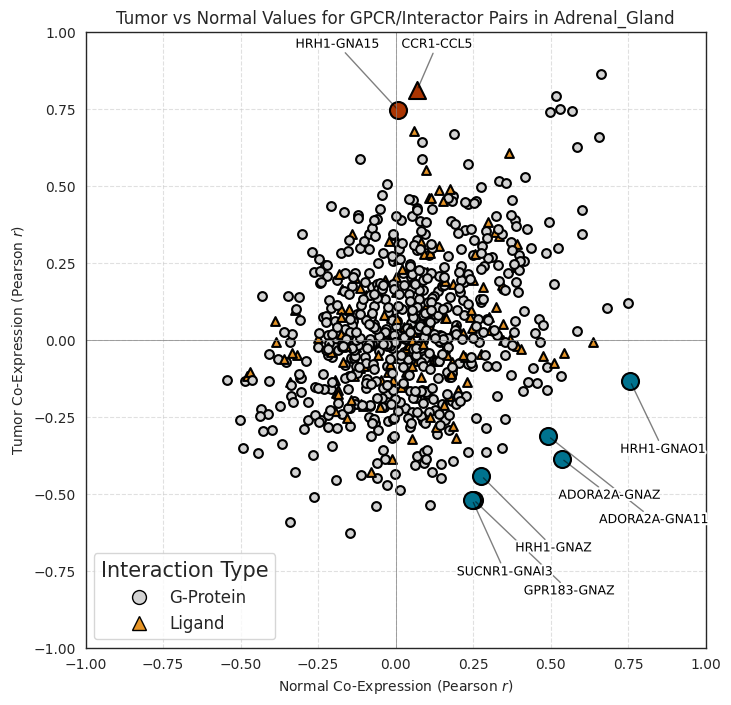

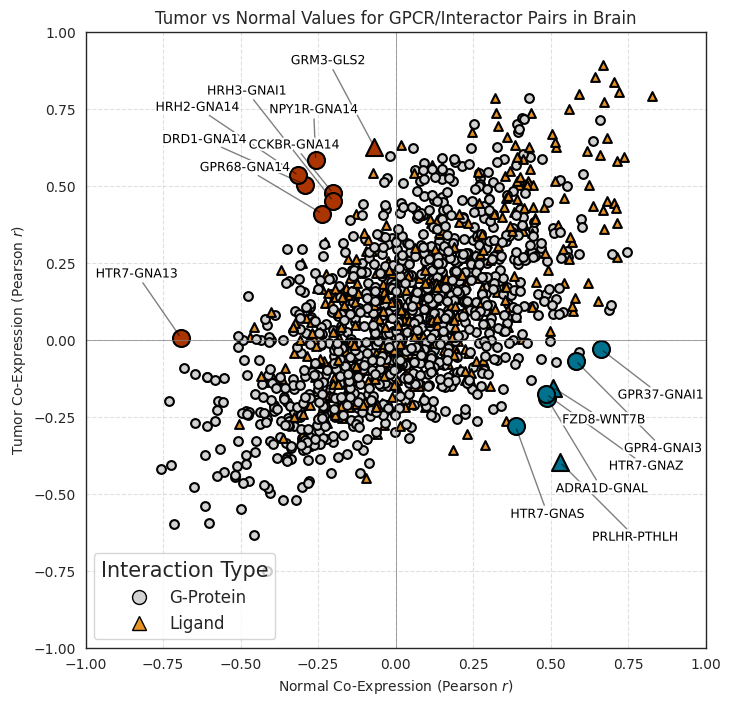

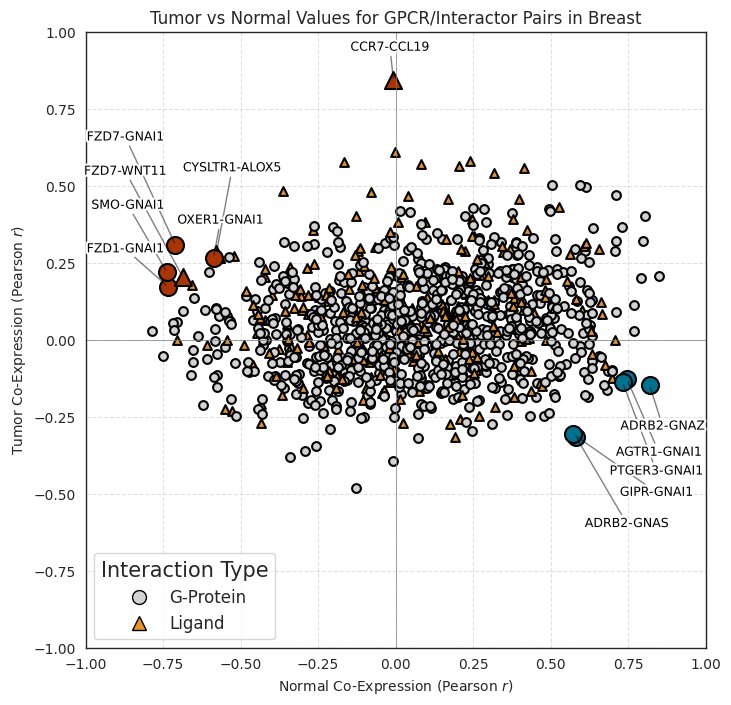

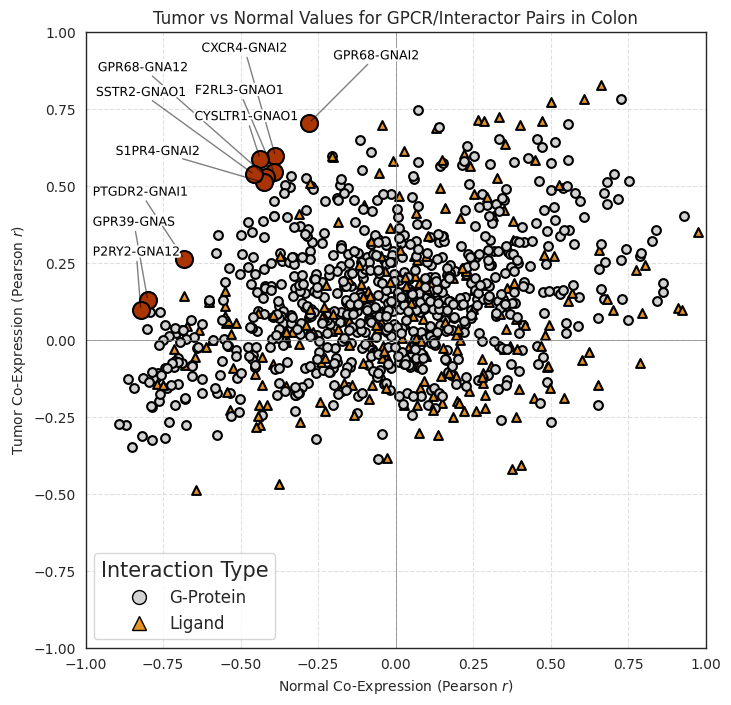

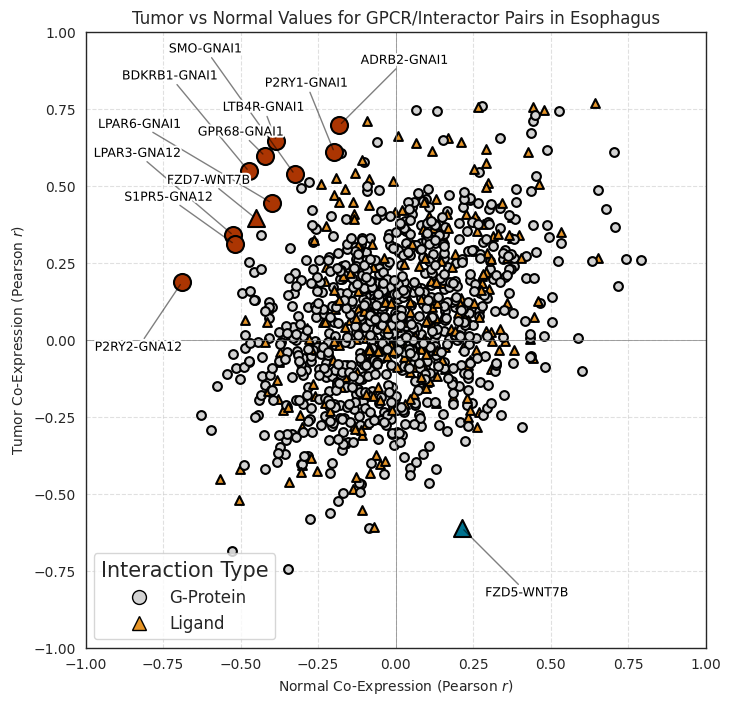

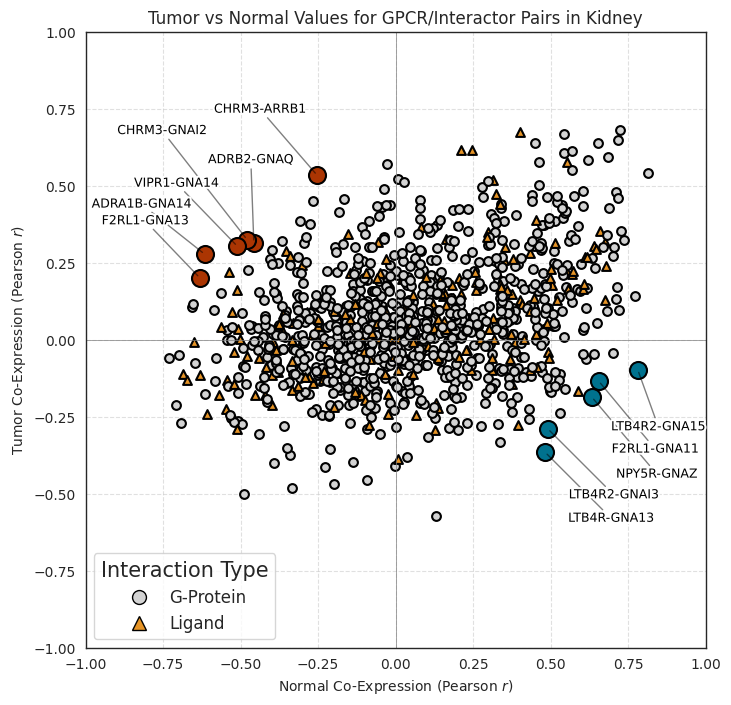

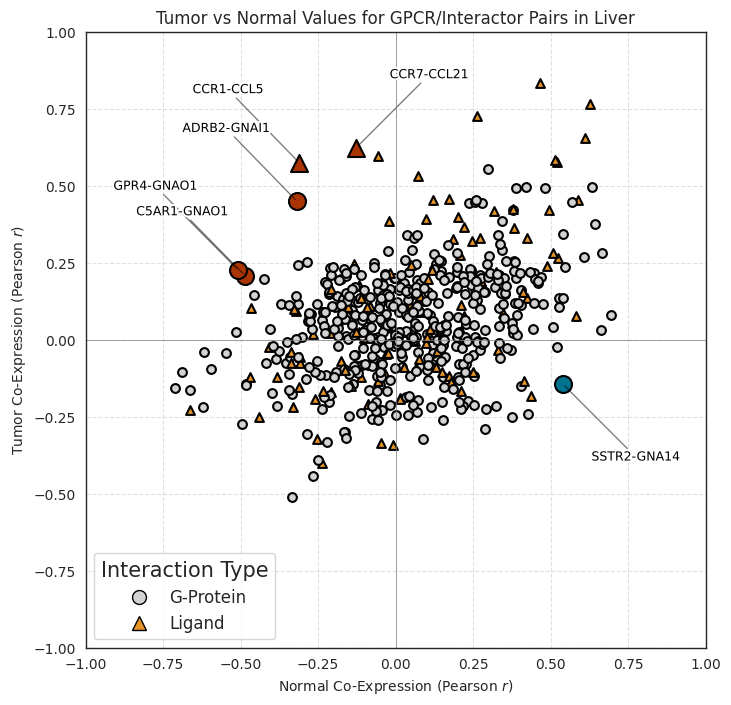

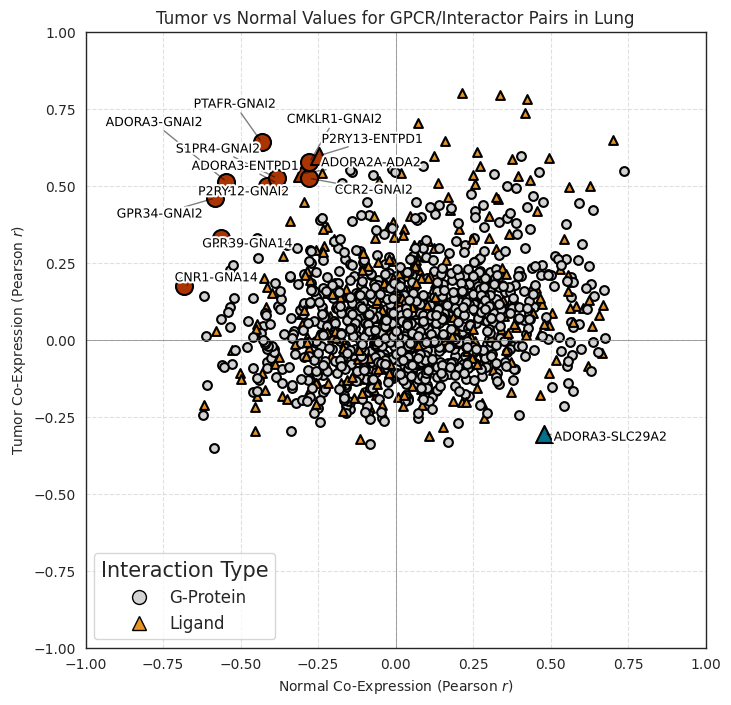

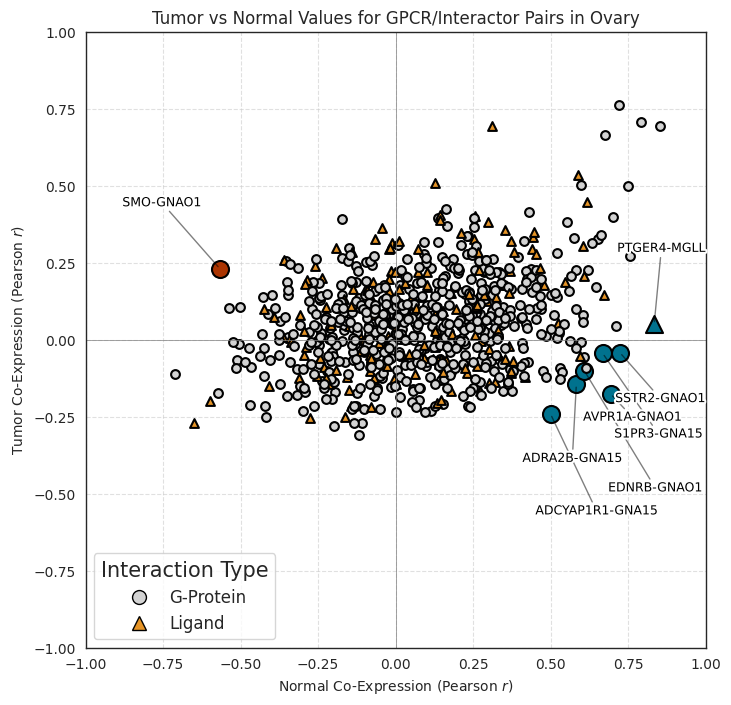

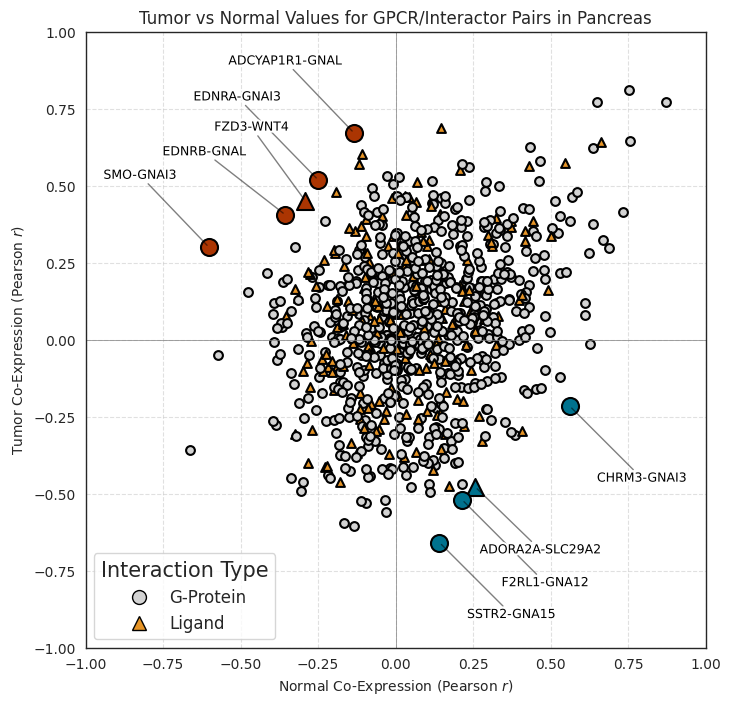

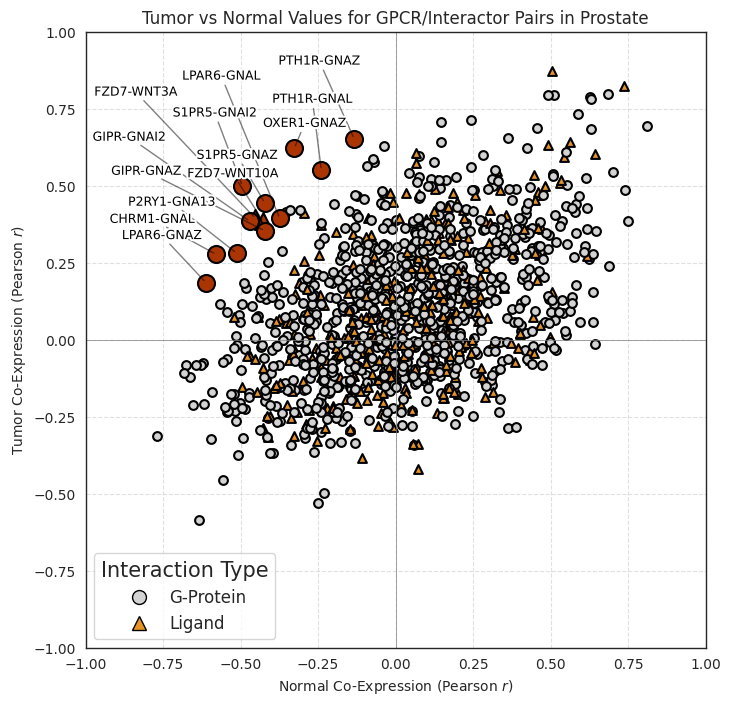

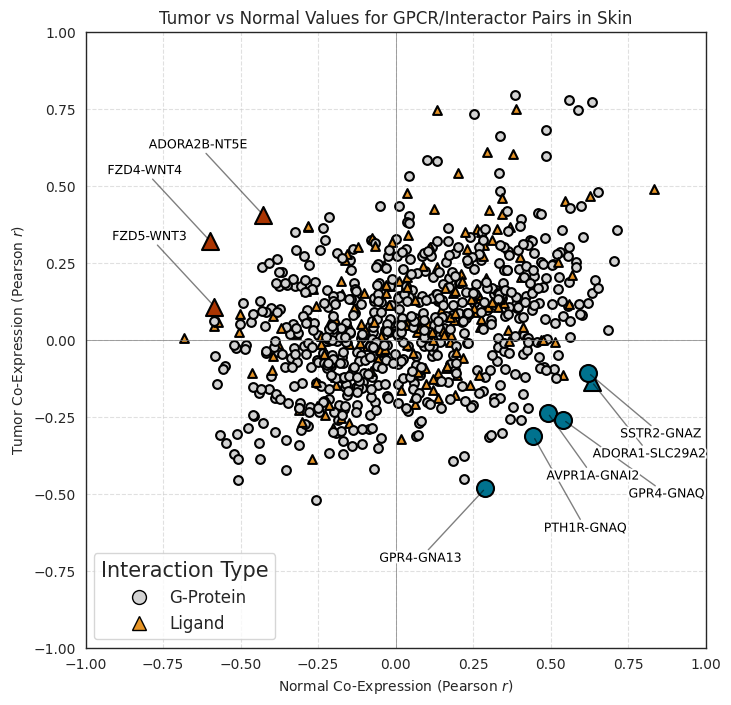

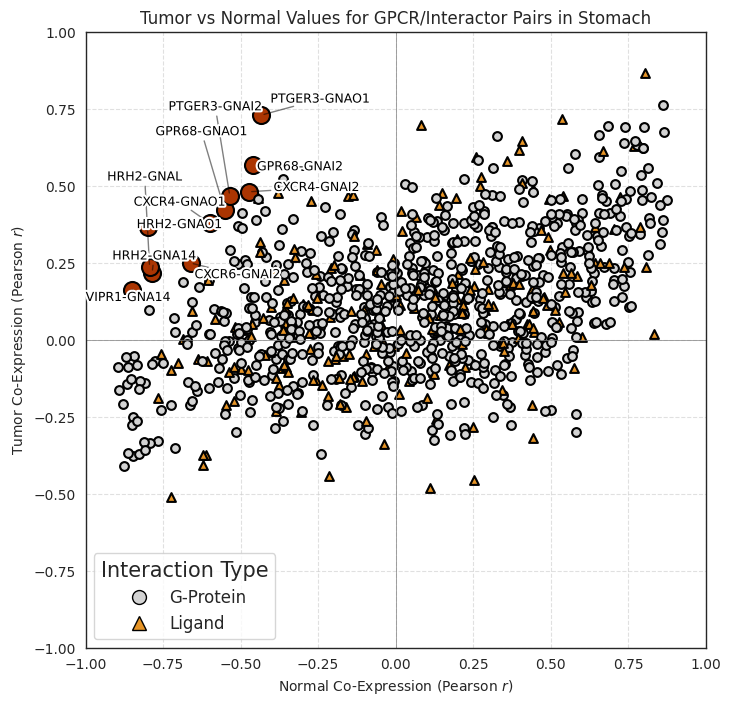

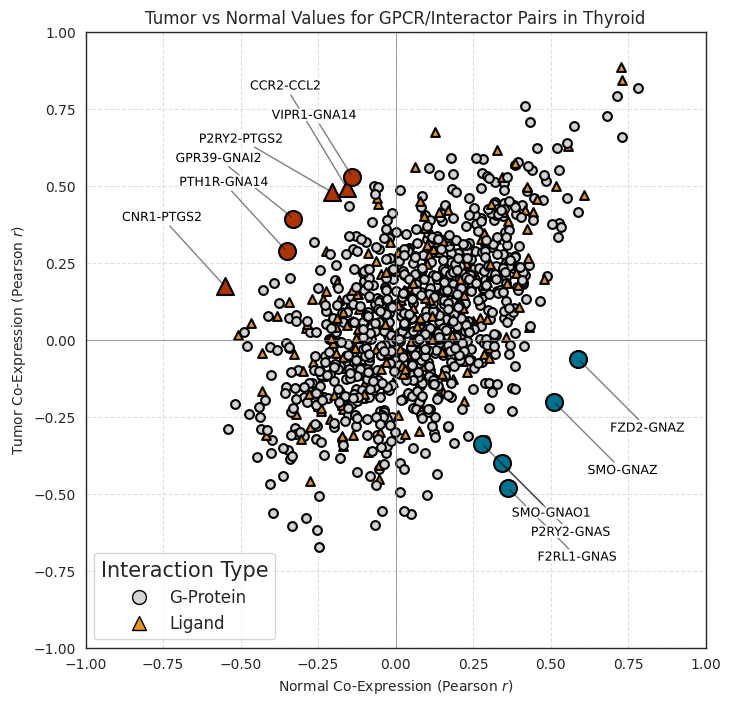

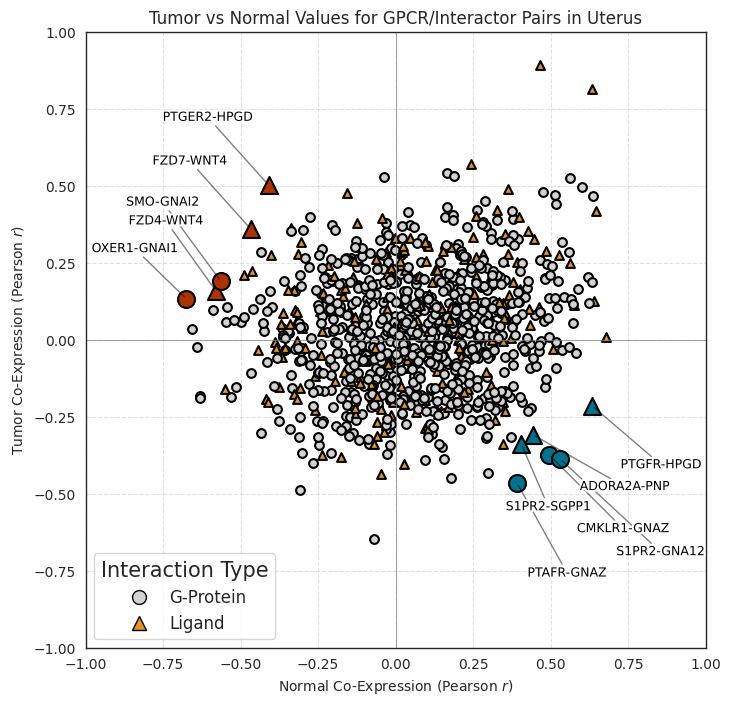

In [106]:
from adjustText import adjust_text  # Install via pip install adjustText if not already installed
import matplotlib.patheffects as path_effects  # Import PathEffects for text outlines

for tissue in results_df.tissue.unique():

    #Pivot the data to get separate columns for "Tumor" and "Normal" values
    pivot_df = df.query('tissue == @tissue').pivot(index=['gpcr', 'interactor', 'interactor_type'], 
                                                  columns='condition', 
                                                  values='value').reset_index()
    pivot_df = pivot_df[pivot_df.isna().sum(1) == 0]

    plt.figure(figsize=(8, 8))

    # Identify points with high tumor/normal difference
    texts = []  # Collect all text labels to adjust them later
    for i, row in pivot_df.iterrows():
        nval = row['Normal Co-Expression']
        tval = row['Tumor Co-Expression']
        shape = '^' if row['interactor_type'] == 'Ligand' else 'o'

        # Highlight top 1% by tumor-normal difference
        threshold = (pivot_df['Normal Co-Expression'] - pivot_df['Tumor Co-Expression']).abs().quantile(0.99) 

        if np.abs(row['Normal Co-Expression'] - row['Tumor Co-Expression']) > threshold:
            # High Diff
            label = f"{row['gpcr']}-{row['interactor']}"
            color = tcolor if tval > nval else ncolor
            size = 150

            text = plt.text(nval , tval, label, fontsize=9, ha='center', va='center', color='black')
            text.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground='white'),  # White outline
                path_effects.Normal()  # Normal text
            ])
            texts.append(text)

        else:
            size=40
            color = orangecolor if row['interactor_type'] == 'Ligand' else 'lightgray'            

        plt.scatter(nval, tval, s=size, alpha=1, linewidth=1.5, edgecolors='k', color=color, marker=shape)

    # Add labels, title, and legend
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Normal Co-Expression (Pearson $r$)')
    plt.ylabel('Tumor Co-Expression (Pearson $r$)')
    plt.title(f'Tumor vs Normal Values for GPCR/Interactor Pairs in {tissue.title()}')
    plt.axhline(0, color='gray', linewidth=0.5)  # Optional: Reference line at y=0
    plt.axvline(0, color='gray', linewidth=0.5)  # Optional: Reference line at x=0
    plt.grid(True, linestyle='--', alpha=0.6)

    handles = [
        Line2D(
            [0], [0], marker='o', color='w', markerfacecolor='lightgray', 
            markeredgecolor='k', markersize=10, label='G-Protein'
        ),
        Line2D(
            [0], [0], marker='^', color='w', markerfacecolor=orangecolor, 
            markeredgecolor='k', markersize=10, label='Ligand'
        ),
    ]

    plt.legend(handles, ['G-Protein', 'Ligand'], loc='lower left', title='Interaction Type', fontsize=fs)

    adjust_text(
            texts,
            x=pivot_df['Normal Co-Expression'],
            y=pivot_df['Tumor Co-Expression'],
            #expand=(5, 5),
            arrowprops=dict(arrowstyle='-', color='k', alpha=0.5),
            #force_points=(10,5),
            force_text=5,
            force_explode=7.5
        )

    plt.show()

In [83]:
pivot_df = df.pivot(
    index=['gpcr', 'interactor', 'interactor_type', 'tissue'],
    columns='condition',
    values='value').reset_index()

In [84]:
pivot_df

condition       gpcr interactor interactor_type            tissue  \
0          ADCYAP1R1    ADCYAP1          Ligand    adipose_tissue   
1          ADCYAP1R1    ADCYAP1          Ligand             brain   
2          ADCYAP1R1    ADCYAP1          Ligand             colon   
3          ADCYAP1R1    ADCYAP1          Ligand         esophagus   
4          ADCYAP1R1    ADCYAP1          Ligand          pancreas   
...              ...        ...             ...               ...   
53054           XCR1       XCL2          Ligand            kidney   
53055           XCR1       XCL2          Ligand  lymphatic_tissue   
53056           XCR1       XCL2          Ligand            spleen   
53057           XCR1       XCL2          Ligand            testis   
53058           XCR1       XCL2          Ligand            thymus   

condition  Coevolution  Normal Co-Expression  Tumor Co-Expression  
0                  NaN             -0.063490                  NaN  
1                  NaN             -0.017183            -0.217429  
2                  NaN              0.386926                  NaN  
3                  NaN              0.043238                  NaN  
4                  NaN             -0.025975             0.303676  
...                ...                   ...                  ...  
53054              NaN                   NaN             0.450008  
53055              NaN                   NaN             0.460388  
53056              NaN              0.450767                  NaN  
53057              NaN                   NaN             0.627036  
53058              NaN                   NaN             0.357128  

[53059 rows x 7 columns]

In [78]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming false_discovery_control is already defined somewhere
# If not, you can define it using a method like FDR or Benjamini-Hochberg.

# Group by GPCR-Interactor pair
grouped = pivot_df.groupby(['gpcr', 'interactor'])

# Perform Mann-Whitney U test for each group
results = []

for (gpcr, interactor), group in grouped:
    normal = group['Normal Co-Expression'].dropna()
    tumor = group['Tumor Co-Expression'].dropna()

    if len(normal) > 5 and len(tumor) > 5:  # Perform test only if both groups have enough values
        _, p_value = mannwhitneyu(normal, tumor, alternative='two-sided')
        normal_median = normal.median()
        tumor_median = tumor.median()
        results.append({
            'gpcr': gpcr,
            'interactor': interactor,
            'p_value': p_value,
            'normal_median': normal_median,
            'tumor_median': tumor_median
        })
    else:
        continue

# Create a DataFrame with results
results_df = pd.DataFrame(results)

# Apply False Discovery Rate (FDR) correction to p-values using your custom false_discovery_control function
results_df['pval_adj'] = false_discovery_control(results_df['p_value'])

# Sort the results by adjusted p-values
results_df = results_df.sort_values(by='pval_adj').reset_index(drop=True)

# Display the results dataframe
results_df


gpcr interactor       p_value  normal_median  tumor_median  pval_adj
0        CCR1       CCL5  1.044450e-09       0.128226      0.607635  0.000001
1        CCR1       CCL3  1.458986e-07       0.192096      0.628011  0.000100
2      CELSR3       DAG1  6.452461e-07      -0.157325      0.185140  0.000249
3       CXCR6      GNAI2  7.230430e-07      -0.058383      0.274918  0.000249
4        CCR5       CCL4  1.656957e-06       0.494955      0.783273  0.000456
...       ...        ...           ...            ...           ...       ...
1370  ADORA2A      GNA15  9.926773e-01       0.196175      0.188903  1.000000
1371     FZD9       WNT3  1.000000e+00       0.077783      0.082784  1.000000
1372     FZD9      WNT2B  1.000000e+00      -0.047987     -0.015543  1.000000
1373    S1PR3      GNA14  1.000000e+00       0.159838      0.188228  1.000000
1374    SSTR3       GNAZ  1.000000e+00       0.158872      0.131295  1.000000

[1375 rows x 6 columns]

In [81]:
normal

53056    0.450767
Name: Normal Co-Expression, dtype: float64

In [179]:
results_df = results_df.query('pval_adj < 0.05')

In [180]:
results_df[results_df.gpcr == 'ADRB2']

gpcr interactor  p_value  normal_median  tumor_median  pval_adj
48  ADRB2       GNAS  0.00084       0.060622     -0.092714  0.019488

In [181]:
results_df[30:80]

gpcr interactor   p_value  normal_median  tumor_median  pval_adj
30    CXCR5      GNA13  0.000155      -0.080796     -0.349724  0.005691
31   TBXA2R     PTGES2  0.000176      -0.068114      0.129277  0.006269
32   LTB4R2      GNAI1  0.000189      -0.177887      0.045127  0.006437
33     HRH1      GNA14  0.000192       0.332875      0.096397  0.006437
34    F2RL3      GNA13  0.000305       0.184525     -0.012230  0.009921
35   PTGER2      PTGDS  0.000315      -0.104386      0.263776  0.009937
36   P2RY13      GNAI2  0.000373      -0.023639      0.320321  0.011151
37   P2RY13     ENTPD1  0.000373       0.070654      0.502672  0.011151
38   ADRA1B      GNA14  0.000383      -0.240540      0.200086  0.011170
39    EDNRB       GNAL  0.000486      -0.043276      0.088425  0.013478
40   ADORA3    SLC29A2  0.000478       0.094359     -0.170287  0.013478
41    S1PR1      GNAI3  0.000518       0.263491     -0.022415  0.014036
42   GABBR1     SLC6A1  0.000602       0.423676      0.150414  0.015928
43   PTGER4      PTGS2  0.000636       0.488317      0.119990  0.016442
44     GPR4      GNAI3  0.000734       0.171180     -0.059989  0.018556
45   PTGER2     PTGES3  0.000776       0.008839     -0.167605  0.019176
46    GPR34      GNAI2  0.000814       0.090836      0.282081  0.019488
47  CYSLTR2    ALOX5AP  0.000832       0.010200      0.308424  0.019488
48    ADRB2       GNAS  0.000840       0.060622     -0.092714  0.019488
49  ADORA2A    SLC29A3  0.000861      -0.016540      0.122140  0.019570
50    S1PR2      GNA12  0.000916       0.320190      0.078848  0.020415
51      SMO      GNA12  0.000949      -0.157381      0.108748  0.020757
52    LPAR2       GNAZ  0.000985      -0.262244      0.051144  0.020822
53     GRM2       GNAZ  0.000989      -0.077976      0.083316  0.020822
54    GPR68      GNAI2  0.001039       0.080945      0.351445  0.021105
55     HRH1      GNAI3  0.001022       0.372565      0.197005  0.021105
56   P2RY14      GNA14  0.001172       0.045711      0.256217  0.023370
57      F2R      GNA12  0.001321       0.045777      0.215078  0.025899
58  CYSLTR2      ALOX5  0.001366       0.077614      0.240337  0.026316
59    S1PR1      GNAO1  0.001403      -0.062515      0.168732  0.026586
60   P2RY11      GNA13  0.001489      -0.151700     -0.296395  0.027315
61    EDNRA      GNA14  0.001474       0.433236      0.182391  0.027315
62    P2RY1      PTGS2  0.001559      -0.046528      0.138854  0.028054
63    S1PR4      GNAO1  0.001579      -0.203563      0.053195  0.028054
64    OPRL1      ARRB2  0.001614       0.276844      0.137278  0.028232
65    CXCR5      GNAI2  0.001779       0.140153      0.311478  0.030653
66     GPR4      GNA13  0.001876       0.267281      0.000533  0.031373
67   PTGER3     PTGES3  0.001869      -0.020129     -0.173816  0.031373
68    LPAR6      GNA13  0.002000       0.211492     -0.009148  0.032651
69    F2RL3       GZMA  0.002010      -0.147352      0.067604  0.032651
70     CCR2      GNAO1  0.002084      -0.099826      0.212140  0.033023
71    EDNRB      GNAI3  0.002120       0.277029     -0.031195  0.033023
72   P2RY11       GNAS  0.002120      -0.138421      0.004884  0.033023
73     GRM2      GNAO1  0.002291       0.068892      0.259967  0.035198
74    CXCR5      ARRB2  0.002380       0.076697      0.242658  0.036077
75    GPR75      GNA15  0.002458       0.069681     -0.135521  0.036772
76  ADORA2B    SLC29A1  0.002564      -0.253837     -0.051119  0.037853
77    OXER1    ALOX5AP  0.002612      -0.244899      0.003548  0.038082
78   PTGER4     PTGES3  0.002824       0.052637     -0.124120  0.040641
79   ADORA3     ENTPD1  0.002869       0.084366      0.342057  0.040775

In [188]:
df.condition.value_counts()

condition
Tumor Co-Expression     33039
Normal Co-Expression    31961
Coevolution              3004
Name: count, dtype: int64

In [113]:
pivot_df.groupby(['gpcr', 'interactor'])

In [102]:
import pandas as pd

# Assuming pivot_df is the DataFrame from your example
pivot_df['difference'] = pivot_df['Tumor Co-Expression'] - pivot_df['Normal Co-Expression']

# Group by (gpcr, interactor) pairs and aggregate the sum of differences
result_df = (
    pivot_df.groupby(['gpcr', 'interactor'])['difference']
    .sum()
    .reset_index()
    .rename(columns={'difference': 'sum_difference'})
)

# Show the result
result_df = result_df.sort_values(by='sum_difference').reset_index(drop=True)


In [109]:
result_df.tail(75)

gpcr interactor  sum_difference
3001    ADRB2      GNAO1        2.480541
3002    P2RY2      GNAO1        2.499641
3003    EDNRA      ARRB1        2.530260
3004    LPAR5      GNA12        2.535859
3005  ADORA2B       NT5E        2.558181
...       ...        ...             ...
3071     FZD4       WNT4        4.467047
3072   CELSR3       DAG1        4.811496
3073  ADORA2A       ADA2        5.990060
3074    VIPR1      GNA14        6.525745
3075     CCR1       CCL5        8.152696

[75 rows x 3 columns]

In [104]:
result_df[result_df['gpcr'] == 'ADRB2']

gpcr interactor  sum_difference
76    ADRB2       GNAS       -1.790426
91    ADRB2      ARRB1       -1.618339
121   ADRB2      GNAI3       -1.410489
362   ADRB2       GNAZ       -0.537456
767   ADRB2       PNMT       -0.054909
1423  ADRB2         TH        0.000000
1535  ADRB2     SLC6A2        0.000000
1554  ADRB2    SLC18A1        0.000000
2283  ADRB2        DBH        0.296297
2406  ADRB2      ARRB2        0.421658
2541  ADRB2    SLC18A2        0.599359
2591  ADRB2      GNAI2        0.710198
2666  ADRB2      GNA14        0.867837
2715  ADRB2       GNAQ        0.993790
2852  ADRB2      GNAI1        1.452937
2907  ADRB2      GNA15        1.773529
2930  ADRB2       GNAL        1.885721
3001  ADRB2      GNAO1        2.480541

<Axes: >

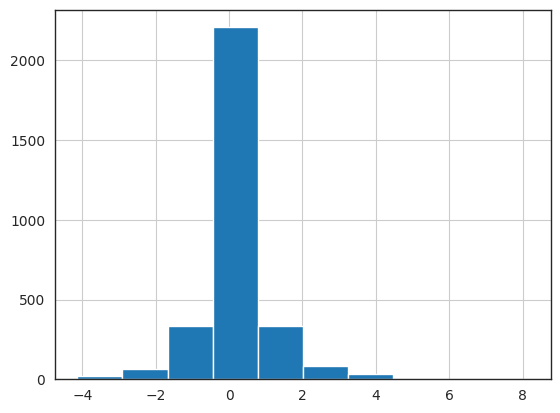

In [106]:
result_df.sum_difference.hist()

# Rewiring

In [22]:
parentdir = '/home/lnemati/pathway_crosstalk/results/flow'
metric = 'kme_corr'

dirs = ['ccc_lr_pairs', 'intact_direct', 'intact_physical', 'intact_association']
tvals = {}
nvals = {}
diff = {}

for int_type in dirs:
    path = os.path.join(parentdir, int_type, f'{metric}', 'interactions_with_scores.csv')
    df = pd.read_csv(path, index_col='interaction')
    tvals[int_type] = df['avg_tumor']
    nvals[int_type] = df['avg_normal']
    diff[int_type] = df['diff']

In [23]:
for k,v in tvals.items():
    print(k)
    print(v.mean())

ccc_lr_pairs
0.11562345070737873
intact_direct
0.08486461369480057
intact_physical
0.03587396901774104
intact_association
0.04511059433700402


In [24]:
for k,v in nvals.items():
    print(k)
    print(v.mean())

ccc_lr_pairs
0.06766398772119601
intact_direct
0.07278145783575592
intact_physical
0.03211198960681704
intact_association
0.04442982987659987


In [38]:
for k, v in diff.items():
    print(k)
    print(v.mean())

ccc_lr_pairs
0.04795946298618271
intact_direct
0.012083155859044629
intact_physical
0.003761979410924006
intact_association
0.0006807644604041642


In [48]:
data = pd.DataFrame(columns=['Value', 'Interaction Type', 'Condition'])

for file in dirs:
    #tvals[file].name = 'Value'
    #ttmp =  tvals[file].to_frame()
    #ttmp['Interaction Type'] = file
    #ttmp['Condition'] = 'Tumor'
    #
    #nvals[file].name = 'Value'
    #ntmp =  nvals[file].to_frame()
    #ntmp['Interaction Type'] = file
    #ntmp['Condition'] = 'Normal'
    
    diff[file].name = 'Value'
    dtmp =  diff[file].to_frame()
    dtmp['Interaction Type'] = file
    dtmp['Condition'] = 'Difference'
    
    #data = pd.concat([data, ttmp])
    #data = pd.concat([data, ntmp])
    data = pd.concat([data, dtmp])
    
#data = data[data.Value != 0]

#tdata = pd.DataFrame([(k, v) for k, vals_list in tvals.items() for v in vals_list], columns=['interaction_type', 'value'])
#tdata['condition'] = 'Tumor'
#ndata = pd.DataFrame([(k, v) for k, vals_list in nvals.items() for v in vals_list], columns=['interaction_type', 'value'])
#ndata['condition'] = 'Normal'

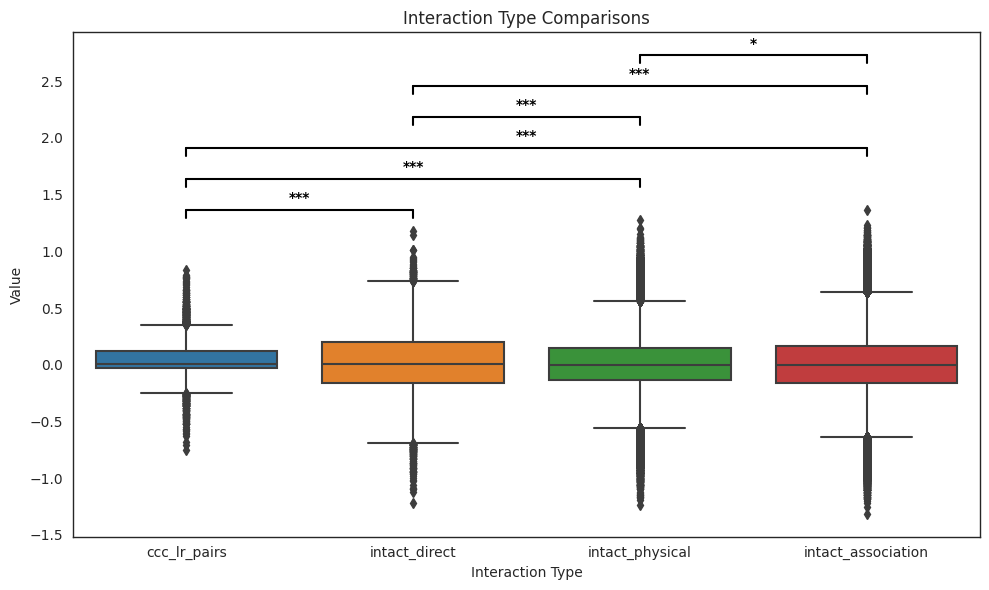

In [51]:
# Generate the violin plot
plt.figure(figsize=(10, 6))
#sns.violinplot(data=data, x='Interaction Type', y='Value', cut=0, inner='quart')
sns.boxplot(data=data, x='Interaction Type', y='Value')
plt.title("Interaction Type Comparisons")
plt.xlabel("Interaction Type")
plt.ylabel("Value")

# Get all unique interaction types
interaction_types = data['Interaction Type'].unique()
comparisons = list(combinations(interaction_types, 2))

# Perform pairwise Mann-Whitney U tests and store the p-values
p_values = []
comparison_pairs = []
stats = []
for (type1, type2) in comparisons:
    values1 = data[data['Interaction Type'] == type1]['Value']
    values2 = data[data['Interaction Type'] == type2]['Value']
    stat, p = mannwhitneyu(values1, values2)
    stats.append(stat / (len(values1) * len(values2)))
    p_values.append(p)
    comparison_pairs.append((type1, type2))

# Apply false discovery control to adjust the p-values
p_values_adj = false_discovery_control(np.array(p_values))

# Add significance bars for pairs with significant adjusted p-values
y_max = data['Value'].max()  # Get the max y-value for bar placement
y_step = 0.2 * y_max  # Increment for each successive bar

for i, ((type1, type2), p_adj) in enumerate(zip(comparison_pairs, p_values_adj)):
    if p_adj < 0.05:  # Only add bars for significant comparisons
        x1, x2 = np.where(interaction_types == type1)[0][0], np.where(interaction_types == type2)[0][0]
        y = y_max + y_step * i  # Position of the bar
        
        # Plot the horizontal bar and add vertical segments
        plt.plot([x1, x2], [y, y], color='black')
        plt.plot([x1, x1], [y - 0.05 * y_max, y], color='black')
        plt.plot([x2, x2], [y - 0.05 * y_max, y], color='black')

        # Add the appropriate number of stars for significance
        num_stars = '*' * (1 + (p_adj < 0.01) + (p_adj < 0.001))
        plt.text((x1 + x2) / 2, y + 0.05 * y_max, num_stars, ha='center', color='black', weight='bold')

plt.tight_layout()
plt.show()


In [320]:
stats

[0.5322436088807986,
 0.5526712731094205,
 0.5527652039671487,
 0.5130218802809767,
 0.5147029340428649,
 0.5021658712407585]

In [316]:
comparison_pairs

[('ccc_lr_pairs', 'intact_direct'),
 ('ccc_lr_pairs', 'intact_physical'),
 ('ccc_lr_pairs', 'intact_association'),
 ('intact_direct', 'intact_physical'),
 ('intact_direct', 'intact_association'),
 ('intact_physical', 'intact_association')]

In [317]:
p_values_adj

array([3.18413519e-08, 1.21375146e-27, 5.79486636e-28, 1.08104247e-04,
       9.41811249e-06, 3.22909400e-02])

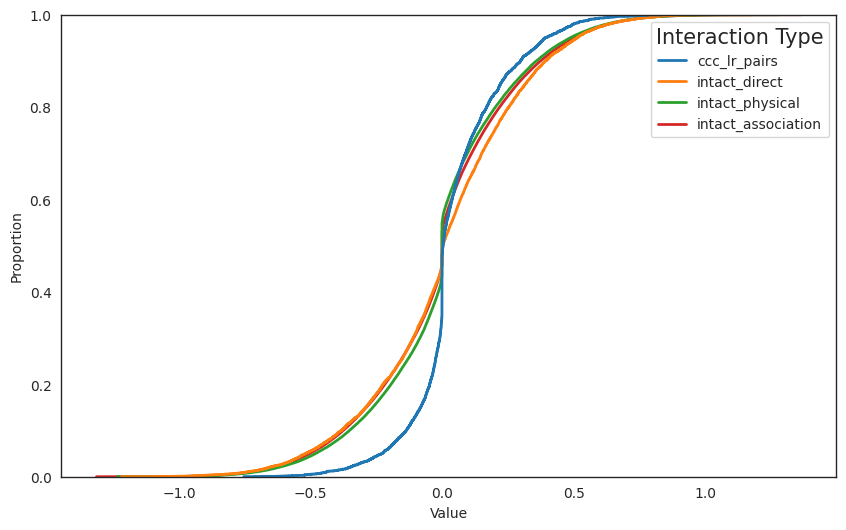

In [66]:
plt.figure(figsize=(10, 6))
#sns.violinplot(data=data, x='Interaction Type', y='Value', hue='Condition', split=True, cut=0)
sns.ecdfplot(data=data.reset_index(), x='Value', hue='Interaction Type', linewidth=2)
plt.title("")
plt.show()

In [62]:
xx = data[data['Interaction Type'] == "ccc_lr_pairs"].Value
yy = data[data['Interaction Type'] == "intact_direct"].Value

In [63]:
result = mannwhitneyu(xx, yy)
auroc = result.statistic / (xx.shape[0] * yy.shape[0])
auroc

0.5322436088807986

# Bootstrap

In [38]:
bootstrap =  pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_all.csv', index_col=0)
N_btsp = bootstrap['n_genes'].value_counts()

bootstrap = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_scores.csv', index_col=0)

In [39]:
interactions = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/interactions_with_counts.csv', index_col=0)
interactions['n_genes'] = interactions.index.str.count('[_+]') + 1
interactions = interactions.query('n_genes > 1')

In [40]:
interactions['pvals'] = np.nan

for n in interactions['n_genes'].unique():    

    N_samples = N_btsp.loc[n]
    
    ints = interactions[interactions['n_genes'] == n]
    btsp = bootstrap[bootstrap['n_genes'] == n]
    
    ints = ints.tumor_score - ints.normal_score
    btsp = btsp.tumor_score - btsp.normal_score

    pvals = ints.apply(lambda x: sum(btsp >= x) / N_samples)
    pvals.loc[:] = false_discovery_control(pvals)
    
    interactions.loc[pvals.index, 'pvals'] = pvals

interactions = interactions.sort_values(by='pvals')

In [45]:
for x in interactions[interactions['pvals'] < 0.05].index:
    print(x)

CSF1_CSF1R
ALOX5+ALOX5AP+LTC4S_CYSLTR2
IL15_IL15RA+IL2RB+IL2RG


In [282]:
interactions.query('pvals < 0.05')

both_score  normal_score  tumor_score  n_genes   pvals
interaction                                                                   
ADM_CALCRL                     0.0      7.397436     0.333333        2  0.0000
ADM_CALCRL+GPER1+RAMP3         0.0      3.076923     0.000000        4  0.0172

In [220]:
interactions.loc['CSF1_CSF1R']

both_score      0.000000
normal_score    0.000000
tumor_score     9.666667
n_genes         2.000000
pvals           0.000000
Name: CSF1_CSF1R, dtype: float64

In [54]:
fake_interactions = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_scores.csv', index_col=0)
fake_interactions = fake_interactions.set_index('all_genes')

In [57]:
(fake_interactions.tumor_score - fake_interactions.normal_score).head(20)

all_genes
['HLA-E', 'TYROBP']             9.435897
['CXCL9', 'PTGER4']             8.666667
['CXCL9', 'TREM2', 'TYROBP']    8.500000
['C3', 'CD28']                  8.333333
['HLA-E', 'HCST', 'KLRK1']      8.166667
['SPN', 'P2RY13']               7.871795
['PLA2G7', 'LILRB1']            7.782051
['CCL2', 'CD28']                7.666667
['DPEP2', 'TREM2', 'TYROBP']    7.435897
['PLA2G7', 'CD8B']              7.256410
['HLA-DMB', 'TNFRSF1B']         7.115385
['CXCL10', 'CD8A']              7.000000
['HLA-DQA1', 'CD28']            6.833333
['CXCL9', 'FPR3']               6.833333
['CCL8', 'FPR1']                6.833333
['CXCL8', 'IL1RAP']             6.679487
['ALDH1A3', 'CD28']             6.500000
['HLA-C', 'CXCR3']              6.333333
['HLA-DPB1', 'CCR5']            6.256410
['NTN1', 'NRCAM']               6.179487
dtype: float64

In [ ]:
sum(np.abs(btsp) > np.abs(7)) / N_samples)

<Axes: >

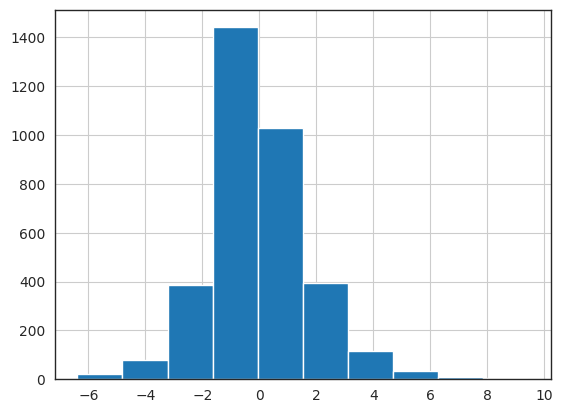

In [183]:
btsp.hist()

In [161]:
interactions[:20]

both_score  normal_score  tumor_score  n_genes  \
interaction                                                               
CSF1_CSF1R                 0.000000      0.000000     9.666667        2   
IL15_IL15RA+IL2RB+IL2RG    0.076923      0.500000     6.756410        4   
ADM_CALCRL+GPER1+RAMP3     0.000000      3.076923     0.000000        4   
HLA-E_CD8B                 0.500000      0.076923     7.833333        2   
CXCL9_CXCR3                1.000000      0.000000     7.666667        2   
CXCL10_CXCR3               0.000000      0.000000     7.666667        2   
HLA-DQB1_CD4               3.000000      0.115385     7.500000        2   
HLA-E_CD8A                 0.653846      0.500000     9.512821        2   
CD86_CD28                  0.000000      0.000000     7.333333        2   
PLA2G7_PTAFR               0.307692      1.000000     9.358974        2   
ITGB2_CD226                0.307692      0.000000     8.192308        2   
HLA-DQA1_CD4               4.000000      0.038462     8.500000        2   
HLA-E_KLRK1                1.500000      0.307692     8.166667        2   
CCL3_CCR1                  0.076923      0.000000     8.256410        2   
ENTPD1_ADORA3              0.461538      0.000000     7.371795        2   
ICAM1_SPN                  0.000000      0.000000     7.333333        2   
HLA-DQA2_CD4               0.000000      0.000000     6.833333        2   
SELPLG_SELL                4.141026      0.333333     7.525641        2   
ACE2_AGTR1                 0.000000      6.833333     0.000000        2   
CCL5_CCR5                  3.000000      1.000000     7.833333        2   

                            pvals  
interaction                        
CSF1_CSF1R               0.000000  
IL15_IL15RA+IL2RB+IL2RG  0.000000  
ADM_CALCRL+GPER1+RAMP3   0.017200  
HLA-E_CD8B               0.119143  
CXCL9_CXCR3              0.119143  
CXCL10_CXCR3             0.119143  
HLA-DQB1_CD4             0.119143  
HLA-E_CD8A               0.119143  
CD86_CD28                0.119143  
PLA2G7_PTAFR             0.119143  
ITGB2_CD226              0.119143  
HLA-DQA1_CD4             0.119143  
HLA-E_KLRK1              0.119143  
CCL3_CCR1                0.119143  
ENTPD1_ADORA3            0.119143  
ICAM1_SPN                0.119143  
HLA-DQA2_CD4             0.125100  
SELPLG_SELL              0.125100  
ACE2_AGTR1               0.125100  
CCL5_CCR5                0.125100

In [38]:
df['diff']

interaction
CSF1_CSF1R      0.000000
HLA-E_CD8A      0.000285
HLA-DQA1_CD4    0.000569
PLA2G7_PTAFR    0.000569
CCL3_CCR1       0.000854
                  ...   
THY1_ADGRE5     0.010817
TENM4_ADGRL1    0.009678
PTPRS_NTRK3     0.006832
ACE2_AGTR1      0.002562
ADM_CALCRL      0.002277
Name: diff, Length: 2853, dtype: float64

In [33]:
bootstrap['diff'].std()

1.7498524273792933

# Flow

In [59]:
flow = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/interactions_with_counts.csv', index_col='interaction')

In [60]:
normal = flow.normal_score.sum()
tumor = flow.tumor_score.sum()
both = flow.both_score.sum()

In [64]:
flow.idxmax(axis=1).value_counts()

normal_score    1602
tumor_score     1100
both_score       151
dtype: int64

In [66]:
int_normal, int_tumor, int_both = flow.idxmax(axis=1).value_counts().values

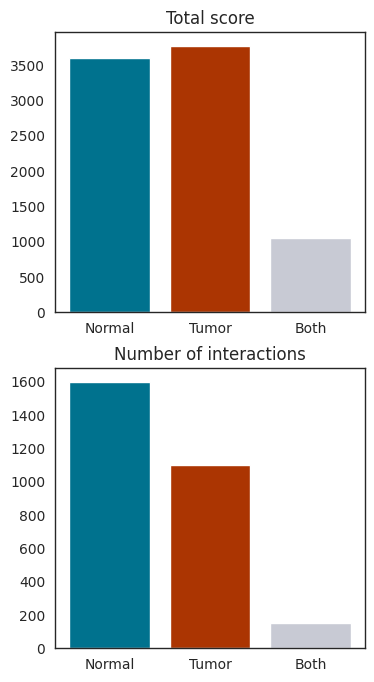

In [80]:


# Creating the bar plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4, 8))

categories = ['Normal', 'Tumor', 'Both']
scores = [normal, tumor, both]
colors = [ncolor, tcolor, '#C8CAD4']
ax1.bar(categories, scores, color=colors)
ax1.set_title('Total score')


categories = ['Normal', 'Tumor', 'Both']
interactions = [int_normal, int_tumor, int_both]
colors = [ncolor, tcolor, '#C8CAD4']
ax2.bar(categories, interactions, color=colors)
ax2.set_title('Number of interactions')

# Show plot
plt.show()

fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/flow/flow_summary.pdf', bbox_inches='tight')


# Multiple Interactions

In [19]:
import igraph as ig
from scipy.sparse import csr_matrix

In [47]:
tc = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_coocs.csv', index_col=0)
to = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_occs.csv', index_col=0)
tj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_jaccard.csv', index_col=0)

nc = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_coocs.csv', index_col=0)
no = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_occs.csv', index_col=0)
nj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_jaccard.csv', index_col=0)

np.fill_diagonal(tc.values, 0)
t_occs = pd.Series(np.diag(to), index=to.index)
n_occs = pd.Series(np.diag(no), index=no.index)
n = 3
t_keep = t_occs[(t_occs >= n)].index
n_keep = n_occs[(n_occs >= n)].index
keep = t_keep.intersection(n_keep)

tc = tc.loc[keep, keep]
to = to.loc[keep, keep]
tj = tj.loc[keep, keep]

nc = nc.loc[keep, keep]
no = no.loc[keep, keep]
nj = nj.loc[keep, keep]

In [48]:
diff = tj - nj

In [49]:
diff = stack_triangle(tj - nj, 'jaccard_difference').sort_values(by='jaccard_difference', ascending=False)
tj = stack_triangle(tj, 'j')
nj = stack_triangle(nj, 'j')

tc = stack_triangle(tc, 'c')
to = stack_triangle(to, 'o')

nc = stack_triangle(nc, 'c')
no = stack_triangle(no, 'o')

In [50]:
diff['tumor_jaccard'] = tj.loc[diff.index]
diff['normal_jaccard'] = nj.loc[diff.index]

diff['tumor_tot_occurrences'] = to.loc[diff.index]
diff['normal_tot_occurrences'] = no.loc[diff.index]

diff['tumor_cooccurrences'] = tc.loc[diff.index]
diff['normal_cooccurrences'] = nc.loc[diff.index]

In [52]:
diff

jaccard_difference  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                 1.0   
                   ALDH1A2_CRABP2+RARA                      1.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                 1.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                 1.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                 1.0   
...                                                         ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                        -1.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                       -1.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                        -1.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                         -1.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                         -1.0   

                                             tumor_jaccard  normal_jaccard  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA            1.0             0.0   
                   ALDH1A2_CRABP2+RARA                 1.0             0.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                            1.0             0.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                            1.0             0.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                            1.0             0.0   
...                                                    ...             ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                    0.0             1.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                   0.0             1.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                    0.0             1.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                     0.0             1.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                     0.0             1.0   

                                             tumor_tot_occurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                    3.0   
                   ALDH1A2_CRABP2+RARA                         3.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                    4.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                    4.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                    4.0   
...                                                            ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                            9.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                           8.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                            9.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                             6.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                             7.0   

                                             normal_tot_occurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                    12.0   
                   ALDH1A2_CRABP2+RARA                         13.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                    10.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                    10.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                    10.0   
...                                                             ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                             3.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                            3.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                             3.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                              3.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                              3.0   

                                             tumor_cooccurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                  3.0   
                   ALDH1A2_CRABP2+RARA                       3.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                  4.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                  4.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                  4.0   
...                                                          ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                          0.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                         0.0 

In [53]:
diff.to_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/pairs_of_interactions_unfiltered.csv')

In [ ]:
t_counts = diff[diff['diff'] > 0].index.get_level_values(0).value_counts()
t_counts = t_counts.add(diff[diff['diff'] > 0].index.get_level_values(1).value_counts())

In [ ]:
tj.sort_values(by='j', ascending=False, inplace=True)
tn.sort_values(by='j', ascending=False, inplace=True)

In [222]:
n = round(0.05 * len(tj))
wnt1 = tj.iloc[:n].index.get_level_values(0).str.contains('WNT')
wnt2 = tj.iloc[:n].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.0691556576680069

In [224]:
wnt1 = tj.iloc[:].index.get_level_values(0).str.contains('WNT')
wnt2 = tj.iloc[:].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.013931848533149528

In [230]:
n = round(0.05 * len(nj))
wnt1 = nj.iloc[:n].index.get_level_values(0).str.contains('WNT')
wnt2 = nj.iloc[:n].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.10562894887995405

In [231]:
wnt1 = nj.iloc[:].index.get_level_values(0).str.contains('WNT')
wnt2 = nj.iloc[:].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.013931848533149528

In [201]:
#diff.loc[('CSF1_CSF1R', 'CD274_PDCD1')]
tj.loc[('CD274_PDCD1', 'CSF1_CSF1R')]

j    0.333333
Name: (CD274_PDCD1, CSF1_CSF1R), dtype: float64

In [203]:
nj.loc[('CD274_PDCD1', 'CSF1_CSF1R')]

j    0.0
Name: (CD274_PDCD1, CSF1_CSF1R), dtype: float64

In [ ]:
1+1

# Coevolution - Tumor

In [12]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [13]:
import re
import pandas as pd

def extract_mutation_info(mutation_string, allowed_strings=None):
    # Return empty lists if the input string is missing or empty
    if pd.isna(mutation_string) or mutation_string == '':
        return [], [], []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')
    
    if allowed_strings is None:
        filtered_entries = [entry for entry in gene_entries]
    else:
    # Filter entries that have allowed patterns and contain a closing parenthesis
        filtered_entries = [entry for entry in gene_entries if any([x in entry for x in allowed_strings]) and ')' in entry]

    # Initialize lists to store genes, mutations, and samples
    genes = []
    mutations = []
    samples = []

    # Process each filtered entry
    for entry in filtered_entries:
        # Get gene: Keep only the text before the first set of parentheses
        gene = re.sub(r'\s*\(.*$', '', entry).strip()

        # Get mutation: Extract the content inside the parentheses
        mutation_match = re.search(r'\(([^()]*)\)', entry)
        mutation = mutation_match.group(1).strip() if mutation_match else ''

        # Get sample: Keep only the text after the first set of parentheses
        sample_match = re.search(r'\(.*?\)\s*([- ]*)(.*)', entry)
        sample = sample_match.group(2).strip('- ').strip() if sample_match else ''

        # Append the parsed components to respective lists
        genes.append(gene)
        mutations.append(mutation)
        samples.append(sample)

    # Return the lists of genes, mutations, and samples
    return genes, mutations, samples


In [14]:
dfs = []

for col in ['Trunk_mutation', 'Branch_mutation', 'Private_mutation']:
    # Separate individual mutations
    # Use regex to split only on commas that are not inside parentheses
    vals = df_complete[col].str.split(r',\s*(?![^(]*\))', expand=True)
    
    # Find nans
    keep = ~vals.isna()
    
    # Add sample ids
    samples = df_complete['Sample']
    samples.index = samples.values
    vals.index = samples.values
    vals = (vals.T.astype(str) + samples).T
    
    # Remove nans
    vals = vals.values[keep]

    allowed_strings = ['(p.', '(amp', '(del']
    #allowed_strings = None
    
    genes, mutations, samples = extract_mutation_info(", ".join(vals), allowed_strings = allowed_strings)
    
    #genes     = [get_gene(x)     for x in vals]
    #mutations = [get_mutation(x) for x in vals]
    #samples   = [get_sample(x)   for x in vals]
    
    df = pd.DataFrame()
    df.index = genes
    df['mutation'] = mutations
    df['patient'] = samples
    df['when'] = col.strip('_mutation')
    
    dfs.append(df)
    
df = pd.concat(dfs)
#df['when'] = df['when'].map({'Trunk': 'Trunk', 'Private': 'Branch/Private', 'Branch': 'Branch/Private'})
df['gene'] = df.index

df = df[~df.index.isin(['', ' ', '-'])]
df = df[~df['patient'].isin(['', ' ', '-'])]
df = df[~df['gene'].isin(['', ' ', '-'])]


In [15]:
cosmic = pd.read_csv('/projects/bioinformatics/DB/COSMIC/Census_2024.tsv', sep='\t')
cosmic = set(cosmic['Gene Symbol'].unique())

In [16]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv')
lr_pairs = lr.apply(lambda x: [x.ligand, x.receptor], axis=1)
lr = set(lr['ligand']).union(lr['receptor'])

In [17]:
# LR pairs where at least one gene is in cosmic
# I don't know how to use these yet

#cosmic_lr_pairs = lr_pairs[lr_pairs.apply(lambda x: any([gene in cosmic for gene in x]))].reset_index(drop=True)
#cosmic_lr_pairs

In [18]:
df['cosmic'] = False
df['ccc'] = False

df.loc[df.gene.isin(cosmic), 'cosmic'] = True
df.loc[df.gene.isin(lr), 'ccc'] = True

In [19]:
df = df[df.cosmic]

In [20]:
df.index = (df['patient'] + '_' + df['gene'])
df['unique_id'] = (df['patient'] + '_' + df['gene'])

In [21]:
counts = df.groupby(['unique_id', 'when']).size().reset_index(name='count')
counts = counts.sort_values(by='count', ascending=False)
counts['patient'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[:-1]))
counts['gene'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[-1:]))

counts['ccc'] = False
counts.loc[counts.gene.isin(lr), 'ccc'] = True

In [22]:
#total = counts.groupby('unique_id')['count'].sum()

In [23]:
genes = counts.groupby(['gene', 'when'])['count'].sum().to_frame()

In [24]:
genes['gene'] = genes.index.get_level_values(0)
genes['when'] = genes.index.get_level_values(1)
genes.index = range(len(genes))

In [25]:
# Group by 'gene' and calculate the total counts for each gene
total_counts = genes.groupby('gene')['count'].sum()

# Sort genes by total count in descending order
genes = genes.set_index('gene').loc[total_counts.sort_values(ascending=False).index].reset_index()

In [26]:
# Init df for test results
results = pd.DataFrame(columns=['auroc', 'pval'])

genes_pivot = genes.pivot(index='gene', columns='when', values='count').fillna(0)
genes_pivot = genes_pivot.loc[total_counts.sort_values(ascending=False).index]

genes_pivot_ccc = genes_pivot.loc[genes_pivot.index.isin(lr)]
genes_pivot_not_ccc = genes_pivot.loc[~genes_pivot.index.isin(lr)]

# Calculate log10 of Total values for CCC and Other Genes
total_ccc_log10 = np.log10(genes_pivot_ccc.sum(axis=1))
total_not_ccc_log10 = np.log10(genes_pivot_not_ccc.sum(axis=1))

# Perform Mann-Whitney U test on log10 transformed Total values
result = mannwhitneyu(total_ccc_log10, total_not_ccc_log10)

# Store AUROC and p-value for log10 Total
results.loc['log10 Total', 'auroc'] = result.statistic / (total_ccc_log10.shape[0] * total_not_ccc_log10.shape[0])
results.loc['log10 Total', 'pval'] = result.pvalue

# Normalize Trunk, Branch, and Private by Total for CCC and Other Genes
genes_ccc_norm = genes_pivot_ccc.T.div(genes_pivot_ccc.sum(axis=1)).T
genes_not_ccc_norm = genes_pivot_not_ccc.T.div(genes_pivot_not_ccc.sum(axis=1)).T

# Perform comparisons for Trunk, Branch, and Private
for col in genes_pivot.columns:
    result = mannwhitneyu(genes_ccc_norm[col], genes_not_ccc_norm[col])
    results.loc[col, 'auroc'] = result.statistic / (genes_ccc_norm.shape[0] * genes_not_ccc_norm.shape[0])
    results.loc[col, 'pval'] = result.pvalue
    
# Apply multiple testing correction
results['pval_adj'] = false_discovery_control(results.pval.astype(float).values)

results = results.loc[['log10 Total', 'Trunk', 'Branch', 'Private']]
#results.to_csv('/home/lnemati/pathway_crosstalk/results/coevolution/cosmic/test_results.csv')

In [27]:
(10**total_ccc_log10).sort_values().head(5)

gene
ACVR1B      1.0
PDCD1LG2    1.0
TNFRSF17    1.0
OMD         1.0
RSPO3       2.0
dtype: float64

In [28]:
total_ccc_log10.index

Index(['EGFR', 'NOTCH1', 'NOTCH2', 'ALK', 'PDGFRA', 'MET', 'ERBB4', 'PTPRD',
       'ERBB2', 'CNTNAP2', 'HLA-A', 'PTCH1', 'FLT4', 'EPHA3', 'DCC', 'TNC',
       'AR', 'KDR', 'GRM3', 'BCR', 'SIRPA', 'ERBB3', 'HGF', 'GRIN2A', 'CDH1',
       'COL3A1', 'FLT3', 'NTRK3', 'IL7R', 'EPHA7', 'RET', 'FGFR3', 'CSF1R',
       'KIT', 'PTPRC', 'COL2A1', 'ROBO2', 'PDGFRB', 'ACVR2A', 'NRG1', 'ESR1',
       'FGFR1', 'FGFR4', 'LIFR', 'COL1A1', 'FGFR2', 'MPL', 'CDH11', 'TSHR',
       'CD209', 'ACKR3', 'CSF3R', 'TNFRSF14', 'SFRP4', 'ACVR1', 'NTRK2',
       'TFRC', 'TGFBR2', 'RARA', 'EZR', 'NTRK1', 'IL21R', 'RXRA', 'CXCR4',
       'ACSL6', 'SDC4', 'IL6ST', 'ITGAV', 'PPARG', 'CD274', 'BMP5', 'SMO',
       'CCR4', 'WIF1', 'CCR7', 'IL2', 'RSPO3', 'FAS', 'PDGFB', 'BMPR1A',
       'GPC3', 'CD28', 'CD74', 'B2M', 'LCK', 'CRLF2', 'RSPO2', 'CYSLTR2',
       'OMD', 'TNFRSF17', 'PDCD1LG2', 'ACVR1B'],
      dtype='object', name='gene')

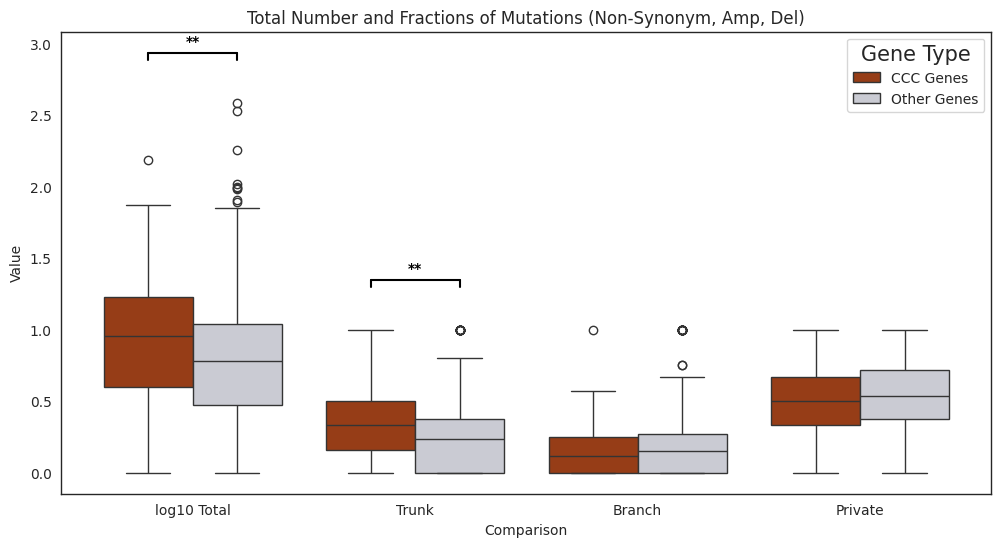

In [29]:
# Boxplots

# Melt data for plotting
data = pd.DataFrame({
    'Comparison': (['log10 Total'] * len(total_ccc_log10) + ['log10 Total'] * len(total_not_ccc_log10) +
                   ['Trunk'] * len(genes_ccc_norm['Trunk']) + ['Trunk'] * len(genes_not_ccc_norm['Trunk']) +
                   ['Branch'] * len(genes_ccc_norm['Branch']) + ['Branch'] * len(genes_not_ccc_norm['Branch']) +
                   ['Private'] * len(genes_ccc_norm['Private']) + ['Private'] * len(genes_not_ccc_norm['Private'])),
    'Gene Type': (['CCC Genes'] * len(total_ccc_log10) + ['Other Genes'] * len(total_not_ccc_log10) +
                  ['CCC Genes'] * len(genes_ccc_norm['Trunk']) + ['Other Genes'] * len(genes_not_ccc_norm['Trunk']) +
                  ['CCC Genes'] * len(genes_ccc_norm['Branch']) + ['Other Genes'] * len(genes_not_ccc_norm['Branch']) +
                  ['CCC Genes'] * len(genes_ccc_norm['Private']) + ['Other Genes'] * len(genes_not_ccc_norm['Private'])),
    'Value': np.concatenate([total_ccc_log10, total_not_ccc_log10,
                             genes_ccc_norm['Trunk'], genes_not_ccc_norm['Trunk'],
                             genes_ccc_norm['Branch'], genes_not_ccc_norm['Branch'],
                             genes_ccc_norm['Private'], genes_not_ccc_norm['Private']])
})

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Comparison', y='Value', hue='Gene Type', data=data, palette={'CCC Genes': tcolor, 'Other Genes': lightgray})
plt.title('Total Number and Fractions of Mutations (Non-Synonym, Amp, Del)')
plt.xlabel("Comparison")
plt.ylabel("Value")

# Add significance bars
for i, (comparison, row) in enumerate(results.iterrows()):
    if row['pval_adj'] < 0.05:
        y = data[data['Comparison'] == comparison]['Value'].max() + 0.35
        plt.plot([i - 0.2, i + 0.2], [y, y], color='black')  # Horizontal line

        # Vertical segments
        plt.plot([i - 0.2, i - 0.2], [y - 0.05, y], color='black')
        plt.plot([i + 0.2, i + 0.2], [y - 0.05, y], color='black')
        
        # Significance stars
        plt.text(i, y + 0.05, '*' * (1 + (row['pval_adj'] < 0.01) + (row['pval_adj'] < 0.001)),
                 ha='center', color='black', weight='bold')

# Final adjustments
plt.legend(title='Gene Type')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/coevolution/cosmic/boxplots.pdf', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/coevolution/cosmic/boxplots.png', bbox_inches='tight')

plt.show()

In [216]:
ccc_time_avg = (genes_pivot_ccc['Branch'] - genes_pivot_ccc['Trunk'])

In [217]:
not_ccc_time_avg = (genes_pivot_not_ccc['Branch'] - genes_pivot_not_ccc['Trunk'])

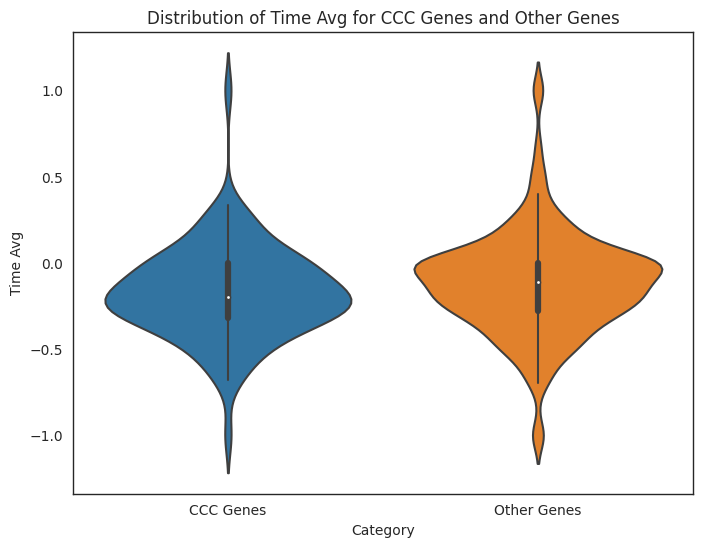

In [209]:
data = pd.DataFrame({
    'Time Avg': pd.concat([ccc_time_avg, not_ccc_time_avg]),
    'Category': ['CCC Genes'] * len(ccc_time_avg) + ['Other Genes'] * len(not_ccc_time_avg)
})

# Plot using Seaborn violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Category', y='Time Avg', data=data, split=True)
plt.title('Distribution of Time Avg for CCC Genes and Other Genes')
plt.show()


In [210]:
mannwhitneyu(not_ccc_time_avg, ccc_time_avg, )

MannwhitneyuResult(statistic=30453.5, pvalue=0.03915108061020947)

<Figure size 1000x600 with 0 Axes>

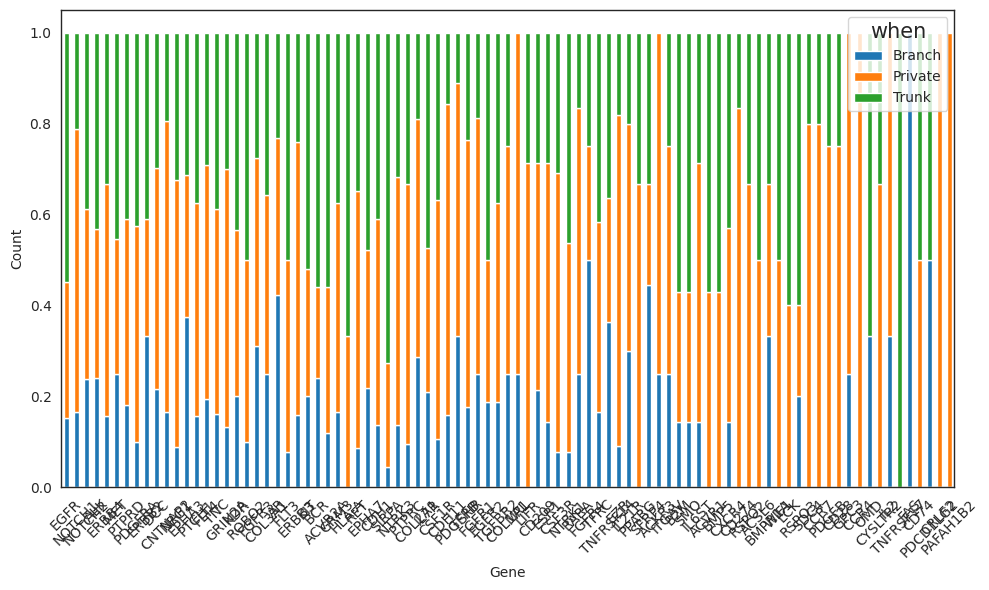

In [188]:
# Plotting
plt.figure(figsize=(10, 6))
# Plotting

genes_pivot_ccc.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel("Gene")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [109]:
# Pivot the DataFrame to have 'when' as x-axis values, 'unique_id' as columns
pivot_df = counts.pivot(index='when', columns='unique_id', values='count').fillna(0)

# Reorder
order = ['Trunk', 'Branch', 'Private',]
pivot_df = pivot_df.loc[order].T

# Make cumulative by summing mutations of previous stages
#pivot_df['Trunk']    = pivot_df['Trunk' ]
#pivot_df['Branch']   = pivot_df['Trunk' ] + pivot_df['Branch' ]
#pivot_df['Private']  = pivot_df['Branch'] + pivot_df['Private'] # Not summing trunk as it's alredy in private

In [110]:
pivot_df['time_avg'] = (pivot_df['Private'] - pivot_df['Trunk']) / (pivot_df['Private'] + pivot_df['Branch'] + pivot_df['Trunk'])

In [111]:
pivot_df['Trunk']   = pivot_df['Trunk'].div(total, fill_value=0)
pivot_df['Branch']  = pivot_df['Branch'].div(total, fill_value=0)
pivot_df['Private'] = pivot_df['Private'].div(total, fill_value=0)

In [112]:
is_lr = pd.Series(pivot_df.index).str.split('_').apply(lambda x: x[-1] in lr).values
pivot_df['is_lr'] = is_lr

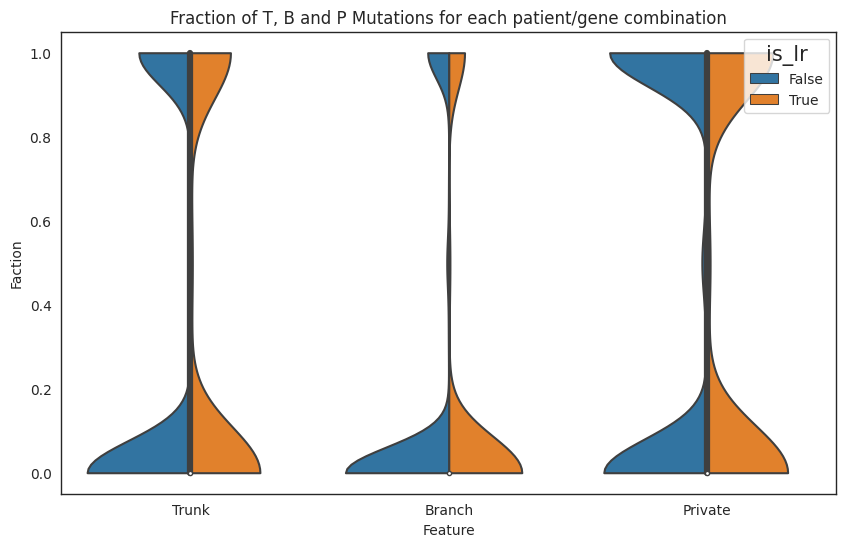

In [113]:
df_melted = pd.melt(pivot_df.reset_index(), id_vars=['unique_id', 'is_lr'], value_vars=['Trunk', 'Branch', 'Private'], 
                    var_name='Feature', value_name='Value')

#df_melted['Value'] = np.log10(0.001 + df_melted['Value'])

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=df_melted, cut=0, split=True)

# Set labels and title
plt.xlabel('Feature')
plt.ylabel('Faction')
plt.title('Fraction of T, B and P Mutations for each patient/gene combination')
plt.show()

Text(0.5, 1.0, 'Time average of mutations')

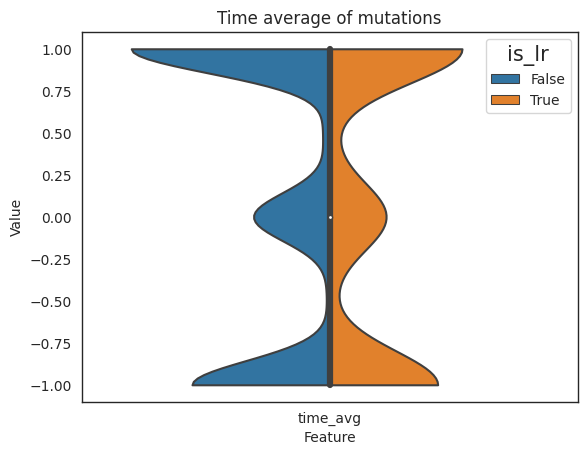

In [114]:
df_melted = pd.melt(pivot_df.reset_index(), id_vars=['unique_id', 'is_lr'], value_vars=['time_avg'], 
                    var_name='Feature', value_name='Value')
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=df_melted, cut=0, split=True)
plt.title('Time average of mutations')

<Axes: title={'center': 'Time average of mutations (after summing all counts for each gene)'}, xlabel='Feature', ylabel='Value'>

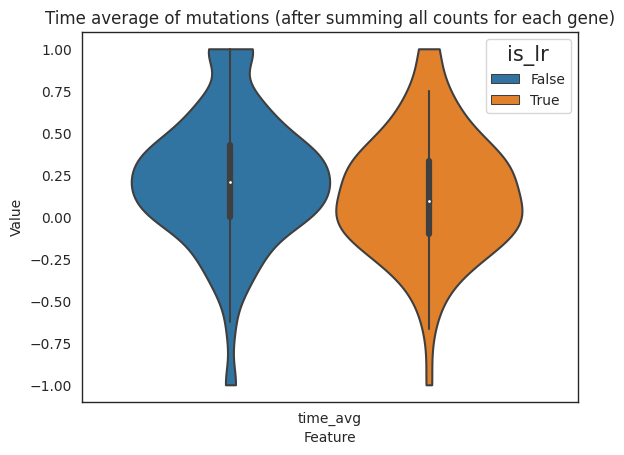

In [115]:
# Group by 'gene' and 'when' columns, then sum the 'count' values
genes_df = counts.groupby(['gene', 'when']).agg({'count': 'sum'}).reset_index()
genes_df = genes_df.pivot(index='when', columns='gene', values='count').fillna(0).T
genes_df['time_avg'] = (genes_df['Private'] - genes_df['Trunk']) / (genes_df['Private'] + genes_df['Branch'] + genes_df['Trunk'])

genes_df['is_lr'] = genes_df.index.isin(lr)

genes_df = pd.melt(genes_df.reset_index(), id_vars=['gene', 'is_lr'], value_vars=['time_avg'], 
                    var_name='Feature', value_name='Value')
#sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

plt.title('Time average of mutations (after summing all counts for each gene)')
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

In [116]:
counts['is_lr'] = counts.gene.isin(lr)

<Axes: title={'center': 'Fraction of T,B,P mutations targeting ccc genes vs other genes'}, xlabel='Feature', ylabel='Value'>

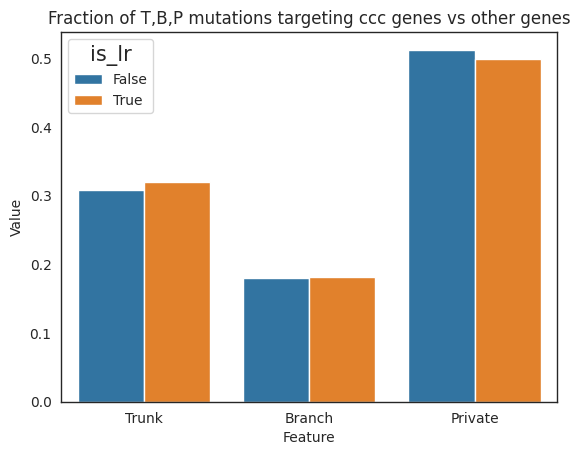

In [340]:
# Group by 'gene' and 'when' columns, then sum the 'count' values
lr_df = counts.groupby(['is_lr', 'when']).agg({'count': 'sum'}).reset_index()
lr_df = lr_df.pivot(index='when', columns='is_lr', values='count').fillna(0).T
#lr_df['time_avg'] = (lr_df['Private'] - lr_df['Trunk']) / (lr_df['Private'] + lr_df['Branch'] + lr_df['Trunk'])

lr_df = lr_df.T.div(lr_df.sum(axis=1)).T

lr_df = pd.melt(lr_df.reset_index(), id_vars=['is_lr'], value_vars=['Trunk', 'Branch', 'Private'], 
                    var_name='Feature', value_name='Value')

plt.title('Fraction of T,B,P mutations targeting ccc genes vs other genes')
sns.barplot(x='Feature', y='Value', data=lr_df, hue='is_lr')
#sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

In [282]:
lr_df.sum(axis=1)

is_lr
False    133439
True      13985
dtype: int64

when     Branch   Private     Trunk
is_lr                              
False  0.179595  0.512144  0.308261
True   0.182052  0.498820  0.319128

In [38]:
pivot_df.query('is_lr').time_avg.mean()

0.13460317460317459

In [39]:
pivot_df.query('not is_lr').time_avg.mean()

0.18339122646705616

In [332]:
def dict_to_dataframe(data_dict):
    # Convert each series to a DataFrame and concatenate them along the columns
    df = pd.DataFrame(data_dict).T
    
    # Fill missing values with 0
    df = df.fillna(0)
    
    return df

counts = {}

for sample, sampledf in df.query('when == "Trunk"').groupby('sample'):
    counts[sample] = sampledf['gene'].value_counts()
    
# Convert the dictionary to a DataFrame
trunk_df = dict_to_dataframe(counts)

counts = {}

for sample, sampledf in df.query('when == "Branch/Private"').groupby('sample'):
    counts[sample] = sampledf['gene'].value_counts()
    
# Convert the dictionary to a DataFrame
priv_df = dict_to_dataframe(counts)

In [350]:
trunk_mean = trunk_df.mean()
priv_mean = priv_df.mean()

In [354]:
trunk_df

2-Mar  3-Mar  7-Mar  A1BG  A1CF  A2LD1  A2M  A2ML1  A3GALT2  \
p001_PCRC01    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p001_PCRC03    0.0    0.0    0.0   0.0   0.0    0.0  1.0    0.0      0.0   
p001_PCRC05    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p001_PCRC06    0.0    0.0    0.0   0.0   0.0    0.0  0.0    1.0      0.0   
p001_PCRC08    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
...            ...    ...    ...   ...   ...    ...  ...    ...      ...   
p168_P04       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P17       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P18       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P49       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P90       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   

             A4GALT  ...  ZSWIM7  ZSWIM8  ZUFSP  ZWILCH  ZWINT  ZXDA  ZXDB  \
p001_PCRC01     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC03     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC05     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC06     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC08     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...             ...  ...     ...     ...    ...     ...    ...   ...   ...   
p168_P04        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P17        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P18        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P49        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P90        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             ZYG11A  ZYG11B  ZZEF1  
p001_PCRC01     0.0     0.0    0.0  
p001_PCRC03     0.0     0.0    0.0  
p001_PCRC05     0.0     0.0    0.0  
p001_PCRC06     0.0     0.0    0.0  
p001_PCRC08     0.0     0.0    0.0  
...             ...     ...    ...  
p168_P04        0.0     0.0    0.0  
p168_P17        0.0     0.0    0.0  
p168_P18        0.0     0.0    0.0  
p168_P49        0.0     0.0    0.0  
p168_P90        0.0     0.0    0.0  

[746 rows x 14638 columns]

In [351]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index_col=0)
lr = set(lr['ligand']).union(lr['receptor'])

In [352]:
print(trunk_mean.loc[~trunk_mean.index.isin(lr)].mean())
print(priv_mean.loc[~priv_mean.index.isin(lr)].mean())


0.0041163218312992985
0.006831978319383481


In [353]:
print(trunk_mean.loc[trunk_mean.index.isin(lr)].mean())
print(priv_mean.loc[priv_mean.index.isin(lr)].mean())


0.005100233355960405
0.008699126620823535


In [229]:
df['ccc'] = np.where(df.index.isin(lr), 'CCC Genes', 'Other Genes')

In [230]:
df

mutation     when          ccc
KIF1B    Chr1:10355741:G>A    Trunk  Other Genes
EPHA8    Chr1:22924187:G>T    Trunk    CCC Genes
GJA4     Chr1:35260188:G>A    Trunk  Other Genes
C8B      Chr1:57415389:C>T    Trunk  Other Genes
ANGPTL3  Chr1:63066797:T>G    Trunk    CCC Genes
...                    ...      ...          ...
SLAMF7             p.E257D  Private  Other Genes
AJAP1              p.V200I  Private  Other Genes
BTRC               p.L210L  Private  Other Genes
DUSP27             p.A321T  Private  Other Genes
PASD1              p.L148V  Private  Other Genes

[158218 rows x 3 columns]

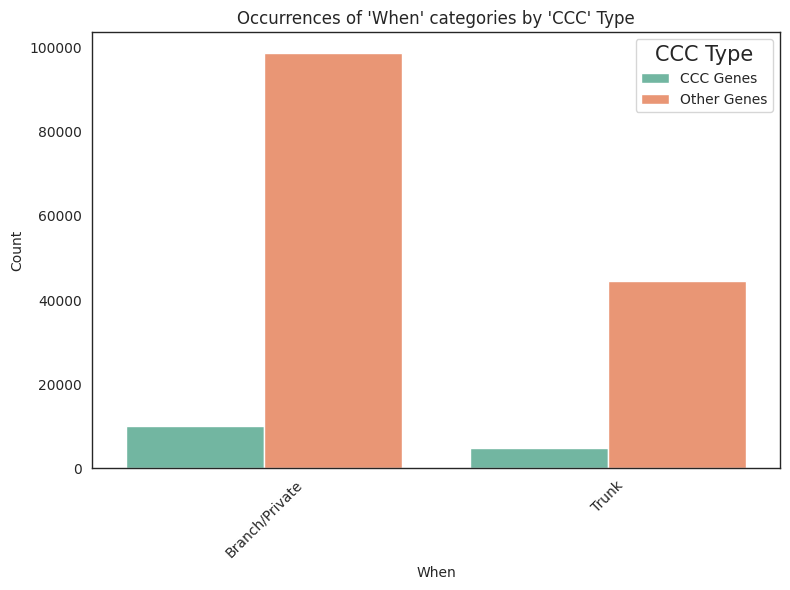

In [248]:

# Count occurrences for each combination of 'when' and 'ccc'
counts = df.groupby(['when', 'ccc']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='when', y='count', hue='ccc', data=counts, palette='Set2')

# Adding labels and title
plt.title("Occurrences of 'When' categories by 'CCC' Type")
plt.xlabel("When")
plt.ylabel("Count")
plt.legend(title="CCC Type")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [249]:
df['gene'] = df.index

In [250]:
occurrences = df.groupby(['gene', 'when']).size().unstack(fill_value=0)

In [251]:
occurrences['ccc'] = np.where(occurrences.index.isin(lr), 'CCC Genes', 'Other Genes')

In [254]:
occurrences.query('ccc == "CCC Genes"')[['Trunk', 'Branch/Private', ]].mean()

when
Trunk             3.278833
Branch/Private    6.850746
dtype: float64

In [255]:
occurrences.query('ccc == "Other Genes"')[['Trunk', 'Branch/Private', ]].mean()

when
Trunk             2.347993
Branch/Private    5.189857
dtype: float64

In [205]:
for category, subset in df.groupby(['ccc']):
    print(category)
    print(subset.head())
    print()

CCC Genes
                   mutation   when        ccc
EPHA8     Chr1:22924187:G>T  Trunk  CCC Genes
ANGPTL3   Chr1:63066797:T>G  Trunk  CCC Genes
WNT2B    Chr1:113059863:C>T  Trunk  CCC Genes
PROS1     Chr3:93646206:C>T  Trunk  CCC Genes
GRIA1    Chr5:153175054:G>A  Trunk  CCC Genes

Other Genes
                 mutation   when          ccc
KIF1B   Chr1:10355741:G>A  Trunk  Other Genes
GJA4    Chr1:35260188:G>A  Trunk  Other Genes
C8B     Chr1:57415389:C>T  Trunk  Other Genes
WDR63   Chr1:85559237:C>T  Trunk  Other Genes
FLG2   Chr1:152327032:C>T  Trunk  Other Genes



In [173]:
for key, df in dfs.items():
    print(key, sum(df.index.isin(lr)) / len(df))

Trunk_mutation 0.09694635046747722
Branch_mutation 0.09322929089855862
Private_mutation 0.09112897224082757


In [174]:
df

mutation     when
OR14A16  Chr1:247978107:T>A  private
PASK     Chr2:242062155:T>A  private
PASK     Chr2:242062159:T>A  private
SLC6A19    Chr5:1219068:C>G  private
CEP85L   Chr6:118801040:T>G  private
...                     ...      ...
SLAMF7              p.E257D  private
AJAP1               p.V200I  private
BTRC                p.L210L  private
DUSP27              p.A321T  private
PASD1               p.L148V  private

[80622 rows x 2 columns]

In [123]:
dfs

{'Trunk_mutation':                   mutation
 KIF1B    Chr1:10355741:G>A
 EPHA8    Chr1:22924187:G>T
 GJA4     Chr1:35260188:G>A
 C8B      Chr1:57415389:C>T
 ANGPTL3  Chr1:63066797:T>G
 ...                    ...
 SMARCA4            p.S813L
 SRPRB              p.P119L
 THSD7B             p.P440P
 TP53                p.H47D
 ZMAT1              p.E505Q
 
 [49842 rows x 1 columns],
 'Branch_mutation':                    mutation
 ZNF683    Chr1:26689642:G>A
 EIF5B     Chr2:99992868:G>A
 CCDC14   Chr3:123634286:T>C
 PDCD6       Chr5:271863:C>T
 GLI3      Chr7:42012081:G>A
 ...                     ...
 PKHD1              p.S2532S
 PPP1R1B             p.S164F
 PTPRD               p.S913S
 TP63                p.S624S
 USP3                p.R332T
 
 [29347 rows x 1 columns],
 'Private_mutation':                    mutation
 OR14A16  Chr1:247978107:T>A
 PASK     Chr2:242062155:T>A
 PASK     Chr2:242062159:T>A
 SLC6A19    Chr5:1219068:C>G
 CEP85L   Chr6:118801040:T>G
 ...                     ..

In [121]:
df.index.value_counts()

TP53      423
MUC4      224
TTN       160
-         149
EGFR      137
         ... 
TMC8        1
GAL         1
SH3RF1      1
RPL13A      1
GUCY2E      1
Length: 15163, dtype: int64

In [84]:
np.reshape(df_complete.Trunk_mutation.str.split(',', expand=True).values, -1).shape

(6951437,)

In [86]:
1153*6029

6951437

In [72]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tumor_coev/all_cancers/Patient/jaccard.csv')

In [5]:
df.set_index(['gene1', 'gene2'], inplace=True)

In [8]:
# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=df,
    target_col="interaction",
    feature_col="jaccard",
)

print('auroc')

auroc


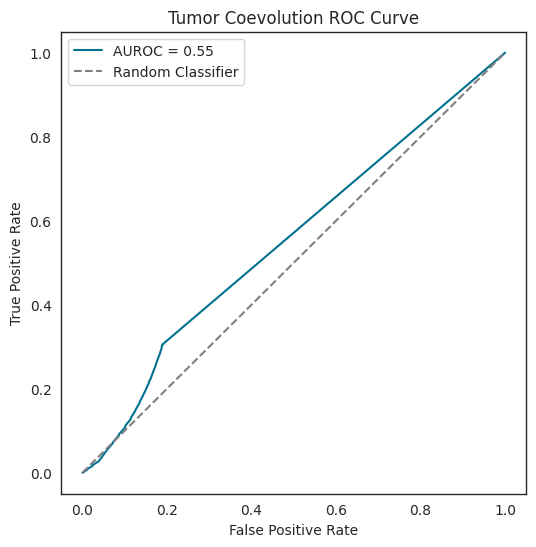

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [52]:
allowed_strings = ['(p.', 'amp', 'del']

In [53]:
def extract_gene_symbols(mutation_string):
    if pd.isna(mutation_string) or mutation_string == '':
        return []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')

    # Filter entries to only those with parentheses
    #allowed_strings = ['(p.', '(amp', '(del']
    
    filtered_entries = [entry for entry in gene_entries if any([ x in entry for x in allowed_strings]) and ')' in entry]

    # Remove the parentheses and any content within them
    cleaned_entries = [re.sub(r'\([^()]*\)', '', entry).strip() for entry in filtered_entries]

    # Return the cleaned entries
    return cleaned_entries

In [54]:
#gene_names = pd.read_csv('/home/lnemati/resources/biomart/ensembl_to_symbol_filtered.csv.gz')['Gene name'].values
output_dir = '/home/lnemati/pathway_crosstalk/results/coevolution/tumor'
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')
df_complete = df_complete.set_index('Sample', drop=False)
df_complete = df_complete.replace({'-': ''})

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

df_complete['Trunk'] = df_complete['Trunk_mutation'].apply(extract_gene_symbols)
df_complete['Branch'] = df_complete['Branch_mutation'].apply(extract_gene_symbols)
df_complete['Private'] = df_complete['Private_mutation'].apply(extract_gene_symbols)

In [55]:
keep = df_complete.apply(lambda x: any([len(x['Trunk']), len(x['Branch']), len(x['Private'])]) != 0, axis=1).values
df_complete = df_complete[keep]

In [4]:
mutations = pd.read_csv('/home/lnemati/pathway_crosstalk/results/coevolution/tumor/mutations_df.csv')

In [5]:
mutations = mutations.query("cancertype == 'all_cancers'")

mtypes = pd.DataFrame(0, index=mutations.gene.unique(), columns=['Trunk', 'Branch', 'Private', 'Patient'])

for gene, df in mutations.groupby('gene'):
    counts = df['mutation'].value_counts()
    for mutation_type in counts.index:
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]

mtypes = mtypes.drop(columns=['Patient'])
mtypes['Tot'] = mtypes.sum(axis=1)

mtypes = mtypes.sort_values(by='Tot', ascending=False)
fracs = mtypes.iloc[:, :3].div(mtypes['Tot'].values, axis=0)

mtypes = mtypes.iloc[:, :3]

In [6]:
mtypes.mean()

Trunk      2.003077
Branch     1.214977
Private    3.520719
dtype: float64

In [ ]:
# Create a stacked bar plot
ax = mtypes[:50].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of mutation types')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [61]:
all_pairs = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tumor_coev/all_cancers/Patient/cooccurrences_unfiltered.csv').set_index(['gene1', 'gene2'])

In [64]:
max_lor = all_pairs.loc[all_pairs.log2_odds_ratio <  np.inf, 'log2_odds_ratio'].max() + 1
min_lor = all_pairs.loc[all_pairs.log2_odds_ratio > -np.inf, 'log2_odds_ratio'].min() - 1

all_pairs.loc[all_pairs.log2_odds_ratio ==  np.inf, 'log2_odds_ratio'] = max_lor
all_pairs.loc[all_pairs.log2_odds_ratio == -np.inf, 'log2_odds_ratio'] = min_lor

all_pairs['-log10pval'] = -np.log10(all_pairs['pval'])

In [67]:
# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="-log10pval",
)

print('auroc')

KeyError: 'interaction'

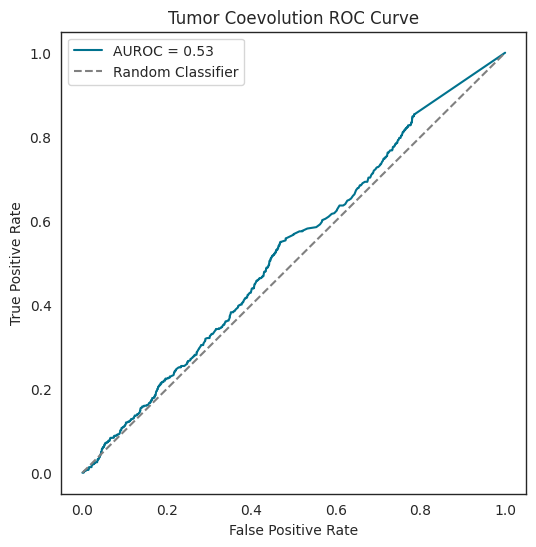

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [80]:
tissue = 'All Cancers'
mutation_type='Patient'

In [85]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')
df_complete = df_complete.set_index('Sample')
df_complete = df_complete.replace({'-': ''})

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [81]:
coev = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/coevolution/tumor/{tissue}/{mutation_type}/jaccard.csv', index_col=0)
gene_counts = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/coevolution/tumor/{tissue}/{mutation_type}/gene_counts.csv', index_col=0)
gene_counts = gene_counts.rename(columns={'genes': 'All'})

In [82]:
path = '/home/lnemati/pathway_crosstalk/results/coevolution/tumor/All Cancers'

for mutation_type in ['Trunk', 'Branch', 'Private']:
    gene_counts[mutation_type] = pd.read_csv(os.path.join(path, mutation_type, 'gene_counts.csv'), index_col=0)['genes']
    
gene_counts = gene_counts.fillna(0)

In [83]:
path = '/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv'

interactions = pd.read_csv(path)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

Number of interacting genes:  1576


In [84]:
gene_counts['interactor'] = False
gene_counts.loc[gene_counts.index.isin(all_interacting_genes), 'interactor'] = True

In [10]:
from itertools import combinations, product

# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

def update_diff_complex(
    coev,
    genes_series_a,
    genes_series_b
):
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in coev.index:
                coev.loc[pair, "interaction"] = 1
            elif (gene_b, gene_a) in coev.index:
                coev.loc[(gene_b, gene_a), "interaction"] = 1
    return

print("Reading interactions.csv")
# read interactions.csv

path = '/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv'

interactions = pd.read_csv(path)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

# ----- ROC all gene pairs -----

print("Generating ROC curves")

print("coev has shape: ", coev.shape)

# flatten TOM matrix, remove diagonal and duplicated values
print("Flattening coev matrix")
coev = pd.DataFrame(
    coev.where(
        np.tri(
            coev.shape[0],
            dtype=bool,
            k=-1
        ),
        np.nan
    ).stack(dropna=True), columns=["coev"]
)
print("coev has now shape: ", coev.shape)

coev['interaction'] = 0

update_diff_complex(coev, complex_a_genes, complex_b_genes)

print("Total number of interacting pairs: ", coev["interaction"].sum())

# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=coev,
    target_col="interaction",
    feature_col="coev",
)

print('auroc:', auroc)

# ------ Rank Sum Test VS All -------
#print("Performing rank sum test")
#
## Perform rank sum test: do interacting pairs have higher TOM than other pairs?
#U_all, p_all = mannwhitneyu(
#    coev.loc[coev['interaction'] == True, "coev"],
#    coev.loc[coev['interaction'] == False, "coev"],
#    alternative="greater"
#)
#
#print('U:', U_all)
#print('p:', p_all)

Reading interactions.csv
Number of interacting genes:  1576
Generating ROC curves
coev has shape:  (20155, 20155)
Flattening coev matrix
coev has now shape:  (203101935, 1)
Total number of interacting pairs:  3433
auroc: 0.5881786390268736


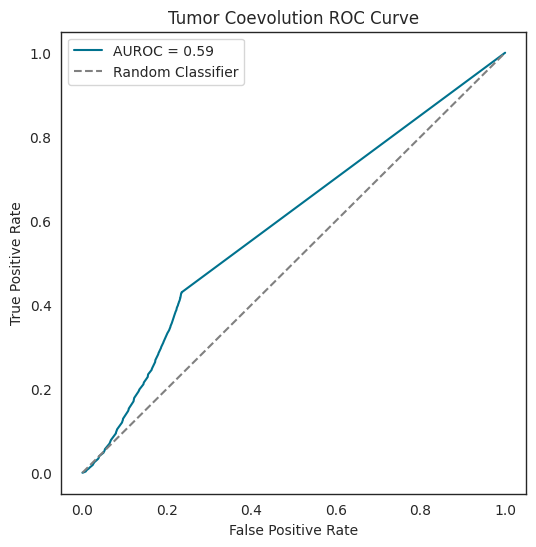

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [42]:
tcoev_int = coev[coev.interaction == 1]

In [46]:
tcoev_int.to_csv('/home/lnemati/pathway_crosstalk/results/coevolution/comparison/lr_pairs_tumor_coev_all.csv')

In [86]:
cols = ['Trunk', 'Branch', 'Private']

fracs = gene_counts[cols]

tot = df_complete.shape[0]

for col in cols:
    fracs[col] = gene_counts[col] / tot

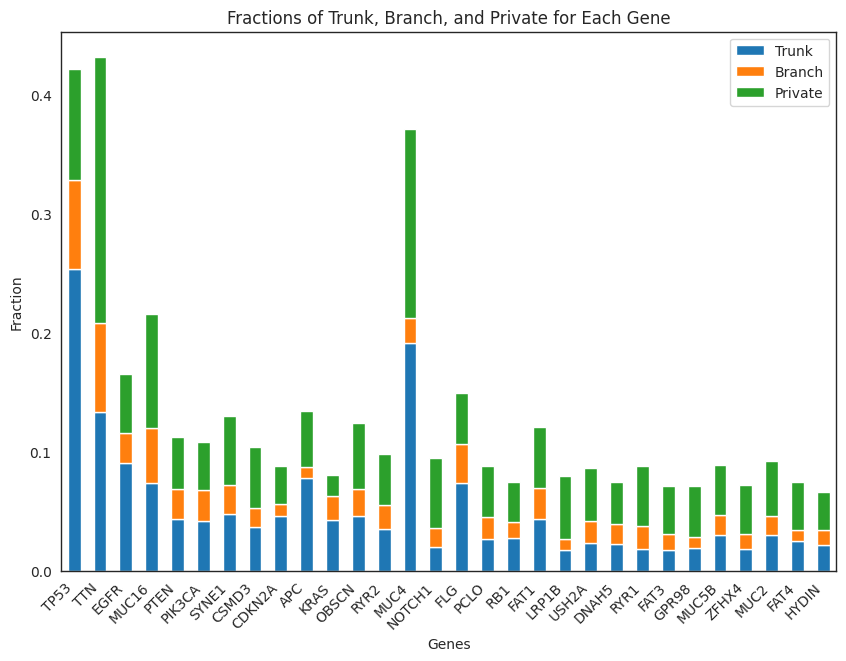

In [93]:
# Create a stacked bar plot
ax = fracs[:30].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of Trunk, Branch, and Private for Each Gene')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

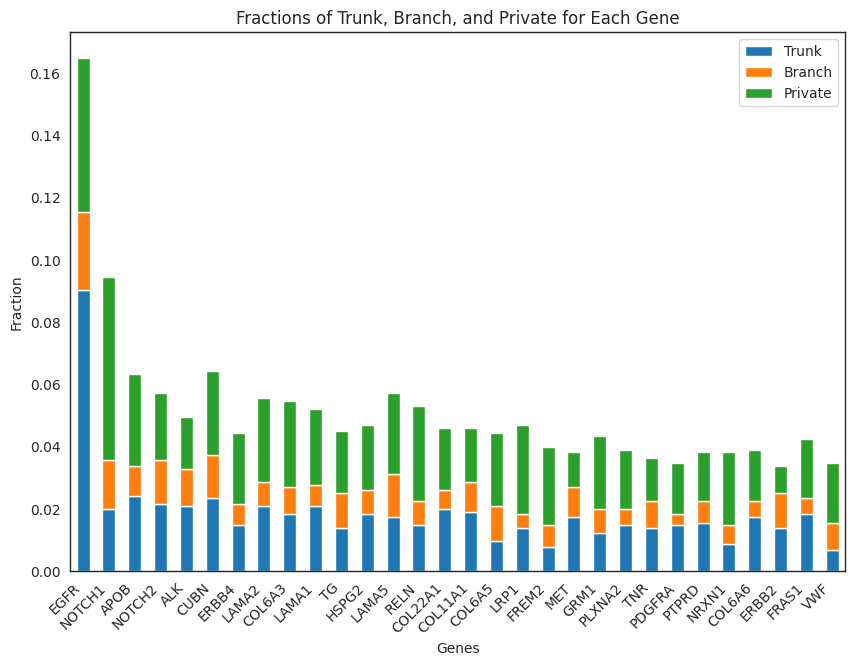

In [94]:
interactors = gene_counts[gene_counts['interactor']].index

# Create a stacked bar plot
ax = fracs.loc[interactors][0:30].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of Trunk, Branch, and Private for Each Gene')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [90]:
mutated = gene_counts[gene_counts['All'] > 10].index

In [99]:
df_frac

Trunk    Branch   Private
TP53   0.253472  0.074653  0.093750
MUC4   0.190972  0.021701  0.158854
TTN    0.133681  0.074653  0.223090
EGFR   0.090278  0.025174  0.049479
APC    0.078125  0.008681  0.047743
...         ...       ...       ...
CDC7   0.000000  0.001736  0.009549
NBPF1  0.000000  0.006944  0.006944
PANK3  0.000000  0.001736  0.009549
NPHP3  0.000000  0.000868  0.009549
MPL    0.000000  0.003472  0.010417

[3423 rows x 3 columns]

In [101]:
df_frac = fracs.loc[mutated].sort_values(by='Trunk', ascending=False)
df_frac.loc[df_frac.index.intersection(interactors)][:20]

Trunk    Branch   Private
EGFR      0.090278  0.025174  0.049479
APOB      0.024306  0.009549  0.029514
CUBN      0.023438  0.013889  0.026910
NOTCH2    0.021701  0.013889  0.021701
LAMA2     0.020833  0.007812  0.026910
ALK       0.020833  0.012153  0.016493
LAMA1     0.020833  0.006944  0.024306
COL22A1   0.019965  0.006076  0.019965
NOTCH1    0.019965  0.015625  0.059028
COL11A1   0.019097  0.009549  0.017361
COL6A3    0.018229  0.008681  0.027778
FRAS1     0.018229  0.005208  0.019097
HSPG2     0.018229  0.007812  0.020833
HLA-DRB5  0.018229  0.000000  0.004340
LAMA5     0.017361  0.013889  0.026042
MET       0.017361  0.009549  0.011285
COL6A6    0.017361  0.005208  0.016493
PTPRD     0.015625  0.006944  0.015625
ERBB4     0.014757  0.006944  0.022569
ITGAX     0.014757  0.005208  0.012153

In [92]:
df_frac = fracs.loc[mutated].sort_values(by='Private', ascending=False)
df_frac.loc[df_frac.index.intersection(interactors)][:20]

Trunk    Branch   Private
NOTCH1   0.019965  0.015625  0.059028
EGFR     0.090278  0.025174  0.049479
RELN     0.014757  0.007812  0.030382
APOB     0.024306  0.009549  0.029514
LRP1     0.013889  0.004340  0.028646
COL6A3   0.018229  0.008681  0.027778
LAMA2    0.020833  0.007812  0.026910
CUBN     0.023438  0.013889  0.026910
LAMA5    0.017361  0.013889  0.026042
FREM2    0.007812  0.006944  0.025174
LAMA1    0.020833  0.006944  0.024306
COL6A5   0.009549  0.011285  0.023438
GRM1     0.012153  0.007812  0.023438
NRXN1    0.008681  0.006076  0.023438
ERBB4    0.014757  0.006944  0.022569
NOTCH2   0.021701  0.013889  0.021701
COL15A1  0.005208  0.004340  0.020833
HSPG2    0.018229  0.007812  0.020833
CNTNAP2  0.006076  0.005208  0.019965
DSCAM    0.009549  0.004340  0.019965

# Hub Genes

In [280]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

#top_ccc = df[df['interactor'].astype(bool)][['f_degree_tumor', 'f_degree_normal']]
#top_ccc['sum'] = top_ccc['f_degree_tumor'] + top_ccc['f_degree_normal']
#top_ccc.sort_values(by='f_degree_tumor', ascending=False).head(20)

In [281]:
# Try hubs connected to pws insted of pw enrichment

In [284]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

def hub_connectivities(filename):
    
    # Example usage:
    search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
    matches = find_files(filename, search_path)    

    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    with open('/home/lnemati/resources/reactome/ReactomePathways.gmt', 'r') as f:
        for line in f.readlines():
            line = line.split('\t')
            name_to_id[line[0]] = line[1]
            id_to_name[line[1]] = line[0]
            pw_genes[line[0]] = line[2:]

    root_pws = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
    root_pws = root_pws['root'].map(id_to_name).unique()

    ndf = pd.DataFrame(columns=root_pws)
    tdf = pd.DataFrame(columns=root_pws)

    for match in matches:
        if '/normal/' in match:
            row = pd.read_csv(match, index_col=0).T
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            ndf = pd.concat([ndf, row])
        elif '/tumor/' in match:
            row = pd.read_csv(match, index_col=0).T
            row.index = [match.split('/')[-2]]
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            tdf = pd.concat([tdf, row])

    ndf = ndf.set_index('subtissue', drop=True)
    tdf = tdf.set_index('subtissue', drop=True)

    ndf = ndf.groupby('tissue').median()
    tdf = tdf.groupby('tissue').median()

    ndf['Condition'] = 'normal'
    tdf['Condition'] = 'tumor'
    
    df = pd.concat([ndf, tdf])

    # Reshape the DataFrame to a long format suitable for violin plots
    df = pd.melt(df, id_vars=['Condition'], var_name='Pathway', value_name='Connectivity')
    #df_long['Connectivity'] = np.log(df_long['Connectivity'])

    order = df.drop(columns='Condition').groupby('Pathway').mean().sort_values(by='Connectivity', ascending=False).index
    
    # Initialize an empty dictionary to store the results
    pvals = {}

    # Get unique pathways
    pathways = df['Pathway'].unique()

    # Loop through each pathway
    for pathway in pathways:
        # Subset the data for the current pathway
        subset = df[df['Pathway'] == pathway]

        # Split into normal and tumor conditions
        normal = subset[subset['Condition'] == 'normal']['Connectivity']
        tumor = subset[subset['Condition'] == 'tumor']['Connectivity']

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(normal, tumor, alternative='two-sided')

        # Store the p-value in the dictionary with pathway as the key
        pvals[pathway] = p_value

    # Convert the dictionary to a pandas Series
    pvals = pd.Series(pvals, name='pvals')
    pvals = pvals.loc[order]
    pvals.loc[order] = false_discovery_control(pvals, method='bh')

    return df, pvals

In [285]:
connect, pvals = hub_connectivities('hubs_connectivities_root.csv')

In [286]:
def plot_pathway_connectivity(df, pvals, significance=None, ax=None):
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars.
    
    Arguments:
    df : DataFrame
        The dataframe containing the data for plotting. It must have 'Pathway', 'Connectivity', and 'condition' columns.
    pvals : Series
        A Series where the index is the pathway names and the values are the p-values.
    savepath : str, optional
        The path where the plot will be saved. If None, the plot will not be saved. Default is None.
    significance : float or None, optional
        The maximum p-value to consider a pathway significant. If None, plot all pathways. Default is None.
    """
        
    # Define a function to add significance stars
    def add_significance_bar(x1, x2, y, h, significance, ax):
        """
        Add significance bar with stars between two boxplots.

        x1, x2: Positions of the two groups (normal/tumor).
        y: Height where the bar is placed.
        h: Height of the bar itself.
        significance: The star to place based on p-value.
        ax: The axis object to annotate on.
        """
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color='black')

    # Filter pathways based on the significance threshold if provided
    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index

    # Create the boxplot
    palette = {'normal': ncolor, 'tumor': tcolor}  # assume ncolor and tcolor are pre-defined
    if ax is None:
        ax = sns.boxplot(
            x='Pathway',
            y='Connectivity',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
        )
    else:
        sns.boxplot(
            x='Pathway',
            y='Connectivity',
            hue='Condition',
            data=df,
            order=order,
            palette=palette,
            showfliers=False,
            ax=ax
        )

    ax.set_ylabel('Connectivity')
    plt.xticks(rotation=90)

    # Add significance bars and stars for each pathway
    for i, pathway in enumerate(order):
        # Get the p-value for the current pathway from the pvals Series
        pval = pvals[pathway]

        # Determine significance level
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'  # no significance

        # Find the maximum y-value for the current pathway to position the bars
        y_max = df[df['Pathway'] == pathway]['Connectivity'].max()

        # Get positions of normal and tumor groups (the boxplot positions)
        width = 0.4
        x1 = i - width  # position of normal (left side)
        x2 = i + width  # position of tumor (right side)

        # Add the significance bar if it's below the significance threshold (if provided)
        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, y_max + 0.01, 0.02, stars, ax)

    # Adjust layout to fit labels
    plt.ylim(0, 0.45)

In [287]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

# Generate column names based on the metric
tumor_col = 'f_degree_tumor'
normal_col = 'f_degree_normal'

# Convert columns to numeric (ensuring proper conversion)
df[tumor_col] = pd.to_numeric(df[tumor_col], errors='coerce')
df[normal_col] = pd.to_numeric(df[normal_col], errors='coerce')

# Init Tumor Hubs DataFrame
tumor_hub_values = df[tumor_col].dropna().unique()  # Drop NaNs before sorting
tumor_hub_df = pd.DataFrame(index=sorted(tumor_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init Normal Hubs DataFrame
normal_hub_values = df[normal_col].dropna().unique()  # Drop NaNs before sorting
normal_hub_df = pd.DataFrame(index=sorted(normal_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

# Init All Hubs DataFrame
all_hub_values = set(normal_hub_values).union(tumor_hub_values)
all_hub_df = pd.DataFrame(index=sorted(all_hub_values, reverse=True), columns=['Tumor', 'Normal', 'Both'])

# Prepare Tumor Hubs DataFrame
for value in tumor_hub_df.index:
    tumor_hub_df.loc[value, 'CCC'] = ((df[tumor_col] >= value) & (df['interactor'] == 1)).sum()
    tumor_hub_df.loc[value, 'Other Genes'] = ((df[tumor_col] >= value) & (df['interactor'] == 0)).sum()

# Prepare Normal Hubs DataFrame
for value in normal_hub_df.index:
    normal_hub_df.loc[value, 'CCC'] = ((df[normal_col] >= value) & (df['interactor'] == 1)).sum()
    normal_hub_df.loc[value, 'Other Genes'] = ((df[normal_col] >= value) & (df['interactor'] == 0)).sum()

# Prepare All Hubs DataFrame
for value in all_hub_df.index:
    all_hub_df.loc[value, 'Both'] = ((df[normal_col] >= value) & (df[tumor_col] >= value)).sum()
    all_hub_df.loc[value, 'Normal'] = (df[normal_col] >= value).sum() - all_hub_df.loc[value, 'Both']
    all_hub_df.loc[value, 'Tumor'] = (df[tumor_col] >= value).sum() - all_hub_df.loc[value, 'Both']

# Normalize frequencies in Tumor and Normal Hubs DataFrame
tumor_hub_df = tumor_hub_df.div(tumor_hub_df.sum(axis=1), axis=0)
normal_hub_df = normal_hub_df.div(normal_hub_df.sum(axis=1), axis=0)

# Ensure all values are numeric
tumor_hub_df = tumor_hub_df.astype(np.float64)
normal_hub_df = normal_hub_df.astype(np.float64)
all_hub_df = all_hub_df.astype(np.float64)

# Define x values
normal_hub_x = normal_hub_df.index
tumor_hub_x = tumor_hub_df.index
all_hub_x = all_hub_df.index

# Get most common tumor and normal hubs
#tmax_str = '\n'.join(df[df.f_degree_tumor == df.f_degree_tumor.max()].index)
#nmax_str = '\n'.join(df[df.f_degree_normal == df.f_degree_normal.max()].index)

tmax_str = '  SASH3\nNCKAP1L'
nmax_str = 'RPL27A\n RPL19'

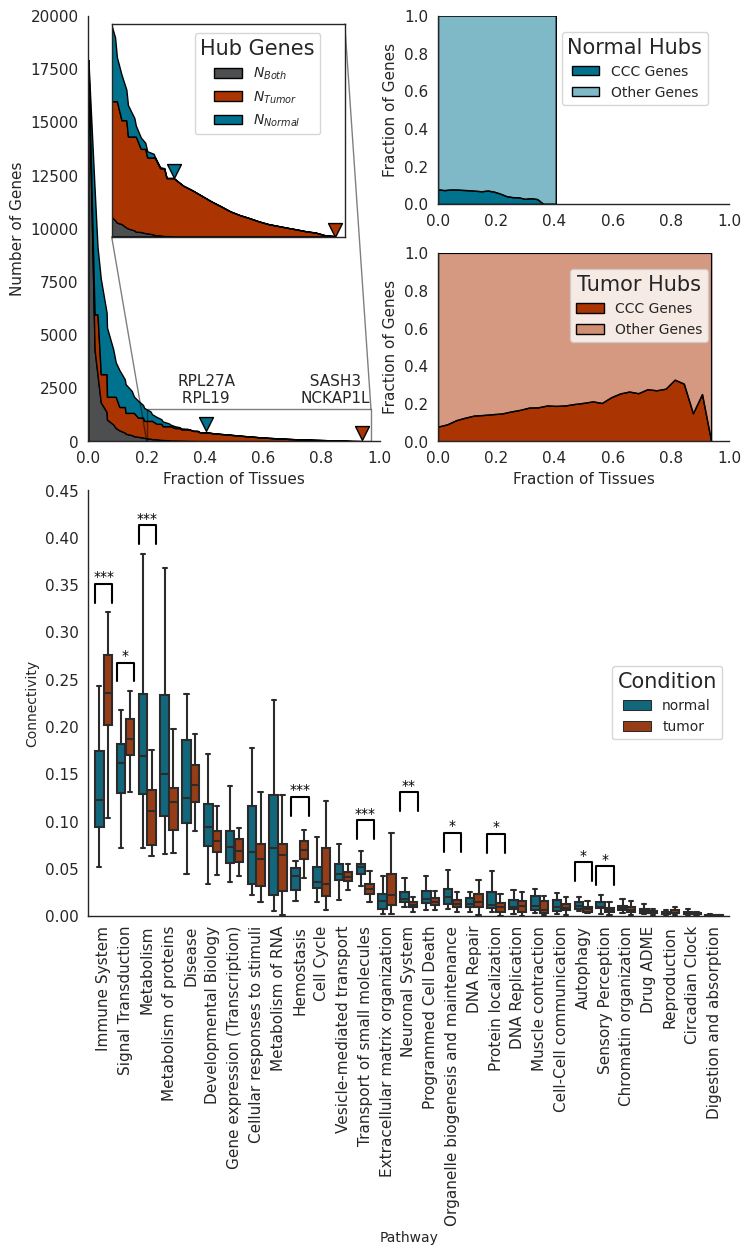

In [326]:
# HUBS FULL FIGURE

fs = 11

# Create the figure and the layout
fig = plt.figure(figsize=(8.27, 11.69))
axs = fig.subplot_mosaic(
    """
    AB
    AC
    DD
    DD
    """
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_df.query('Tumor != 0').index.max()
normal_max = all_hub_df.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=400+all_hub_df.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=400+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.1, y=1800, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.21, y=1800, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_df.loc[normal_max].sum(), color=ncolor, s=100, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=100, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Plot pathways barplots
plot_pathway_connectivity(connect, pvals, ax=axs['D'])

# Adjust layout to remove space between plots
# plt.tight_layout()

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc,)
axs['B'].legend(['CCC Genes', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc)
axs['C'].legend(['CCC Genes', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc)
axs['D'].legend(title='Condition', loc='center right')


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

fig.subplots_adjust(hspace=0.26)  # Increase the vertical spacing between subplots
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_figure.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_figure.png', bbox_inches='tight')
plt.show()

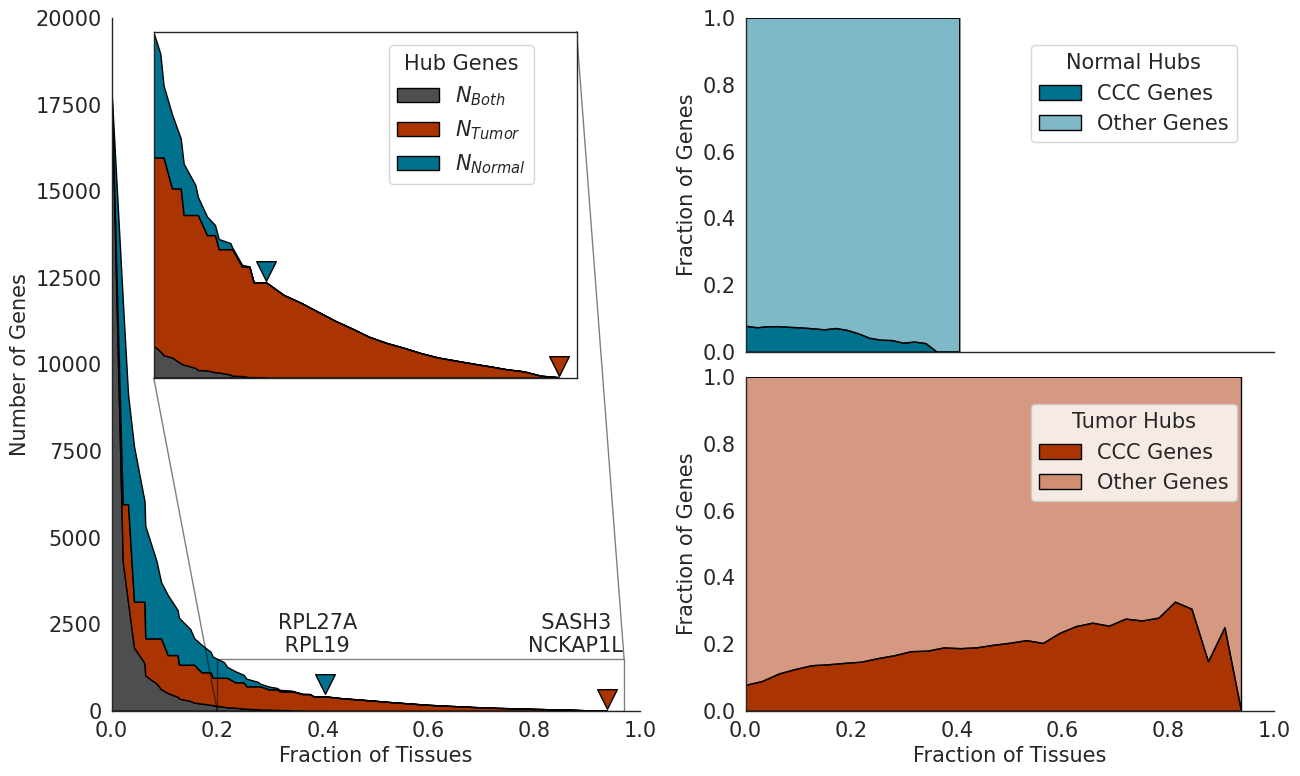

In [322]:
# HUBS FULL FIGURE

fs = 15

# Create the figure and the layout
fig = plt.figure(figsize=(15, 9))
axs = fig.subplot_mosaic(
    """
    AB
    AC
    """
)

# Plot All Hubs using plt.stackplot
axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)

tumor_max = all_hub_df.query('Tumor != 0').index.max()
normal_max = all_hub_df.query('Normal != 0').index.max()

#axs['A'].vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axs['A'].vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')
axs['A'].scatter(x=normal_max, y=325+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axs['A'].scatter(x=tumor_max, y=325+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
axs['A'].text(x=normal_max-0.09, y=1700, s=nmax_str, fontsize=fs)
axs['A'].text(x=tumor_max-0.15, y=1700, s=tmax_str, fontsize=fs)
axs['A'].set_ylabel('Number of Genes', fontsize=fs)
axs['A'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['A'].grid(False)

# Add zoom

# subregion of the original image
x1, x2 = 0.2, 0.97,
y1, y2 = 0, 1500
    
axins = axs['A'].inset_axes(
    [0.08, 0.48, 0.8, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
              colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
axins.scatter(x=normal_max, y=50+all_hub_df.loc[normal_max].sum(), color=ncolor, s=200, marker='v', edgecolor='k')
axins.scatter(x=tumor_max, y=50+all_hub_df.loc[tumor_max].sum(), color=tcolor, s=200, marker='v', edgecolor='k')
#axins.vlines(x=tumor_max,  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
#axins.vlines(x=normal_max, ymin=0, ymax=2e4, color=ncolor, linestyle='--')

axs['A'].indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)

# Plot Normal Hubs using plt.stackplot
axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
              colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
axs['B'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['B'].grid(False)

# Plot Tumor Hubs using plt.stackplot
axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
              colors=[tcolor, tcolor2], edgecolor='black')
axs['C'].set_xlabel('Fraction of Tissues', fontsize=fs)
axs['C'].set_ylabel('Fraction of Genes', fontsize=fs)
axs['C'].grid(False)

# Add legends
loc = 'upper right'
axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='Hub Genes', bbox_to_anchor=(0.82, 0.975), loc=loc, fontsize=fs)
axs['B'].legend(['CCC Genes', 'Other Genes'], title='Normal Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)
axs['C'].legend(['CCC Genes', 'Other Genes'], title='Tumor Hubs', bbox_to_anchor=(0.95, 0.95), loc=loc, fontsize=fs)


axs['A'].set_xlim(0, 1)
axs['B'].set_xlim(0, 1)
axs['C'].set_xlim(0, 1)

axs['A'].set_ylim(0, 20000)
axs['B'].set_ylim(0, 1.)
axs['C'].set_ylim(0, 1.)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)
    
fig.subplots_adjust(hspace=0.075)  # Increase the vertical spacing between subplots
axs['B'].set_xticks([])

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_subset_figure.png', bbox_inches='tight')
plt.show()

In [138]:
median_df = df.groupby(['Pathway', 'condition']).median()

In [142]:
df_pivot = median_df.pivot_table(index='Pathway', columns='condition', values='Connectivity').reset_index()
df_pivot.columns = ['pathway', 'normal_median', 'tumor_median']
df_pivot = df_pivot.set_index('pathway')
df_pivot['pval_adj'] = pvals.loc[df_pivot.index]

df_pivot =  df_pivot.sort_values(by='pval_adj')

df_pivot.head()

normal_median  tumor_median  pval_adj
pathway                                                                 
Pyruvate metabolism                     0.004510      0.001152  0.000019
Signaling by Retinoic Acid              0.002139      0.000447  0.000019
Costimulation by the CD28 family        0.003132      0.017631  0.000019
CD28 dependent PI3K/Akt signaling       0.000952      0.003903  0.000019
PD-1 signaling                          0.000741      0.011909  0.000020

In [143]:
df_pivot.to_csv('/home/lnemati/pathway_crosstalk/results/hubs/hubs_connectivities_all.csv')

In [144]:
sum(pvals.sort_values() < 0.05)

641

In [165]:
for i, pw in enumerate(pvals.sort_values().head(20).index):
    print(i, pw)

0 Transport of small molecules
1 Immune System
2 Hemostasis
3 Metabolism
4 Neuronal System
5 Autophagy
6 Sensory Perception
7 Signal Transduction
8 Organelle biogenesis and maintenance
9 Protein localization
10 Extracellular matrix organization
11 Developmental Biology
12 Metabolism of proteins
13 Reproduction
14 Programmed Cell Death
15 Chromatin organization
16 Digestion and absorption
17 Drug ADME
18 Muscle contraction
19 Cellular responses to stimuli


In [158]:
df_pivot

normal_median  tumor_median  \
pathway                                                                       
Pyruvate metabolism                              4.510056e-03  1.151803e-03   
Signaling by Retinoic Acid                       2.139433e-03  4.473486e-04   
Costimulation by the CD28 family                 3.132045e-03  1.763132e-02   
CD28 dependent PI3K/Akt signaling                9.519045e-04  3.902639e-03   
PD-1 signaling                                   7.410211e-04  1.190942e-02   
...                                                       ...           ...   
ABO blood group biosynthesis                     1.229832e-07  1.292757e-07   
p75NTR negatively regulates cell cycle via SC1   5.118899e-05  5.664818e-05   
p75 NTR receptor-mediated signalling             6.615084e-03  7.061552e-03   
semaxanib-resistant FLT3 mutants                 0.000000e+00  0.000000e+00   
quizartinib-resistant FLT3 mutants               0.000000e+00  0.000000e+00   

                                                pval_adj  
pathway                                                   
Pyruvate metabolism                             0.000019  
Signaling by Retinoic Acid                      0.000019  
Costimulation by the CD28 family                0.000019  
CD28 dependent PI3K/Akt signaling               0.000019  
PD-1 signaling                                  0.000020  
...                                                  ...  
ABO blood group biosynthesis                    1.000000  
p75NTR negatively regulates cell cycle via SC1  1.000000  
p75 NTR receptor-mediated signalling            1.000000  
semaxanib-resistant FLT3 mutants                1.000000  
quizartinib-resistant FLT3 mutants              1.000000  

[2681 rows x 3 columns]

In [46]:
tdf.mean()

Hemostasis                               4270.912763
Neuronal System                          1309.967664
Developmental Biology                    4728.641630
Metabolism                               6187.209892
Reproduction                              244.598637
Extracellular matrix organization        2585.236776
Cell-Cell communication                   623.944947
Signal Transduction                     11918.355038
Cell Cycle                               1962.701643
Disease                                  7947.733961
Immune System                           13805.074068
Organelle biogenesis and maintenance      674.443691
Transport of small molecules             2094.507959
Metabolism of proteins                   6615.933787
Muscle contraction                        951.417082
Circadian Clock                           192.005313
Chromatin organization                    325.713574
Programmed Cell Death                     804.870777
Vesicle-mediated transport               2421.

In [225]:
adj = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/tumor/pancreatic_adenocarcinoma/adjacency.csv.gz'
adj = pd.read_csv(adj, index_col=0)
np.fill_diagonal(adj.values, 1)

hubs = list(adj.sum().sort_values(ascending=False).iloc[:round(0.05 * len(adj))].index)

In [261]:
for pw in root_pws:
    print(pw)
    genes = list(set(pw_genes[pw]).intersection(adj.columns))
    tot = np.sum(adj.loc[hubs, genes].values)
    print(tot)

Hemostasis
2323.3446196754326
Neuronal System
1203.9393990993285
Developmental Biology
2598.5842206828265
Metabolism
3379.1427617302256
Reproduction
123.37712089302073
Extracellular matrix organization
1553.177971740065
Cell-Cell communication
316.7138279112287
Signal Transduction
6550.080485405918
Cell Cycle
604.3455731905674
Disease
4214.566723836082
Immune System
7282.814302567795
Organelle biogenesis and maintenance
366.9995748803622
Transport of small molecules
1262.3266905925097
Metabolism of proteins
3936.898969763702
Muscle contraction
559.2444386460074
Circadian Clock
80.70506153182191
Chromatin organization
143.78119588974823
Programmed Cell Death
294.3344340759629
Vesicle-mediated transport
1661.3066319038433
DNA Replication
105.78441011361701
DNA Repair
404.49753761612715
Gene expression (Transcription)
1905.6553303190822
Metabolism of RNA
1077.1404145508686
Cellular responses to stimuli
1158.7967052593826
Digestion and absorption
1.637215986194416
Protein localization
313.

In [246]:
tot

6097.964977953204

# Interactions enrichment

In [97]:
name2id = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', header=None, index_col=0).to_dict()[1]
id2name = {v: k for k, v in name2id.items()}

roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')

roots['root'] = roots.root.map(id2name)
roots['pathway'] = roots.pathway.map(id2name)

pw2root = roots.set_index('pathway')['root'].to_dict()

In [98]:
tdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/mannwhitneyu/mannwhitneyu_min_tumor_enrichment.csv')

In [102]:
ndf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/mannwhitneyu/mannwhitneyu_min_normal_enrichment.csv')

# Compare

In [99]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/compare_results.csv', index_col=0)
df = df.drop(columns=['avg_coev_tom_correlation'])

In [100]:
df[df['modularity'] < 0.3]['modularity'].sort_values()

name
testis                                   0.054892
colon_transverse                         0.206424
heart_left_ventricle                     0.239598
brain_cortex                             0.241315
brain_caudate_basal_ganglia              0.255689
kidney_cortex                            0.259091
brain_nucleus_accumbens_basal_ganglia    0.274479
rectum_adenocarcinoma                    0.278666
adrenocortical_cancer                    0.282483
lung_squamous_cell_carcinoma             0.297960
Name: modularity, dtype: float64

In [102]:
df['interactions_mannwhitneyu_p_adj'] = false_discovery_control(df['interactions_mannwhitneyu_p'], method='bh')

In [103]:
auroc_a = df['interactions_auroc']
auroc_t = df.query('condition == "tumor"')['interactions_auroc']
auroc_n = df.query('condition == "normal"')['interactions_auroc']

print('AUROC')

print('All tissues:', auroc_a.mean(), '+/-', np.std(auroc_a))
print('Normal', auroc_n.mean(), '+/-', np.std(auroc_n))
print('Tumor', auroc_t.mean(), '+/-', np.std(auroc_t))

ua = df['interactions_mannwhitneyu_U']
ut = df.query('condition == "tumor"')['interactions_mannwhitneyu_U']
un = df.query('condition == "normal"')['interactions_mannwhitneyu_U']

AUROC
All tissues: 0.6103896637308337 +/- 0.0368408026208443
Normal 0.5881180230039456 +/- 0.01957211204041014
Tumor 0.6431011360484509 +/- 0.03145614205515242


In [104]:
df['-log10_mannwhitneyu_p_adj'] = -np.log10(df['interactions_mannwhitneyu_p_adj'])

In [105]:
df.drop(columns='interactions_mannwhitneyu_p', inplace=True)
df.drop(columns='interactions_mannwhitneyu_p_adj', inplace=True)

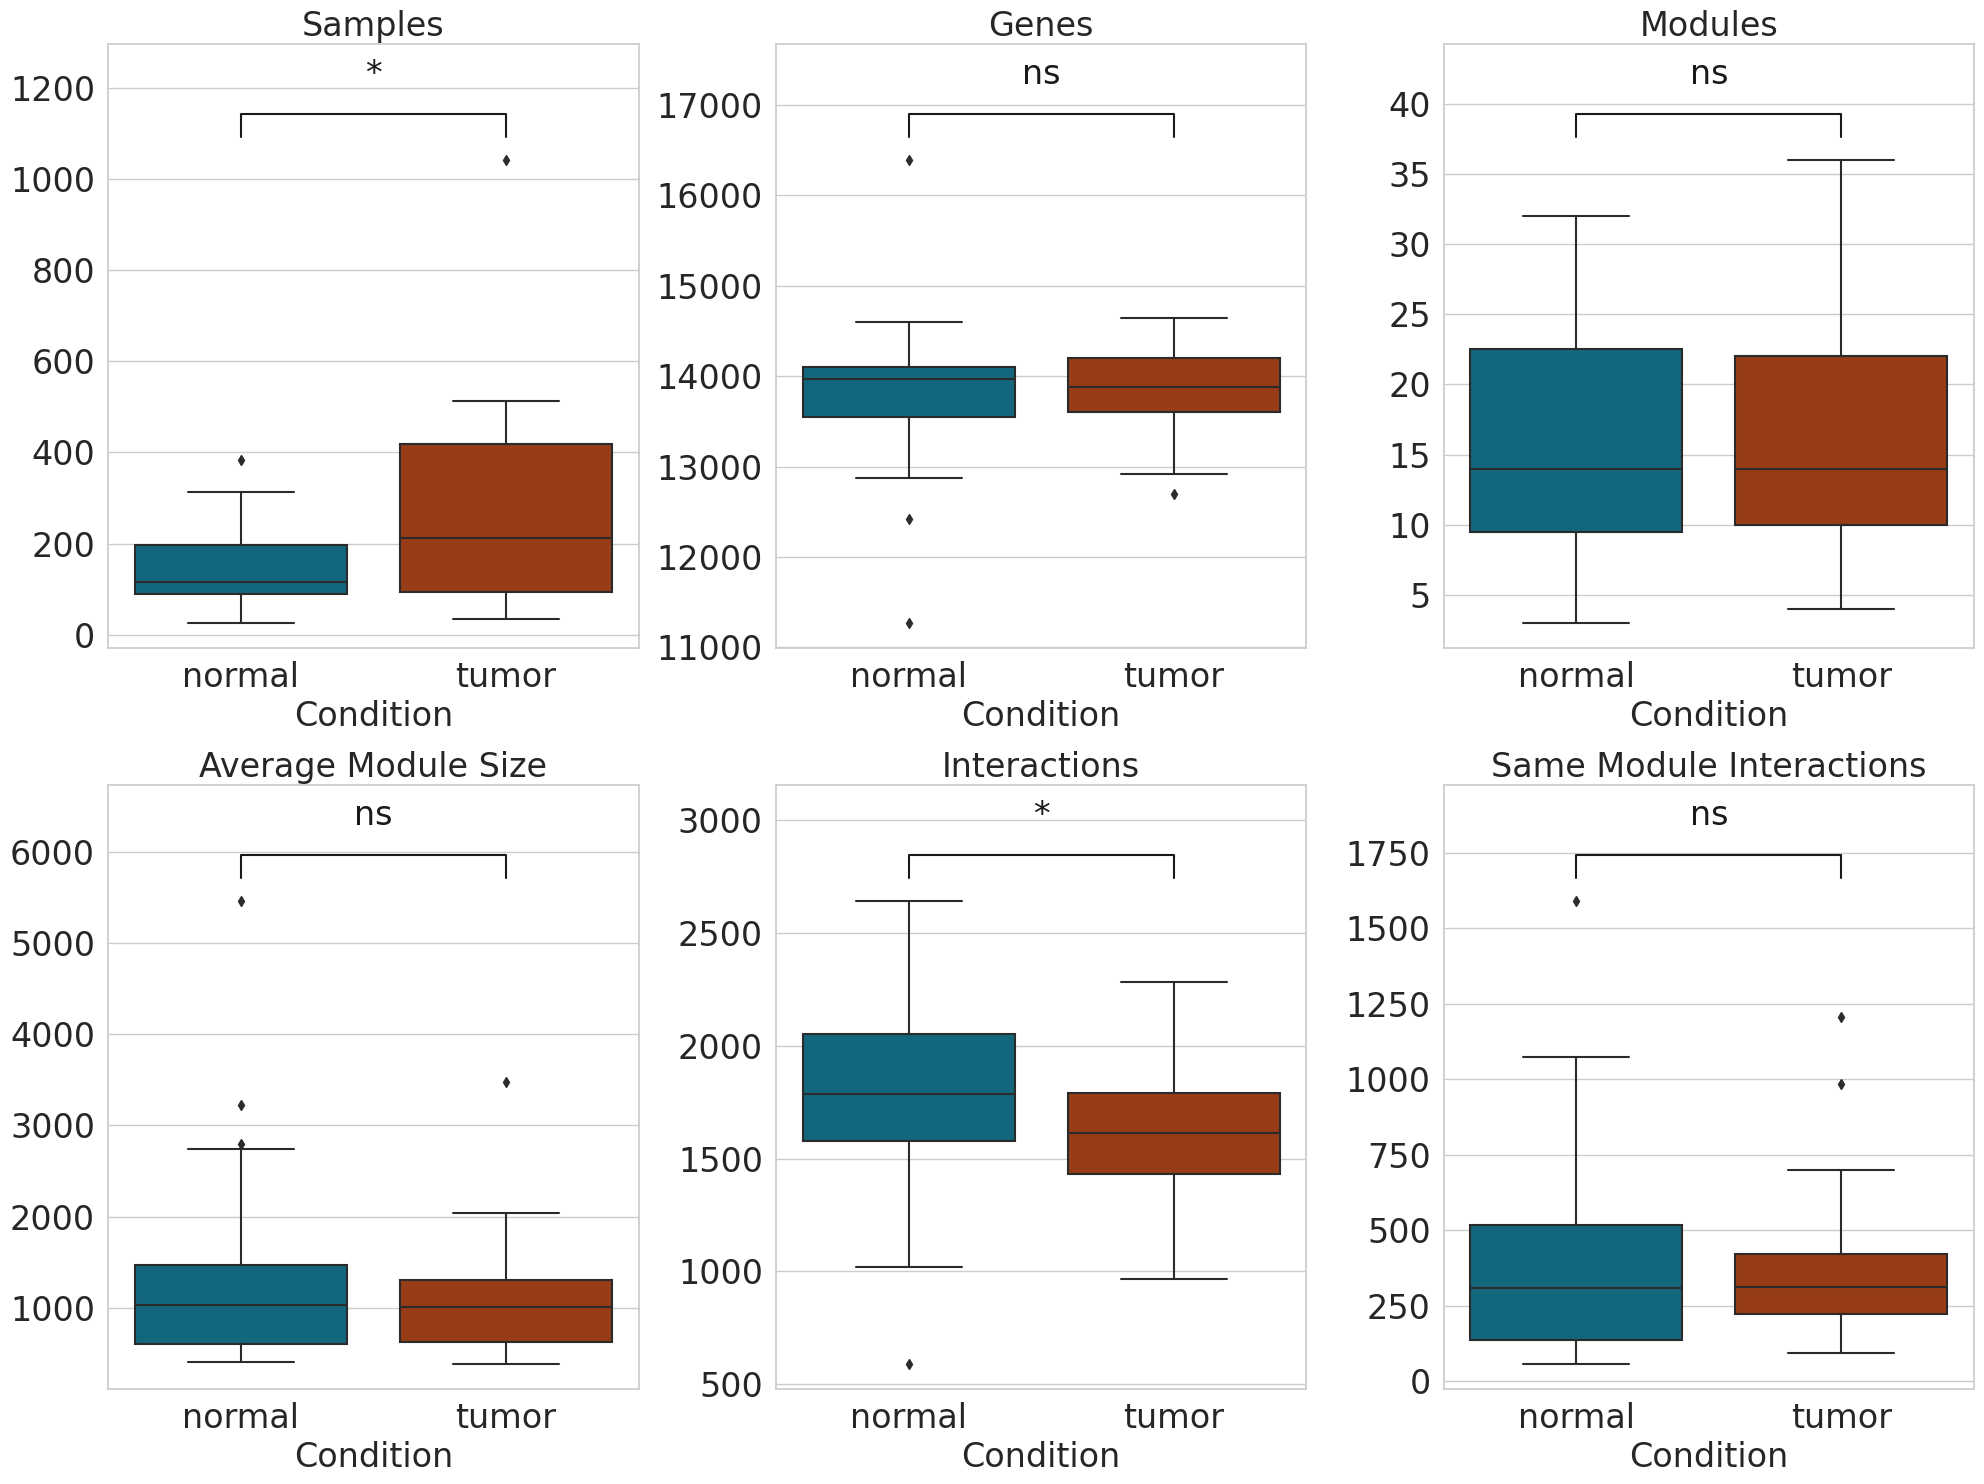

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'n_samples': 'Samples',
    'n_genes': 'Genes',
    'n_modules': 'Modules',
    'avg_module_size': 'Average Module Size',
    #'avg_degree': 'Average Degree',
    #'avg_intramodular_degree': 'Average Intramodular Degree',
    'tot_interactions': 'Interactions',
    'n_interactions_same_module': 'Same Module Interactions',
    #'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Mann-Whitney $U$',
    #'-log10_mannwhitneyu_p_adj': 'Mann-Whitney $-log_{10}{p_{adj}}$',
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot the countplot for 'condition'
#plt.subplot(subplot_shape[0], subplot_shape[1], 1)
#sns.countplot(x='condition', data=df, palette=[ncolor, tcolor])
#plt.title('Tissues', fontsize=fs)
#plt.xlabel('Condition', fontsize=fs)
#plt.ylabel('', fontsize=fs)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_all.pdf')

# Show the plot
plt.show()


In [111]:
df['prob_same_module'] = df.n_interactions_same_module / df.tot_interactions

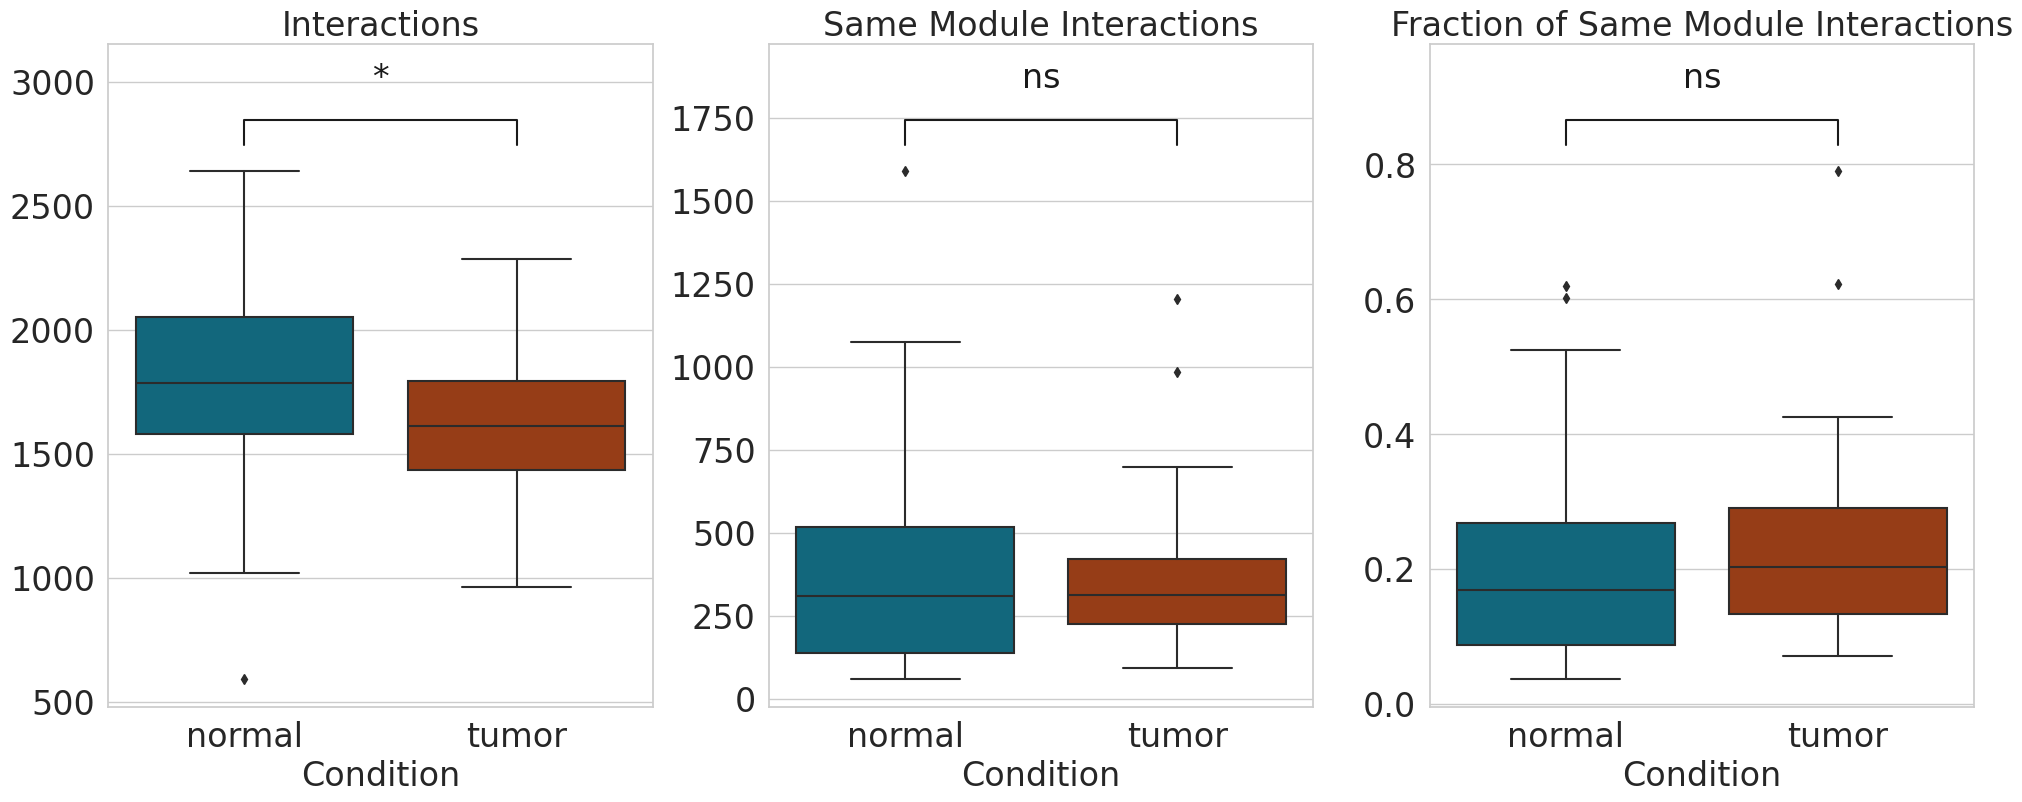

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'tot_interactions': 'Interactions',
    'n_interactions_same_module': 'Same Module Interactions',
    'prob_same_module': 'Fraction of Same Module Interactions'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_interactions.pdf')

# Show the plot
plt.show()


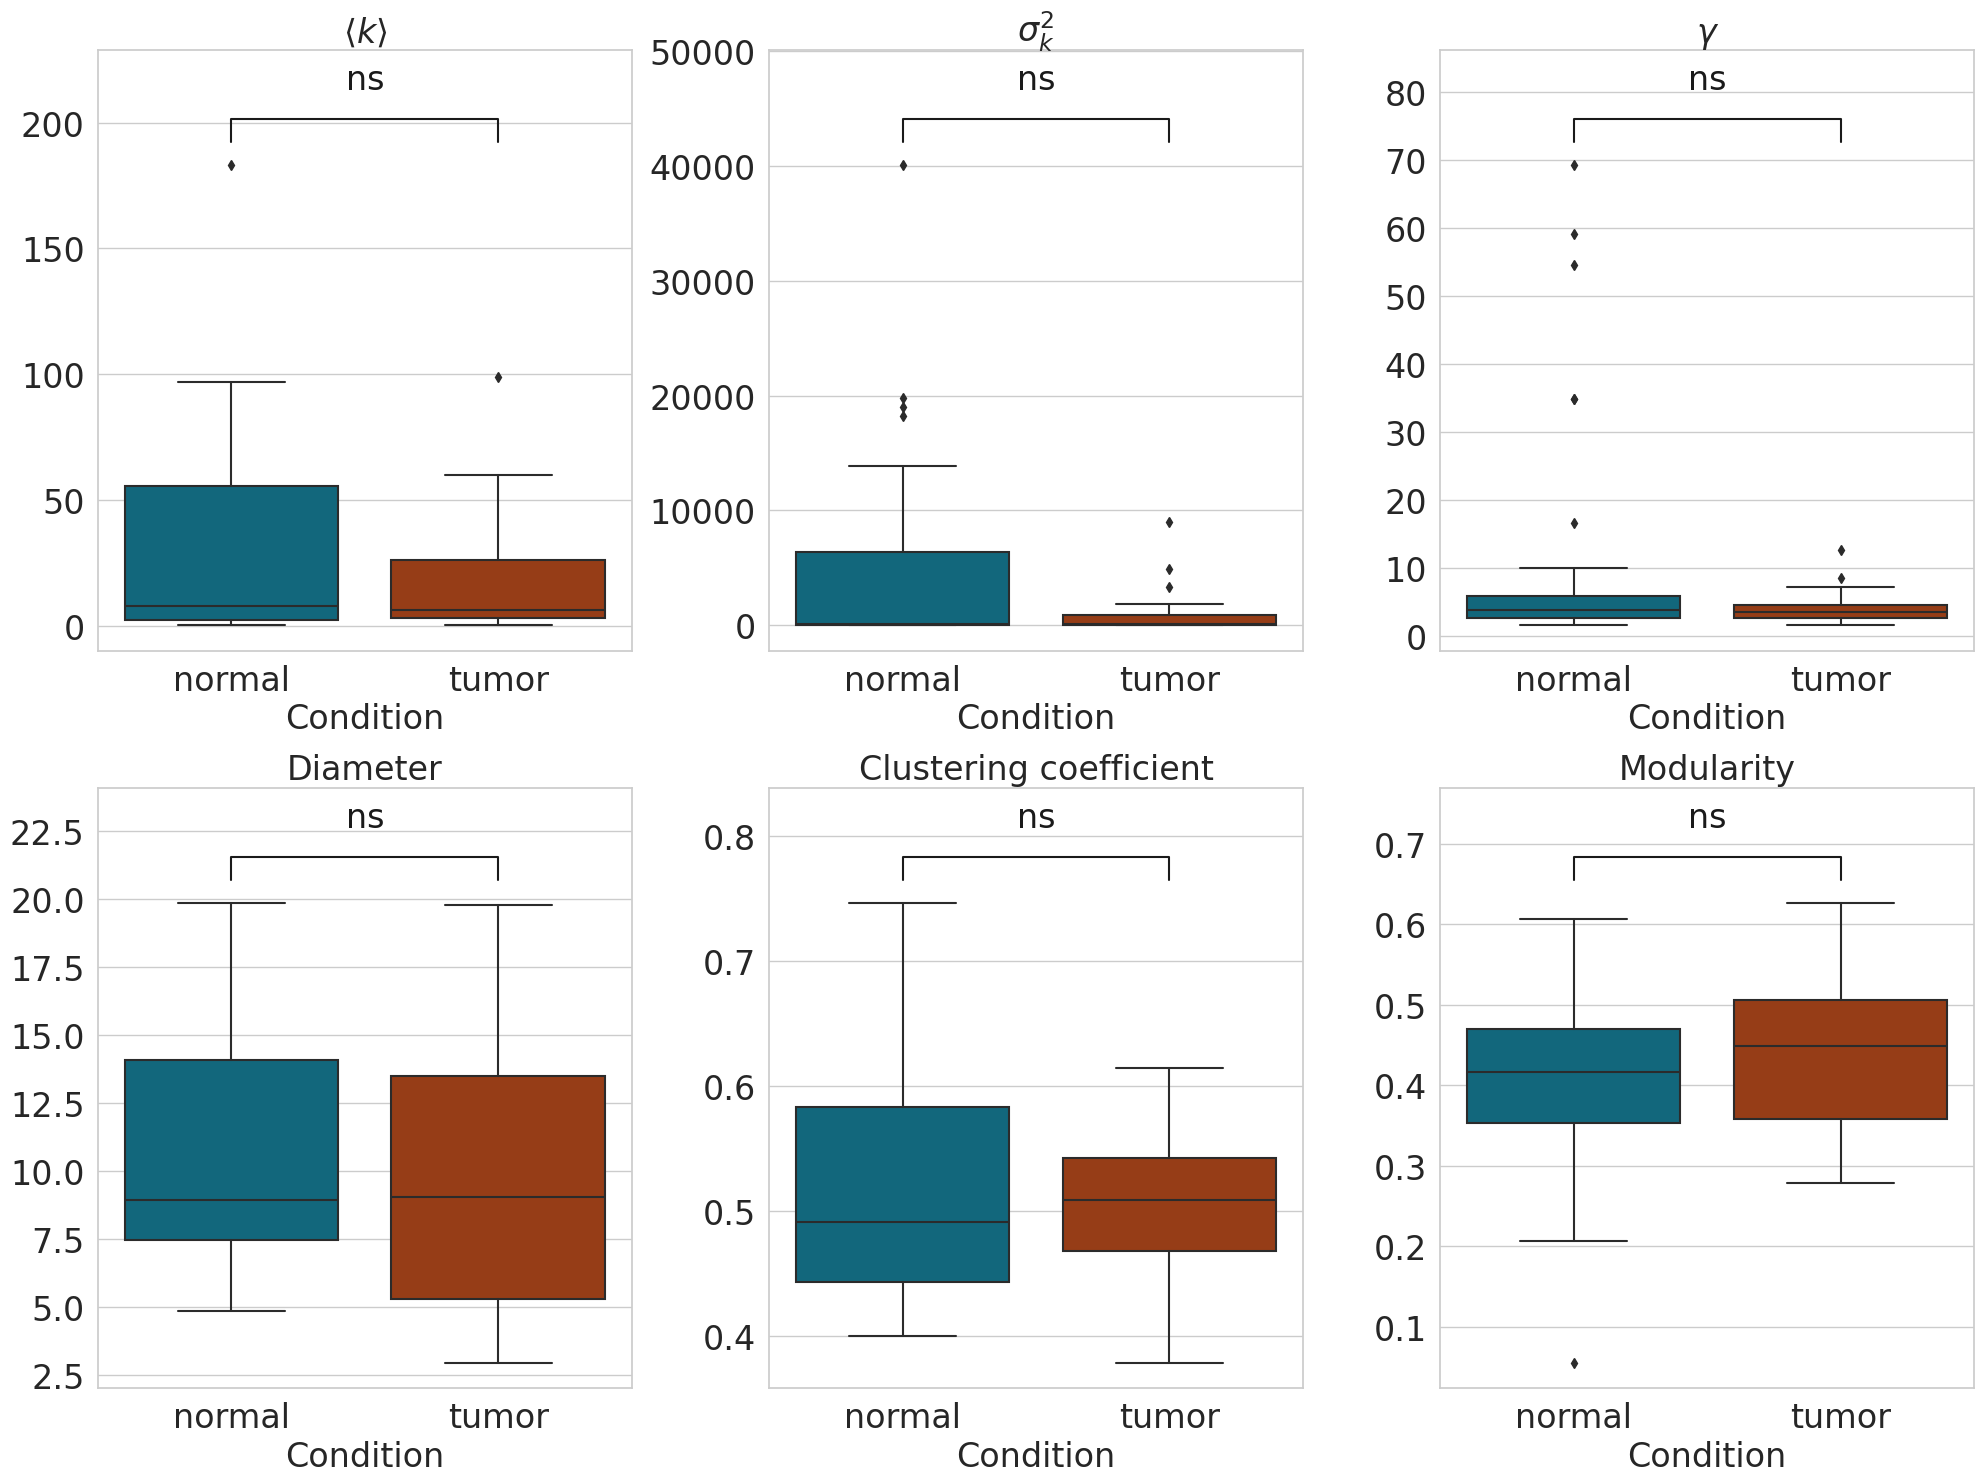

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
# Title dictionary for subplots
title_dict = {
    'avg_degree': '$ \langle k \\rangle $',
    #'avg_intramodular_degree': 'avg_intramodular_degree',
    'var_degree': '$ \sigma^2_{k}$',
    #'var_intramodular_degree': 'variance_intramodular',
    'powerlaw_alpha': '$\gamma$',
    #'avg_shortest_path': 'avg_path_length',
    'diameter': 'Diameter',
    'clustering_global': 'Clustering coefficient',
    'modularity': 'Modularity',
    #'powerlaw_xmin': 'xmin',
    #'powerlaw_sigma': 'sigma'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_networks.pdf')

# Show the plot
plt.show()

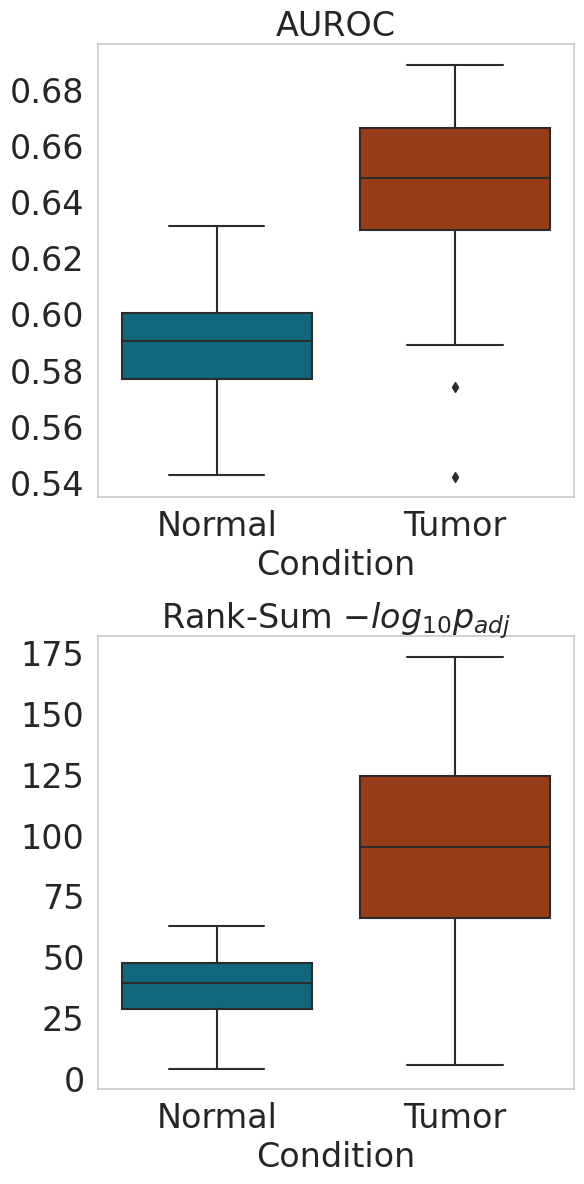

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid", {'axes.grid': False})

# Define font size
fs = 24

# Plot boxplots for each column
plt.figure(figsize=(6, 12))  # Adjust the figure size to accommodate smaller vertical subplots

title_dict = {
    'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Rank-Sum $U$',
    '-log10_mannwhitneyu_p_adj': 'Rank-Sum $-log_{10}{p_{adj}}$',
}

for i, column in enumerate(title_dict.keys()):
    plt.subplot(len(title_dict), 1, i + 1)  # Change the subplot to vertical arrangement
    sns.boxplot(x='condition', y=column, data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}), palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_mannwhitneyu_auroc.pdf')

# Show the plot
plt.show()


In [14]:
# COEVOLUTION

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu
from itertools import combinations, product

# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
    name=None,
):
    # ROC curve using all gene pairs
    fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, auroc

def update_diff_complex(
    all_pairs,
    genes_series_a,
    genes_series_b
):
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in all_pairs.index:
                all_pairs.loc[pair, "interaction"] = 1
            elif (gene_b, gene_a) in all_pairs.index:
                all_pairs.loc[(gene_b, gene_a), "interaction"] = 1
    return

print("Reading interactions.csv")
# read interactions.csv 
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

# ----- ROC all gene pairs -----

print("Generating ROC curves")

print("coev has shape: ", coev.shape)

# flatten TOM matrix, remove diagonal and duplicated values
print("Flattening coev matrix")
all_pairs = pd.DataFrame(
    coev.where(
        np.tri(
            coev.shape[0],
            dtype=bool,
            k=-1
        ),
        np.nan
    ).stack(dropna=True), columns=["coev"]
)
print("all_pairs has now shape: ", all_pairs.shape)

all_pairs['interaction'] = 0

update_diff_complex(all_pairs, complex_a_genes, complex_b_genes)

print("Total number of interacting pairs: ", all_pairs["interaction"].sum())

# Diff complex interactions
coev_fpr, coev_tpr, coev_auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="coev",
    name='Coevoulution'
)

print('auroc:', auroc)

Reading interactions.csv
Number of interacting genes:  1576
Generating ROC curves
coev has shape:  (17756, 17756)
Flattening coev matrix
all_pairs has now shape:  (157628890, 1)
Total number of interacting pairs:  3467
auroc: 0.6639019087494823


In [17]:
coev_fpr, coev_tpr, coev_auroc = (fpr, tpr, auroc)

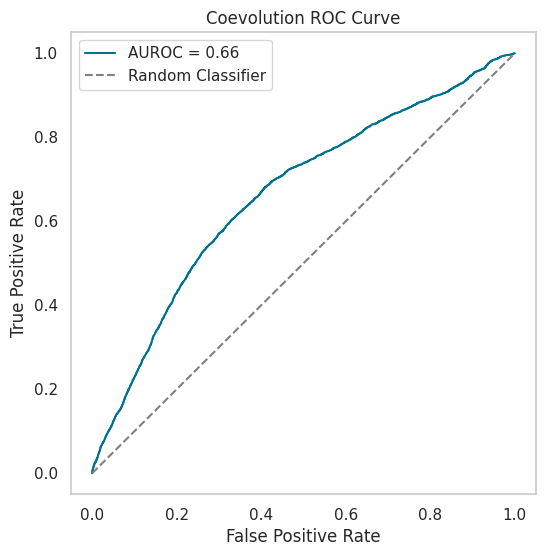

In [18]:
plt.figure(figsize=(6, 6))
plt.plot(coev_fpr, coev_tpr, label=f'AUROC = {coev_auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [16]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_data(x_data, y_data, new_x):
    """
    Interpolate y_data to match new_x using linear interpolation.

    Parameters:
    x_data : array-like
        The original x data points.
    y_data : array-like
        The original y data points corresponding to x_data.
    new_x : array-like
        The new x data points for which we want to compute interpolated y values.

    Returns:
    new_x : array-like
        The input new_x values (unchanged).
    new_y : array-like
        The interpolated y values corresponding to new_x.
    """
    # Create an interpolation function
    interpolation_func = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    
    # Compute new_y by applying the interpolation function to new_x
    new_y = interpolation_func(new_x)
    
    return new_x, new_y


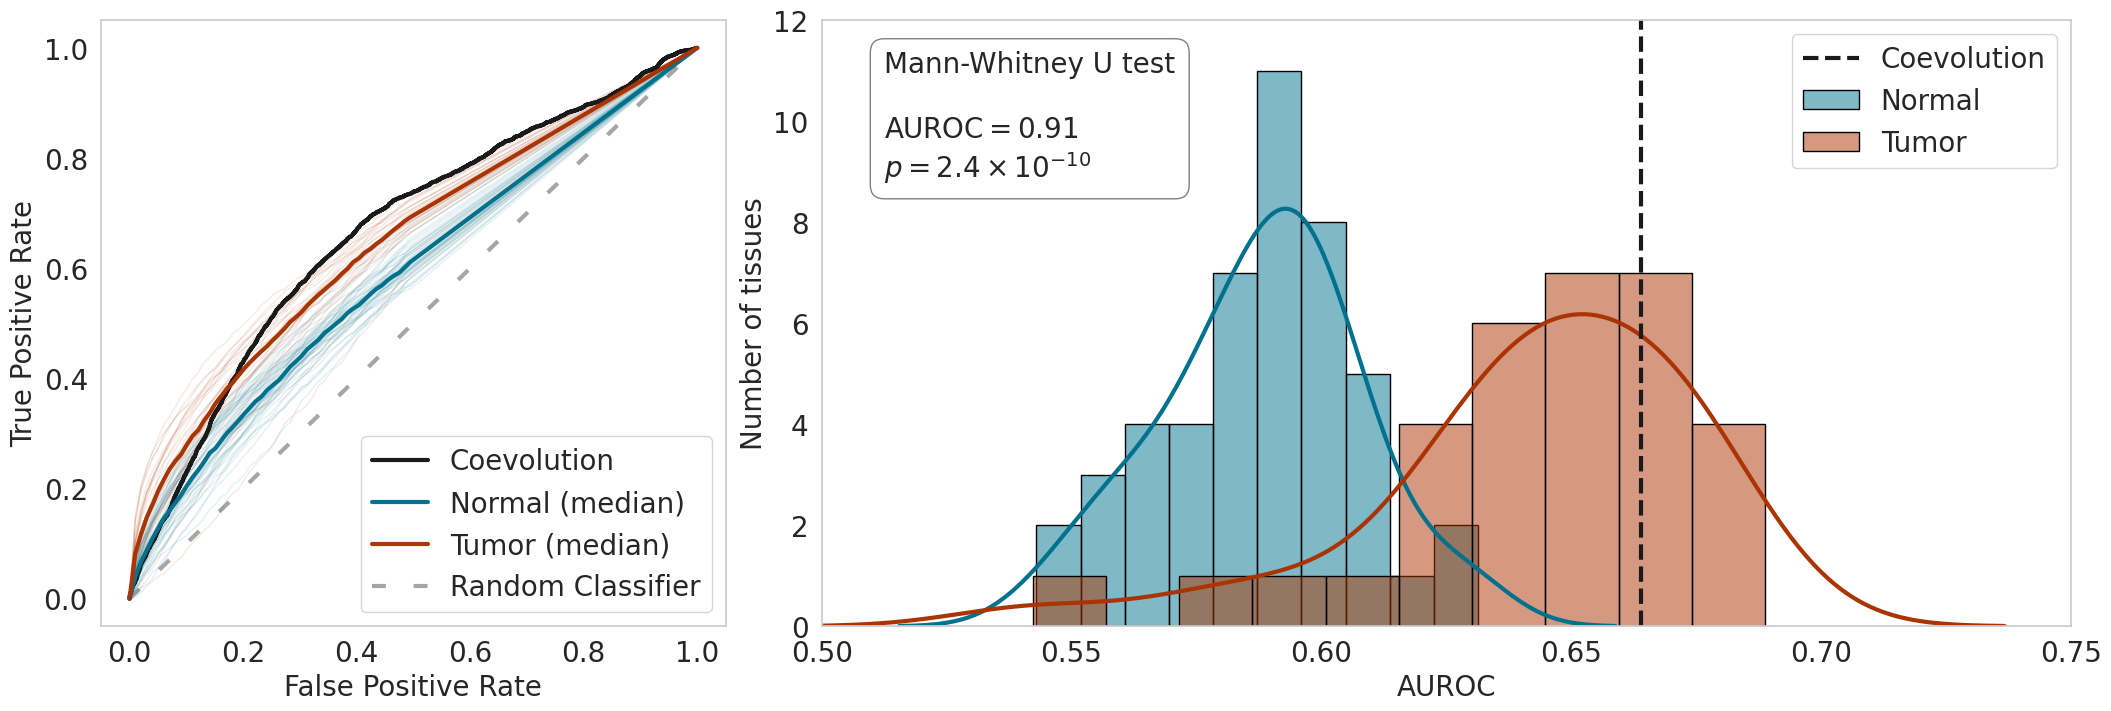

In [62]:
# Define font size
fs = 20

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = stats.mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(21, 7))

axs = fig.subplot_mosaic(
    """
    ABB
    """
)

lw = 3
cut = 3
alpha=0.5
bins=10


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', linestyle=(0, (3.33, 6.66)), lw=lw)

# ----- PLOT B (COMPARISON) ------

# Plot histograms for AUROC with outlines
sns.histplot(normal_data,
        bins=bins,
        kde=True,
        color=ncolor,
        edgecolor='black',
        label='Normal',
        alpha=alpha,
        kde_kws={'cut': cut},
        line_kws={'linewidth': lw, 'color': ncolor},
        ax=axs['B'])
sns.histplot(tumor_data,
        bins=bins,
        kde=True,
        color=tcolor,
        edgecolor='black',
        label='Tumor',
        alpha=alpha,
        kde_kws={'cut': cut},
        line_kws={'linewidth': lw, 'color': tcolor},
        ax=axs['B'])

axs['B'].vlines(x=auroc,ymin=0, ymax=100, colors='k', linestyles='--', label='Coevolution', lw=3)

axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)
axs['A'].tick_params(axis='both', labelsize=fs)

axs['B'].set_xlabel('AUROC', fontsize=fs)
axs['B'].set_ylabel('Number of tissues', fontsize=fs)
axs['B'].legend(fontsize=fs)
axs['B'].tick_params(axis='both', labelsize=fs)

# Add text box for Mann-Whitney U test results with transparency
u_str = str(int(u_statistic))
p_str = str(str(f"{mannwhitney_p_value:.1e}"))[:3] + '\\times 10^{' + str(mannwhitney_p_value).split('e')[-1] + '}'

auroc_t_vs_n = round(u_statistic / (tumor_data.shape[0] * normal_data.shape[0]), 2)

textstr = f"Mann-Whitney U test\n\nAUROC$={auroc_t_vs_n}$\n$p={p_str}$"
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
axs['B'].text(0.05, 0.95, textstr, transform=axs['B'].transAxes, fontsize=fs, verticalalignment='top', bbox=props)

axs['B'].set_xlim(0.5, 0.75)
axs['B'].set_ylim(0, 12)

#plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.png', bbox_inches='tight')

# Show the plot
plt.show()


In [105]:
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')

In [106]:
# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

In [107]:
adj = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/testis/normal/testis/adjacency.csv.gz', index_col=0)

In [108]:
all_ccc_genes = list(set().union(*interactions_all_genes))
all_ccc_genes = adj.index.intersection(all_ccc_genes)
adj = adj.loc[all_ccc_genes, all_ccc_genes]

In [109]:
adj = (adj + adj.T) / 2

In [110]:
from scipy.spatial.distance import squareform

In [111]:
pairs = stack_triangle(adj, col='adj')

In [112]:
from itertools import product

def update_diff_complex(
    all_pairs,
    genes_series_a,
    genes_series_b,
    col='interaction'
):
    all_pairs[col] = 0
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in all_pairs.index:
                all_pairs.loc[pair, col] = 1
            elif (gene_b, gene_a) in all_pairs.index:
                all_pairs.loc[(gene_b, gene_a), col] = 1
    return

In [113]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
    name=None,
):
    # ROC curve using all gene pairs
    fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, auroc

Real: 0.5439191257950763
Permutation: 0.50644241207532


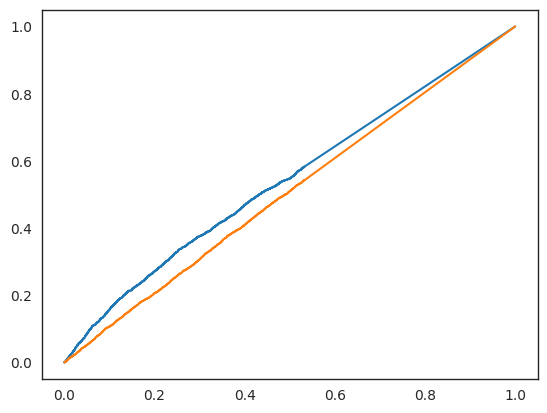

In [122]:
fake = complex_b_genes.sample(frac=1, replace=False).reset_index(drop=True)
update_diff_complex(pairs, complex_a_genes, complex_b_genes, 'interaction')
update_diff_complex(pairs, complex_a_genes, fake, 'permutation')

fpr, tpr, auroc = generate_roc_curve(
    data=pairs,
    target_col="interaction",
    feature_col="adj",
    name='Interactions'
)
print(f'Real: {auroc}')

plt.plot(fpr, tpr)

fpr, tpr, auroc = generate_roc_curve(
    data=pairs,
    target_col="permutation",
    feature_col="adj",
    name='Permutations'
)
print(f'Permutation: {auroc}')

plt.plot(fpr, tpr)

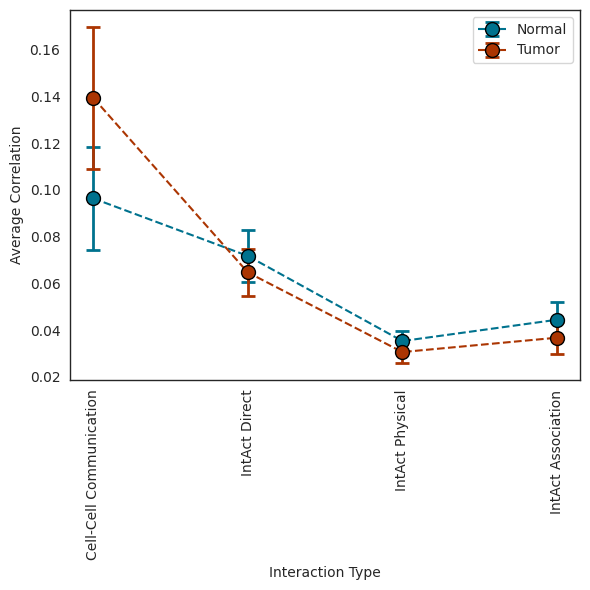

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Read and filter the data
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
#df[df['subtissue'] != 'testis']

df['interaction_type'] = df['interaction_type'].replace({
    'ccc_lr_pairs.csv': 'Cell-Cell Communication', 
    'intact_direct.csv': 'IntAct Direct',
    'intact_association.csv': 'IntAct Association',
    'intact_physical.csv': 'IntAct Physical'
})


df = df.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().to_frame().reset_index()
df = df.query('value_type == "average_corr"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df.groupby(['interaction_type', 'condition'])['value'].mean().to_frame().reset_index()
meandf['interaction_type'] = meandf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

stddf = df.groupby(['interaction_type', 'condition'])['value'].std().to_frame().reset_index()
stddf['interaction_type'] = stddf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

# Define the order and align the data
order = ['Cell-Cell Communication', 'IntAct Direct', 'IntAct Physical', 'IntAct Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Define the style and colors
style_normal = dict(marker='o', linestyle='--', markersize=10,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=10,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)

# Error bar customization
errorbar_kwargs = {
    'capsize': 5,
    'elinewidth': 2,
    'capthick': 2,
}

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

plt.figure(figsize=(6,6))

# Plot with error bars
plt.errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds,
             label="Normal", **style_normal, **errorbar_kwargs)
plt.errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds,
             label="Tumor", **style_tumor, **errorbar_kwargs)

# Add plot details
plt.xticks(range(len(order)), order, rotation=90)
plt.xlabel("Interaction Type")
plt.ylabel("Average Correlation")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [35]:
for itype, tmp in meandf.reset_index().groupby('interaction_type'):
    print(itype)
    tmp = tmp.set_index('condition')
    diff = tmp.loc["tumor", 'value'] - tmp.loc["normal", 'value']
    mean = (tmp.loc["tumor", 'value'] + tmp.loc["normal", 'value']) / 2
    print(diff / mean)

Cell-Cell Communication
0.3650324412793518
IntAct Association
-0.18952012358209733
IntAct Direct
-0.10352844599091043
IntAct Physical
-0.14290665391973353


In [26]:
df.major_tissue.unique()

array(['adipose_tissue', 'adrenal_gland', 'blood', 'blood_vessel',
       'brain', 'breast', 'colon', 'esophagus', 'heart', 'kidney',
       'liver', 'lung', 'muscle', 'nerve', 'ovary', 'pancreas',
       'pituitary', 'prostate', 'salivary_gland', 'skin',
       'small_intestine', 'spleen', 'stomach', 'testis', 'thyroid',
       'uterus', 'vagina', 'bile_duct', 'bladder', 'cervix',
       'endometrium', 'eye', 'head_and_neck_region',
       'lining_of_body_cavities', 'lymphatic_tissue', 'paraganglia',
       'rectum', 'soft_tissue_bone', 'thymus', 'thyroid_gland'],
      dtype=object)

In [226]:
tmp.loc[tmp.condition == "tumor", 'value']

5    0.030909
Name: value, dtype: float64

In [224]:
tmp.query('condition == "tumor"')['value']

5    0.030909
Name: value, dtype: float64

In [189]:
median_abs_deviation(df.value)

9.950304256861795e-06

In [244]:
meandf

condition         value
interaction_type                          
ccc_lr_pairs          normal  0.000000e+00
ccc_lr_pairs           tumor  0.000000e+00
intact_direct         normal  6.133393e-26
intact_direct          tumor  1.134917e-10
intact_physical       normal  0.000000e+00
intact_physical        tumor  0.000000e+00
intact_association    normal  0.000000e+00
intact_association     tumor  0.000000e+00

In [208]:
meandf

condition         value
interaction_type                          
ccc_lr_pairs          normal  2.049460e-09
ccc_lr_pairs           tumor  3.747089e-07
intact_direct         normal  1.631865e-10
intact_direct          tumor  2.052668e-08
intact_physical       normal  2.154670e-12
intact_physical        tumor  1.345703e-09
intact_association    normal  6.641979e-12
intact_association     tumor  2.510387e-09

In [34]:
intact_direct = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/normal/pancreas/interactions/intact_direct.csv')
ccc_lr_pairs = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/normal/pancreas/interactions/ccc_lr_pairs.csv')
intact_physical = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/normal/pancreas/interactions/intact_physical.csv')
intact_association = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/normal/pancreas/interactions/intact_association.csv')

# Define the metric
metric = 'adj'

# Process each dataset and print mean and std
datasets = {
    "intact_direct": intact_direct,
    "ccc_lr_pairs": ccc_lr_pairs,
    "intact_physical": intact_physical,
    "intact_association": intact_association
}

for name, data in datasets.items():
    
    mean = np.log10(data.loc[data[metric] > 0, metric]).mean()
    std = np.log10(data.loc[data[metric] > 0, metric]).std()

    print(f"{name} {metric} mean:", mean)
    print(f"{name} {metric} std:",std)
    print()


intact_direct adj mean: -8.696584643519534
intact_direct adj std: 4.349360103190686

ccc_lr_pairs adj mean: -8.484434670778079
ccc_lr_pairs adj std: 4.207775042480741

intact_physical adj mean: -9.202308505147577
intact_physical adj std: 4.335692814832763

intact_association adj mean: -9.030787593202186
intact_association adj std: 4.3496457272168625



<ErrorbarContainer object of 3 artists>

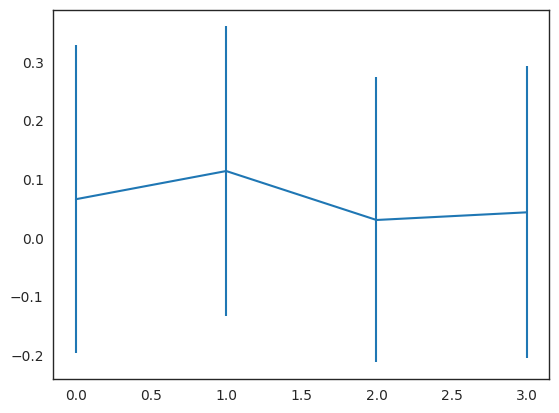

In [28]:
plt.errorbar(
    x = range(len(datasets)),
    y = [data[metric].mean() for data in datasets.values()],
    yerr = [data[metric].std() for data in datasets.values()]
)

# Violinplots

In [19]:
# Coevolution
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)
# Tumor consensus
tcorr = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/median/correlation.csv', index_col=0)
# Normal consensus
ncorr = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/normal/median/correlation.csv', index_col=0)

In [20]:
coev = stack_triangle(coev, 'jaccard')
tcorr = stack_triangle(tcorr, 'corr')
ncorr = stack_triangle(ncorr, 'corr')

In [21]:
from itertools import product

# read interactions.csv 
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
#coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))

def update_diff_complex(
    coev,
    genes_series_a,
    genes_series_b
):
    coev["interaction"] = 'Other Gene Pairs'
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in coev.index:
                coev.loc[pair, "interaction"] = 'CCC Gene Pairs'
            elif (gene_b, gene_a) in coev.index:
                coev.loc[(gene_b, gene_a), "interaction"] = 'CCC Gene Pairs'
    return

update_diff_complex(coev, complex_a_genes, complex_b_genes)
update_diff_complex(tcorr, complex_a_genes, complex_b_genes)
update_diff_complex(ncorr, complex_a_genes, complex_b_genes)

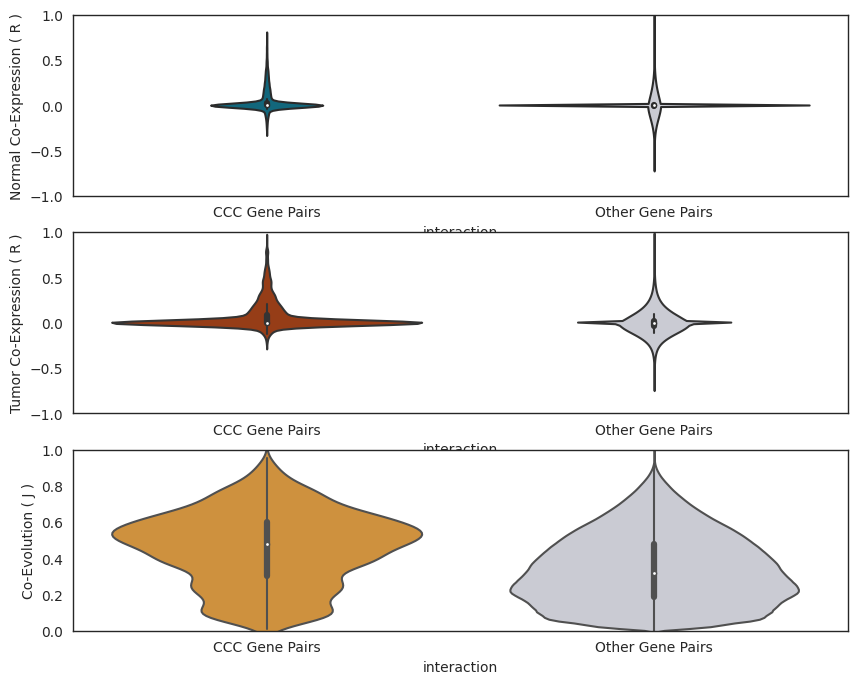

In [22]:
SUBSET = 1

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 8))

ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')

sns.violinplot(
    data=ncorr[::SUBSET],
    x="interaction",
    y="corr",
    ax=ax1,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[ncolor, '#C8CAD4']
)
ax1.set_ylabel('Normal Co-Expression ( R )')
ax1.set_ylim(-1,1)
ax1.set_xlabel('')


sns.violinplot(
    data=tcorr[::SUBSET],
    x="interaction",
    y="corr",
    ax=ax2,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[tcolor, '#C8CAD4']
)
ax2.set_ylabel('Tumor Co-Expression ( R )')
ax2.set_ylim(-1,1)
ax3.set_xlabel('')

sns.violinplot(
    data=coev[::SUBSET],
    x="interaction",
    y="jaccard",
    ax=ax3,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[orangecolor, '#C8CAD4']
)
ax3.set_ylabel('Co-Evolution ( J )')
ax3.set_ylim(0,1)
ax3.set_xlabel('')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.png')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.pdf')

In [31]:
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.png', bbox_inches='tight')
fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.pdf', bbox_inches='tight')

# Interactions Network

In [76]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/interactions_network_filtered.csv')

In [77]:
network['normal_j'] = network['normal_intersection'] / network['normal_union']
network['tumor_j'] = network['tumor_intersection'] / network['tumor_union']

In [78]:
network['-tumor_intersection'] = -network['tumor_intersection']
network['-normal_intersection'] = -network['normal_intersection']

network['-tumor_j'] = -network['tumor_j']
network['-normal_j'] = -network['normal_j']

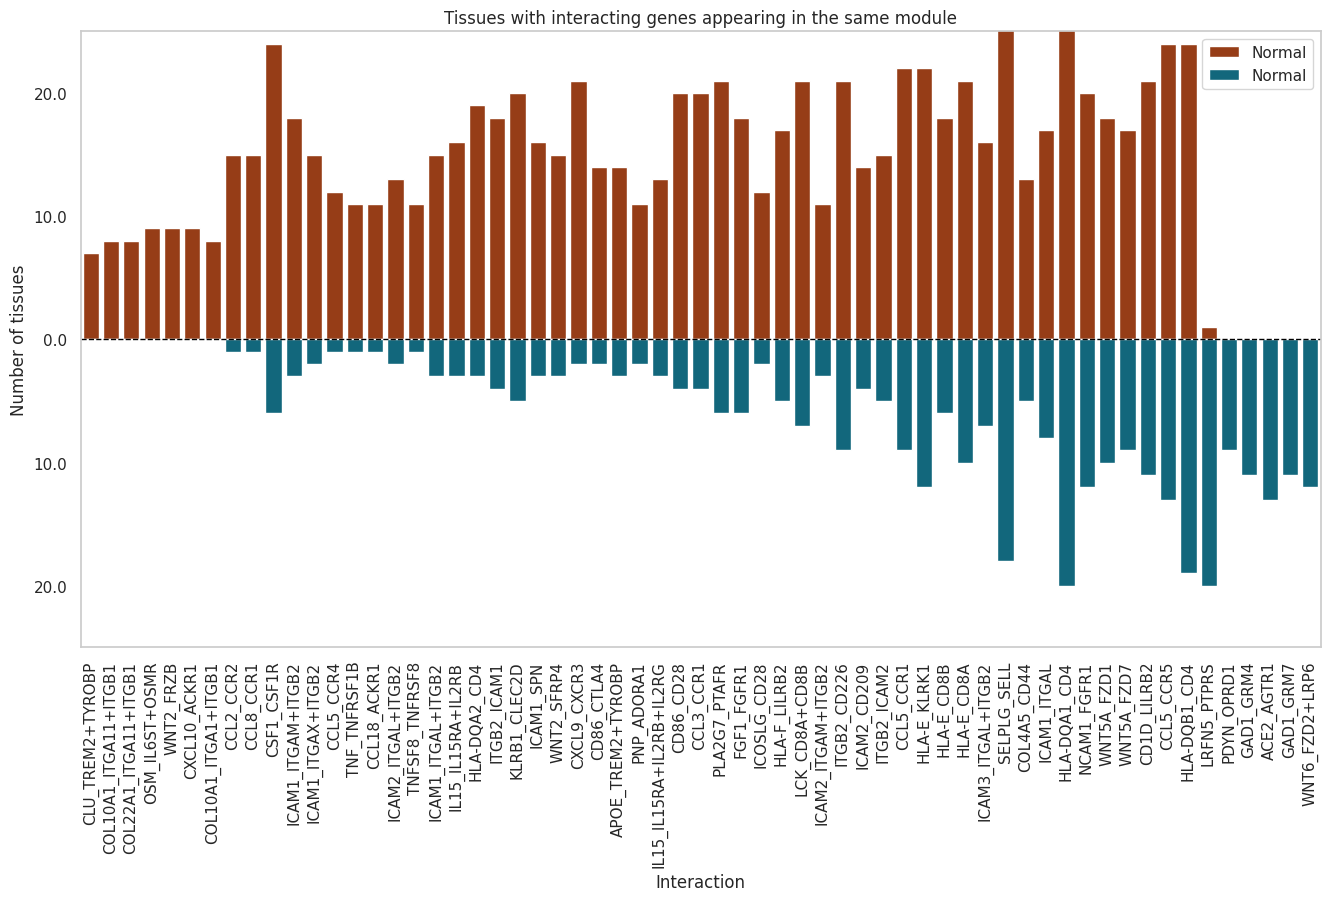

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(ax=ax, x='interaction', y='tumor_intersection', data=network, color=tcolor, alpha=1, label='Normal')
sns.barplot(ax=ax, x='interaction', y='-normal_intersection', data=network, color=ncolor, alpha=1, label='Normal')

ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Adding labels and title for subplot 2
ax.set_xlabel('Interaction')
ax.set_ylabel('')
ax.set_title('Tissues with interacting genes appearing in the same module')
ax.set_ylim(-25, 25)
ax.set_ylabel('Number of tissues')
ax.legend()
ax.tick_params(axis='x', rotation=90)

# Change negative y-axis ticks to positive and display only the first decimal place
ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])

plt.show()

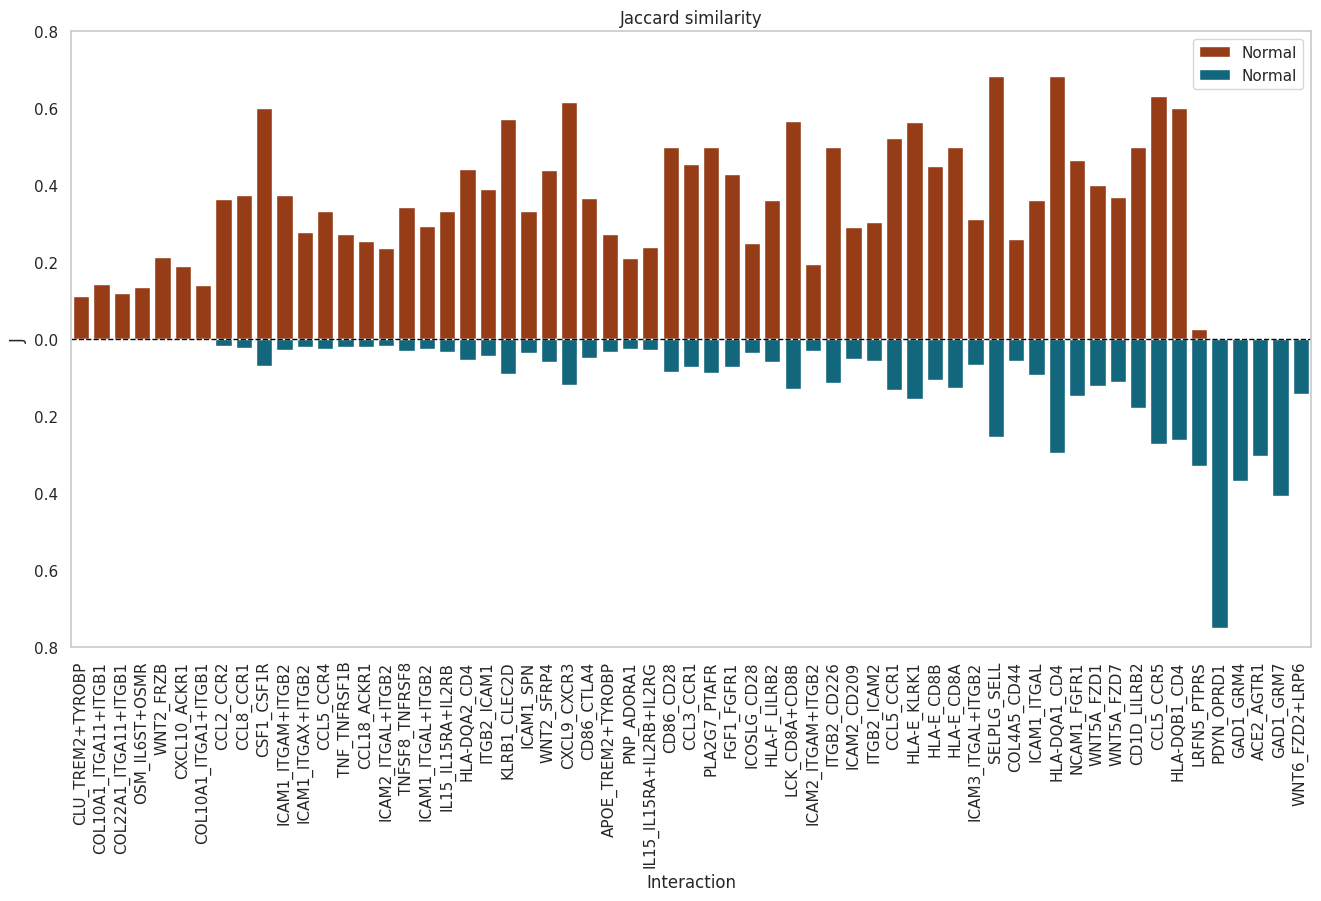

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(ax=ax, x='interaction', y='tumor_j', data=network, color=tcolor, alpha=1, label='Normal')
sns.barplot(ax=ax, x='interaction', y='-normal_j', data=network, color=ncolor, alpha=1, label='Normal')

ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Adding labels and title for subplot 2
ax.set_xlabel('Interaction')
ax.set_ylabel('J')
ax.set_title('Jaccard similarity')
ax.set_ylim(-0.8, 0.8)
ax.legend()
ax.tick_params(axis='x', rotation=90)

# Change negative y-axis ticks to positive and display only the first decimal place
ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])

plt.show()

# Pathway Network

In [17]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')
all_pathways = list(set(network['pathway1']).union(set(network['pathway2'])))

In [18]:
len(all_pathways)

169

In [21]:
# Replace 'inf' values with the maximum value
max_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).max().max()
min_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).min().min()

network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('inf'), max_value)
network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('-inf'), min_value)

In [22]:
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv')

In [23]:
roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
roots.set_index('pathway', inplace=True)

In [24]:
# Get id-name mapping
ids = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', names=['name', 'id'])
ids2names = ids.set_index('id')
names2ids = ids.set_index('name')

In [25]:
# Subset
ids = names2ids.loc[all_pathways, 'id'].values
roots = roots.loc[ids]

In [26]:
names = ids2names.loc[roots['root']].name
roots['root'] = names.values

In [27]:
names = ids2names.loc[roots.index].name
roots.index = names.values

In [28]:
roots.loc[network.pathway1]['root']

TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway                        Immune System
TNFs bind their physiological receptors                                                               Immune System
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
Interleukin-15 signaling                                                                              Immune System
                                                                                                ...                
HSF1 activation                                                                       Cellular responses to stimuli
HSF1 activation                                                                       Cellular responses to stimuli
Purinergic signaling in leishmaniasis infection                         

In [29]:
roots.root.value_counts()

Immune System                           35
Disease                                 30
Signal Transduction                     24
Developmental Biology                   15
Metabolism of proteins                  15
Extracellular matrix organization       10
Metabolism                               8
Neuronal System                          7
Gene expression (Transcription)          7
Hemostasis                               7
Vesicle-mediated transport               7
Cellular responses to stimuli            4
Organelle biogenesis and maintenance     1
Cell-Cell communication                  1
Circadian Clock                          1
Muscle contraction                       1
Name: root, dtype: int64

In [30]:
multiple_roots = roots.index.value_counts()[roots.index.value_counts() > 1].index
roots.loc[multiple_roots, 'root'] = 'Multiple root pathways'

In [31]:
roots.loc[network.pathway1]['root'].values.shape

(788,)

In [32]:
for idx, row in network.iterrows():
    if roots.loc[row.pathway1].shape[0] == 1:
        network.at[idx, 'root1'] = roots.loc[row.pathway1]['root']
    else:
        network.at[idx, 'root1'] = 'Multiple roots'
        
    if roots.loc[row.pathway2].shape[0] == 1:
        network.at[idx, 'root2'] = roots.loc[row.pathway2]['root']
    else:
        network.at[idx, 'root2'] = 'Multiple roots'

network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [33]:
roots.index.name = 'pathway'
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [34]:
roots = roots.reset_index().drop_duplicates().set_index('pathway')
roots.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_roots.csv')

In [35]:
network['root2'].unique()

array(['Developmental Biology', 'Immune System', 'Signal Transduction',
       'Extracellular matrix organization', 'Metabolism of proteins',
       'Hemostasis', 'Disease', 'Metabolism',
       'Gene expression (Transcription)', 'Circadian Clock',
       'Multiple roots', 'Cellular responses to stimuli',
       'Vesicle-mediated transport', 'Neuronal System',
       'Organelle biogenesis and maintenance'], dtype=object)

In [38]:
subset = roots[roots['root'] == 'Neuronal System']
subset

root
pathway                                                            
Assembly and cell surface presentation of NMDA ...  Neuronal System
Negative regulation of NMDA receptor-mediated n...  Neuronal System
Dopamine Neurotransmitter Release Cycle             Neuronal System
Long-term potentiation                              Neuronal System
Neurexins and neuroligins                           Neuronal System
Unblocking of NMDA receptors, glutamate binding...  Neuronal System
Acetylcholine Neurotransmitter Release Cycle        Neuronal System

In [44]:
edgelist = network[['pathway1', 'pathway2', 'log2_odds_ratio']]
edgelist

pathway1  \
0    TNF receptor superfamily (TNFSF) members media...   
1              TNFs bind their physiological receptors   
2    RUNX1 and FOXP3 control the development of reg...   
3    RUNX1 and FOXP3 control the development of reg...   
4                             Interleukin-15 signaling   
..                                                 ...   
780                                    HSF1 activation   
781                                    HSF1 activation   
782    Purinergic signaling in leishmaniasis infection   
783                         Signaling by FGFR2 IIIa TM   
784                              Syndecan interactions   

                                              pathway2  log2_odds_ratio  
0                        Other semaphorin interactions         5.569856  
1    TNF receptor superfamily (TNFSF) members media...         5.569856  
2                   Interleukin receptor SHC signaling         4.321928  
3                             Interleukin-15 signaling         3.797956  
4                   Interleukin receptor SHC signaling         3.767554  
..                                                 ...              ...  
780         Defective B3GALT6 causes EDSP2 and SEMDJL1        -8.240314  
781                    Defective B3GAT3 causes JDSSDHD        -8.240314  
782                                  Attenuation phase        -8.240314  
783  Cross-presentation of particulate exogenous an...        -8.240314  
784                                  Attenuation phase        -8.240314  

[785 rows x 3 columns]

In [45]:
# Gather all unique pathway names
all_pathways = list(set(edgelist['pathway1']).union(set(edgelist['pathway2'])))

# Create an empty DataFrame with pathways as both index and columns
adjacency_matrix = pd.DataFrame(0, index=all_pathways, columns=all_pathways)

# Iterate over each row in the DataFrame and update the adjacency matrix
for index, row in edgelist.iterrows():
    pathway1 = row['pathway1']
    pathway2 = row['pathway2']
    log2_odds_ratio = row['log2_odds_ratio']
    
    adjacency_matrix.loc[pathway1, pathway2] = log2_odds_ratio
    adjacency_matrix.loc[pathway2, pathway1] = log2_odds_ratio  # Assuming the graph is undirected
    
# Replace 'inf' values with 10 times the maximum value
max_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).max().max()
adjacency_matrix = adjacency_matrix.replace(float('inf'), max_value)

# Replace '-inf' values with 10 times the minimum value
min_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).min().min()
adjacency_matrix = adjacency_matrix.replace(float('-inf'), min_value)

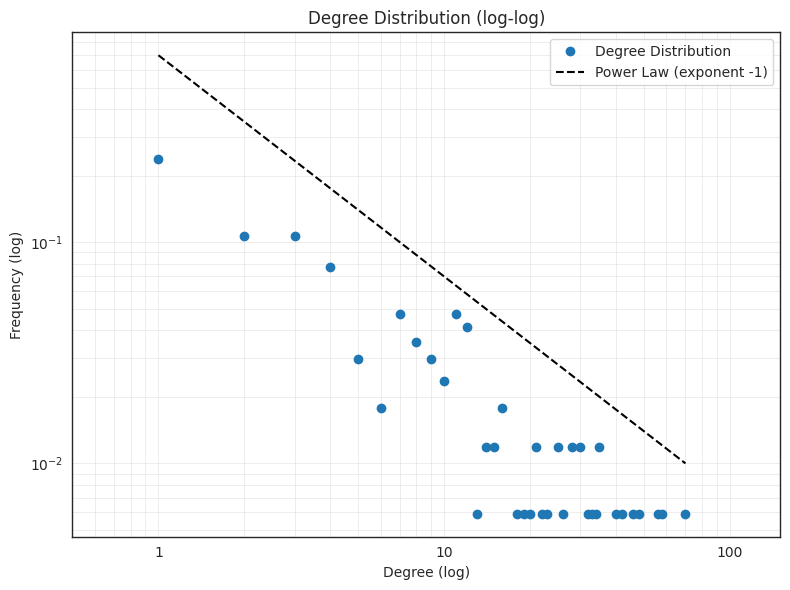

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Assuming you already have the adjacency matrix stored in 'adjacency_matrix'

# Calculate the degrees
degrees = np.abs(adjacency_matrix != 0).sum(axis=1)

degree_counts = (degrees.value_counts() / adjacency_matrix.shape[0]).values
degree_idx = degrees.value_counts().index

# Plot on log-log scale
plt.figure(figsize=(8, 6))
plt.plot(degree_idx, degree_counts, linestyle=' ', marker='o', label='Degree Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.xlim(0.5, 150)
plt.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.title('Degree Distribution (log-log)')

# Add a line for the theoretical power law with exponent -1
x_values = np.linspace(min(degree_idx), max(degree_idx), 100)
y_values = 0.7 * x_values ** (-1)  # Adjust the constant for visualization
plt.plot(x_values, y_values, color='k', linestyle='--', label='Power Law (exponent -1)')

plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/degree_distribution.pdf')

plt.show()


In [50]:
degrees.sort_values(ascending=False)

Neutrophil degranulation                                                    70
Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell    58
Interleukin-4 and Interleukin-13 signaling                                  56
ECM proteoglycans                                                           48
Integrin cell surface interactions                                          46
                                                                            ..
CD28 dependent Vav1 pathway                                                  1
Adrenaline,noradrenaline inhibits insulin secretion                          1
E3 ubiquitin ligases ubiquitinate target proteins                            1
Negative regulation of NMDA receptor-mediated neuronal transmission          1
TNFs bind their physiological receptors                                      1
Length: 169, dtype: int64

# High level pathways

In [5]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')

In [8]:
adj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_high_level_adjacency.csv', index_col=0)

In [9]:
ranked = stack_triangle(adj, 'n')

In [10]:
df = ranked.sort_values(by='n', ascending=False)
df = df[df['n'] > 0]
df.shape

(66, 1)

In [11]:
# Reset index to explode
exploded_df = df.reset_index()

# Rename columns
exploded_df.columns = ['Level 1', 'Level 2', 'n']

for elem in exploded_df['Level 1'] + '-' + exploded_df['Level 2'] + ': ' + exploded_df['n'].astype(int).astype(str):
    print(elem)

Immune System-Disease: 74
Immune System-Extracellular matrix organization: 62
Metabolism of proteins-Immune System: 47
Signal Transduction-Extracellular matrix organization: 44
Disease-Extracellular matrix organization: 35
Disease-Signal Transduction: 33
Signal Transduction-Developmental Biology: 33
Immune System-Signal Transduction: 31
Immune System-Developmental Biology: 30
Metabolism of proteins-Signal Transduction: 23
Metabolism of proteins-Extracellular matrix organization: 22
Extracellular matrix organization-Developmental Biology: 20
Vesicle-mediated transport-Immune System: 16
Gene expression (Transcription)-Immune System: 15
Cellular responses to stimuli-Immune System: 15
Cellular responses to stimuli-Extracellular matrix organization: 15
Metabolism of proteins-Developmental Biology: 14
Disease-Hemostasis: 14
Cellular responses to stimuli-Signal Transduction: 13
Extracellular matrix organization-Hemostasis: 13
Cellular responses to stimuli-Disease: 13
Immune System-Metabolism:

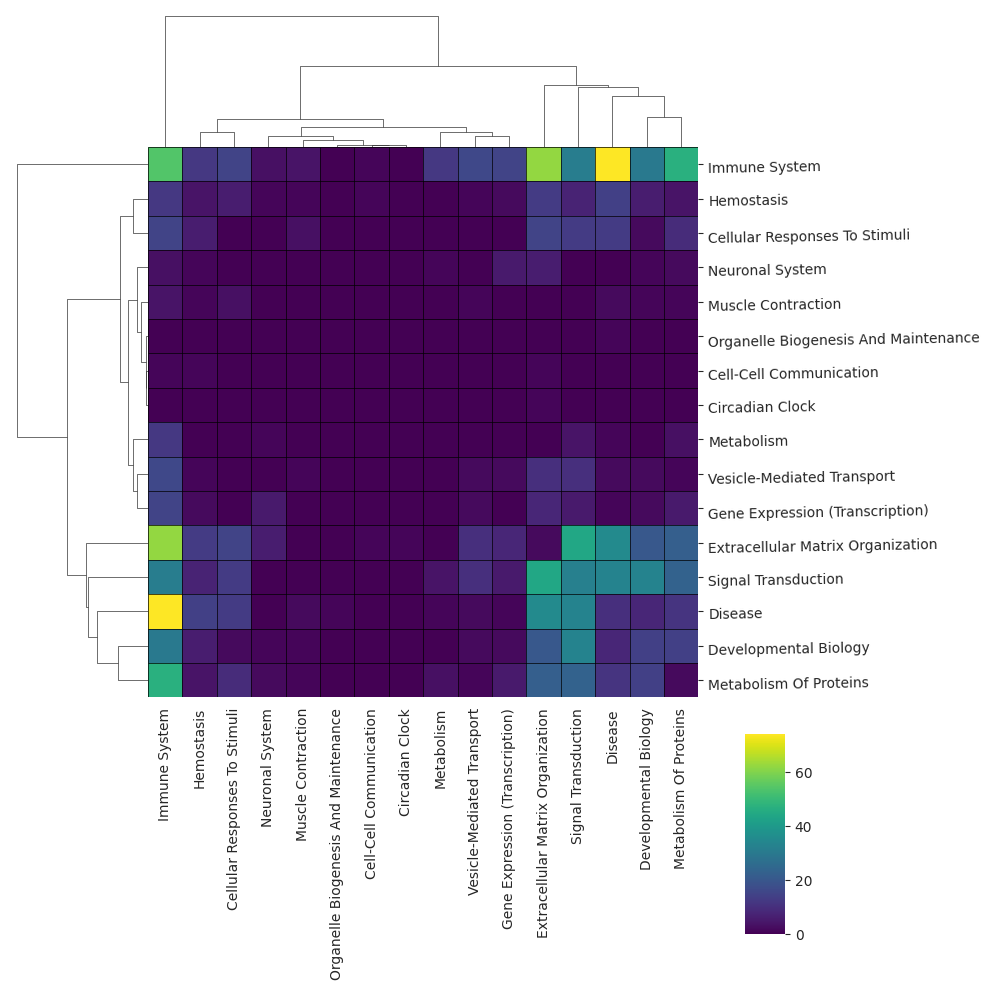

In [12]:
matrix = adj

matrix.columns = [col.title() for col in matrix.columns]
matrix.index   = [idx.title() for idx in matrix.index  ]

g = sns.clustermap(
    adj,
    cmap='viridis',
    cbar_pos=(.75, .06, .04, .2),
    figsize=(10, 10),
    #row_cluster=False,
    #col_cluster=False,
    #row_colors=row_colors,
    #colors_ratio=1/(2*len(all_roots)),
    #vmin=-1.1,
    #vmax=1.1
)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=1)  # Adjust the rotation as needed

# Add black outline
separators1 = list(range(matrix.shape[1]))
separators1 = separators1 + [max(separators1) + 0.99]
separators2 = list(range(matrix.shape[0]))
separators2 = separators2 + [max(separators2) + 0.99]
g.ax_heatmap.vlines(separators1, *g.ax_heatmap.get_ylim(), color='k', linewidth=0.5, zorder=1)
g.ax_heatmap.hlines(separators2, *g.ax_heatmap.get_xlim(), color='k', linewidth=0.5, zorder=1)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/high_lev_heathmap.pdf', bbox_inches="tight")

# Consensus Modules Modularity

In [5]:
# Print summary about consensus modules
for c in ['normal', 'tumor']:
    for q in ['perc25', 'median']:
        modules = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{c}/{q}/consensus_modules.csv', index_col=0)
        print(f'{c}, {q}:')
        print('\tTotal number of modules:', modules['module'].nunique())
        print('\tGenes in biggest module:', modules['module'].value_counts().iloc[0])
        print('\tGenes in smallest module:', modules['module'].value_counts().iloc[-1])
        print('\tAverage genes in modules: {:.1f}'.format(modules['module'].value_counts().mean()))
        print('\tStd genes in modules: {:.1f}'.format(modules['module'].value_counts().std()))

normal, perc25:
	Total number of modules: 32
	Genes in biggest module: 14991
	Genes in smallest module: 20
	Average genes in modules: 556.6
	Std genes in modules: 2634.4
normal, median:
	Total number of modules: 55
	Genes in biggest module: 11368
	Genes in smallest module: 21
	Average genes in modules: 323.8
	Std genes in modules: 1518.6
tumor, perc25:
	Total number of modules: 41
	Genes in biggest module: 12917
	Genes in smallest module: 21
	Average genes in modules: 406.2
	Std genes in modules: 2004.7
tumor, median:
	Total number of modules: 53
	Genes in biggest module: 9680
	Genes in smallest module: 25
	Average genes in modules: 314.3
	Std genes in modules: 1322.7


In [6]:
condition='tumor'
quantile='median'

combinations = [['tumor', 'median'],
                ['tumor', 'perc25'],
                ['normal', 'median'],
                ['normal', 'perc25']]

modularities = pd.DataFrame(combinations, columns=['condition', 'quantile'])

for i in modularities.index:
    condition = modularities.at[i, 'condition']
    quantile= modularities.at[i, 'quantile']
    for path, subdirs, files in os.walk(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{condition}/{quantile}/tissues'):
        for name in files:
            if name == 'modularity.txt':
                tissue = path.split('/')[-1]
                with open(os.path.join(path, name)) as f:
                    m = float(f.readlines()[0])
                modularities.at[i, tissue] = m
    result = modularities.iloc[i, 2:].dropna().mean()
    print(condition, quantile, "{:.2f}".format(result))

tumor median 0.30
tumor perc25 0.24
normal median 0.15
normal perc25 0.13


In [7]:
tmod = modularities.iloc[0, 2:].dropna()

In [8]:
nmod = modularities.iloc[2, 2:].dropna()

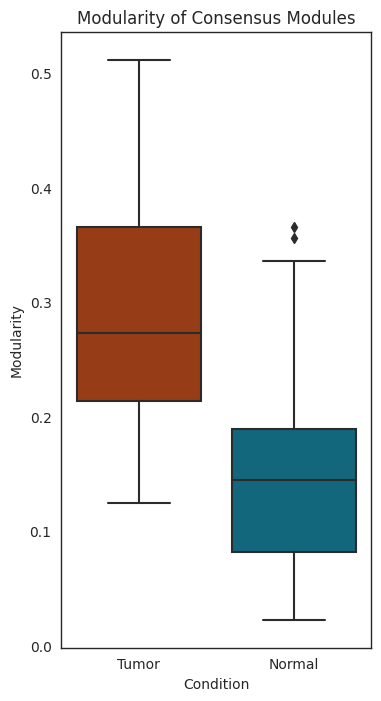

In [17]:
# Create a DataFrame from the Series
data = pd.DataFrame({
    'Tumor': tmod,
    'Normal': nmod
})

palette = {
    'Tumor': tcolor,
    'Normal': ncolor
}

# Melt the DataFrame to long format
data_melted = data.reset_index().melt(id_vars='index', var_name='Condition', value_name='Modularity')

# Plotting
fig, ax = plt.subplots(1,1, figsize=(4, 8))
sns.boxplot(x='Condition', y='Modularity', data=data_melted, palette=palette, ax=ax)
plt.title('Modularity of Consensus Modules')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/modules/modularity.pdf', bbox_inches='tight')

plt.show()

In [14]:
modularities

condition quantile  rectum_adenocarcinoma  uterine_carcinosarcoma  \
0     tumor   median               0.213984                0.409329   
1     tumor   perc25               0.152449                0.382569   
2    normal   median                    NaN                     NaN   
3    normal   perc25                    NaN                     NaN   

   thyroid_carcinoma  kidney_papillary_cell_carcinoma  kidney_chromophobe  \
0           0.270945                         0.405588            0.260738   
1           0.223747                         0.360991            0.203821   
2                NaN                              NaN                 NaN   
3                NaN                              NaN                 NaN   

   kidney_clear_cell_carcinoma  brain_lower_grade_glioma  \
0                     0.428774                  0.239180   
1                     0.361575                  0.180954   
2                          NaN                       NaN   
3                          NaN                       NaN   

   glioblastoma_multiforme  ...  thyroid  pituitary  \
0                 0.345059  ...      NaN        NaN   
1                 0.273918  ...      NaN        NaN   
2                      NaN  ...  0.15154   0.139404   
3                      NaN  ...  0.13170   0.087609   

   small_intestine_terminal_ileum  colon_sigmoid  colon_transverse    spleen  \
0                             NaN            NaN               NaN       NaN   
1                             NaN            NaN               NaN       NaN   
2                        0.044584       0.075677          0.038455  0.144457   
3                        0.018850       0.048545          0.013719  0.142685   

   esophagus_gastroesophageal_junction  esophagus_muscularis  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                             0.192365              0.179599   
3                             0.156156              0.159618   

   esophagus_mucosa   stomach  
0               NaN       NaN  
1               NaN       NaN  
2          0.194562  0.043961  
3          0.156822  0.016237  

[4 rows x 81 columns]

0.19323022161004785


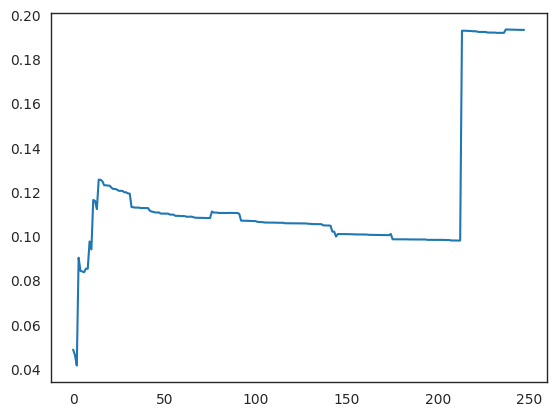

In [15]:
results = []

for column in all_clusterings.columns:
    clustering = all_clusterings.loc[adj.index, column].values          
    modularity = g.modularity(clustering, weights=g.es['weight'])
    results.append(modularity)
    
results = np.array(results)

print(results.max())
plt.plot(results)

In [141]:
import os
import pandas as pd

#quantile = 'perc25'
quantile = 'median'

# Define the root directory where you want to search
root_dir = f'/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/{quantile}/tissues'
all_clusterings = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/{quantile}/all_clusterings.csv', index_col=0)

# Initialize an empty dataframe for merging
merged_df = None

# Walk through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file == 'modularity.csv':
            file_path = os.path.join(subdir, file)
            name = file_path.split('/')[-2]
            # Read the CSV file
            df = pd.read_csv(file_path, index_col=0)  # Assuming the index is in the first column
            df.columns = [f"{col}_{name}" for col in df.columns]
            # Merge the dataframe with the existing one on index (horizontally)
            if merged_df is None:
                merged_df = df  # Initialize merged_df with the first dataframe
            else:
                merged_df = merged_df.join(df, how='inner')  # Join on index (outer join to keep all indices)

# Save the merged dataframe to a new CSV file
# merged_df.to_csv('merged_modularity.csv', index=False)

print("All files have been successfully merged horizontally!")


All files have been successfully merged horizontally!


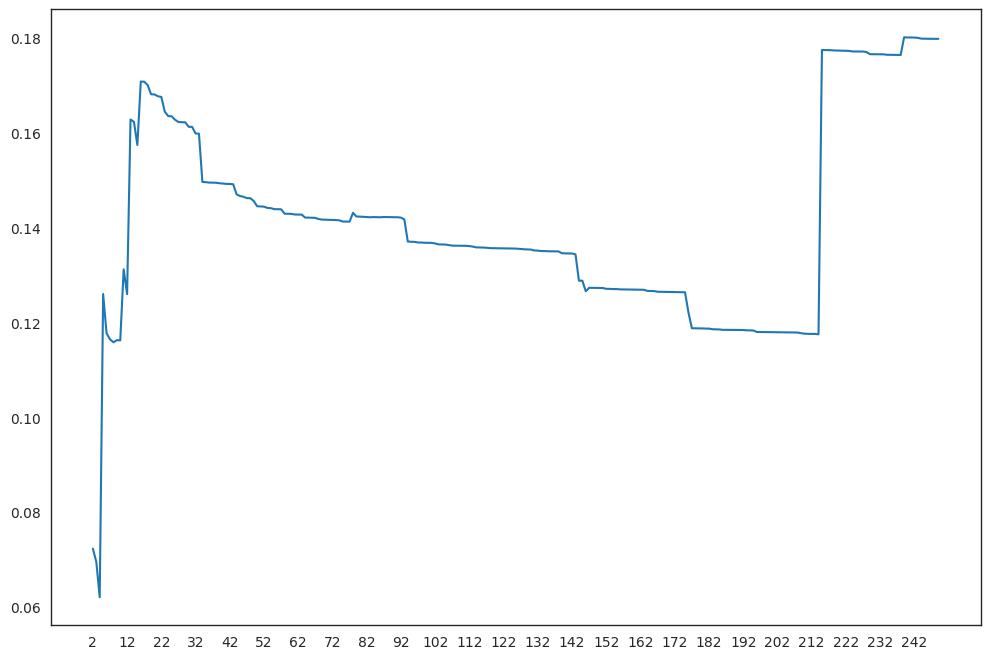

In [142]:
n_clust = list(merged_df.mean(axis=1).index.str.split('_',expand=True).get_level_values(0))
means = merged_df.mean(axis=1).values

plt.figure(figsize=(12,8))
plt.plot(n_clust, means)
plt.xticks(np.arange(0, len(n_clust), 10))
plt.show()

# Explore Raw Data

In [5]:
import scanpy as sc

In [6]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/TCGA_GTEX.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 18305 × 60498
    obs: 'detailed_category', 'primary_disease_or_tissue', 'X_primary_site', 'X_sample_type', 'X_gender', 'X_study'
    layers: 'TPM', 'raw_counts'

In [8]:
adata.obs.X_sample_type.value_counts()

Primary Tumor                                      9181
Normal Tissue                                      7412
Solid Tissue Normal                                 726
Metastatic                                          392
Cell Line                                           363
Primary Blood Derived Cancer - Peripheral Blood     173
Recurrent Tumor                                      45
Additional - New Primary                             11
Additional Metastatic                                 1
Control Analyte                                       1
Name: X_sample_type, dtype: int64

In [7]:
adata = adata[adata.obs.X_sample_type.isin(['Primary Tumor', 'Normal Tissue'])]

In [11]:
adata.obs

detailed_category  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage   
...                                                  ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma   
TCGA-ZT-A8OM-01                                  Thymoma   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer   

                               primary_disease_or_tissue  X_primary_site  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal          Muscle   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage           Heart   
...                                                  ...             ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma           Liver   
TCGA-ZT-A8OM-01                                  Thymoma          Thymus   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma       Bile duct   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma       Bile duct   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer          Cervix   

                                X_sample_type X_gender X_study  
GTEX-1117F-0226-SM-5GZZ7        Normal Tissue   Female    GTEX  
GTEX-1117F-0426-SM-5EGHI        Normal Tissue   Female    GTEX  
GTEX-1117F-0526-SM-5EGHJ        Normal Tissue   Female    GTEX  
GTEX-1117F-0626-SM-5N9CS        Normal Tissue   Female    GTEX  
GTEX-1117F-0726-SM-5GIEN        Normal Tissue   Female    GTEX  
...                                       ...      ...     ...  
TCGA-ZS-A9CG-01                 Primary Tumor     Male    TCGA  
TCGA-ZT-A8OM-01                 Primary Tumor   Female    TCGA  
TCGA-ZU-A8S4-01                 Primary Tumor     Male    TCGA  
TCGA-ZU-A8S4-11           Solid Tissue Normal     Male    TCGA  
TCGA-ZX-AA5X-01                 Primary Tumor   Female    TCGA  

[18305 rows x 6 columns]

In [9]:
sc.pp.pca(adata)

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

In [14]:
adata.obs

detailed_category  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage   
...                                                  ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma   
TCGA-ZT-A8OM-01                                  Thymoma   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer   

                               primary_disease_or_tissue  X_primary_site  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal          Muscle   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage           Heart   
...                                                  ...             ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma           Liver   
TCGA-ZT-A8OM-01                                  Thymoma          Thymus   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma       Bile duct   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma       Bile duct   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer          Cervix   

                                X_sample_type X_gender X_study  
GTEX-1117F-0226-SM-5GZZ7        Normal Tissue   Female    GTEX  
GTEX-1117F-0426-SM-5EGHI        Normal Tissue   Female    GTEX  
GTEX-1117F-0526-SM-5EGHJ        Normal Tissue   Female    GTEX  
GTEX-1117F-0626-SM-5N9CS        Normal Tissue   Female    GTEX  
GTEX-1117F-0726-SM-5GIEN        Normal Tissue   Female    GTEX  
...                                       ...      ...     ...  
TCGA-ZS-A9CG-01                 Primary Tumor     Male    TCGA  
TCGA-ZT-A8OM-01                 Primary Tumor   Female    TCGA  
TCGA-ZU-A8S4-01                 Primary Tumor     Male    TCGA  
TCGA-ZU-A8S4-11           Solid Tissue Normal     Male    TCGA  
TCGA-ZX-AA5X-01                 Primary Tumor   Female    TCGA  

[18305 rows x 6 columns]

In [33]:
tissue_dict = {
    'thyroid': 'thyroid',
    'thyroid gland': 'thyroid',
    'vagina': 'female reproductive',
    'uterus': 'female reproductive',
    'ovary': 'female reproductive',
    'fallopian tube': 'female reproductive',
    'endometrium': 'female reproductive',
    'cervix': 'female reproductive',
    'cervix uteri': 'female reproductive',
    }

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


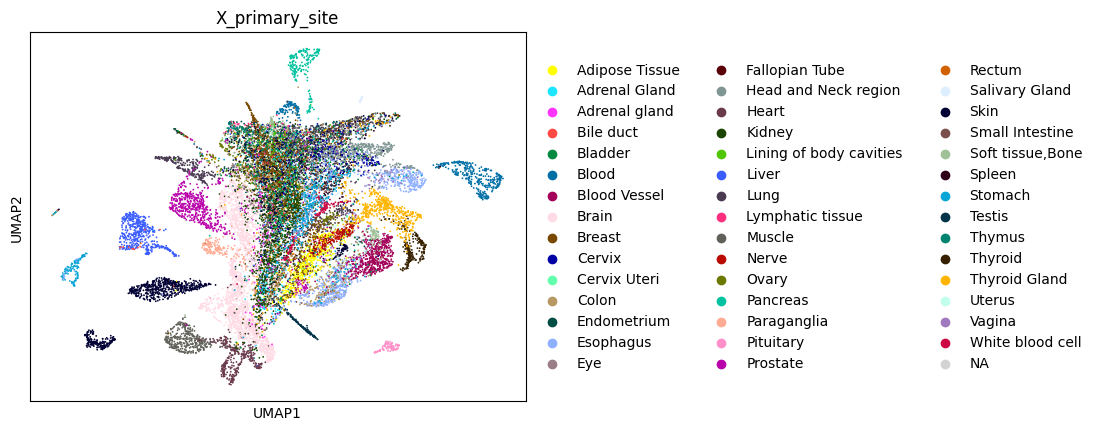

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


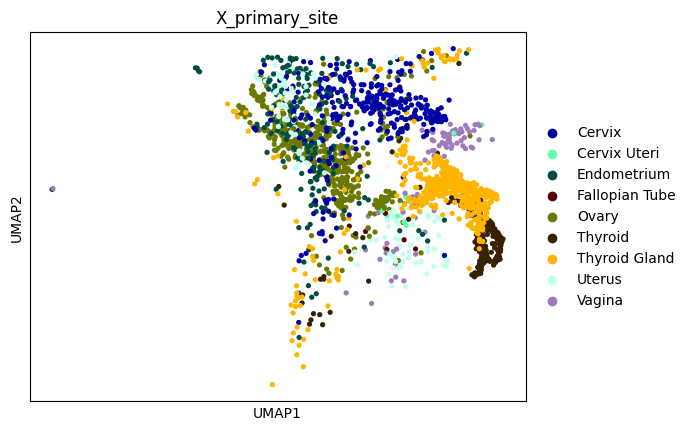

In [35]:
tissues = ['thyroid', 'thyroid gland', 'vagina', 'uterus', 'ovary', 'fallopian tube', 'endometrium', 'cervix', 'cervix uteri']
sc.pl.umap(adata, color=['X_primary_site'], ncols=1)
sc.pl.umap(adata[adata.obs.X_primary_site.str.lower().isin(tissues)], color=['X_primary_site'], ncols=1)

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


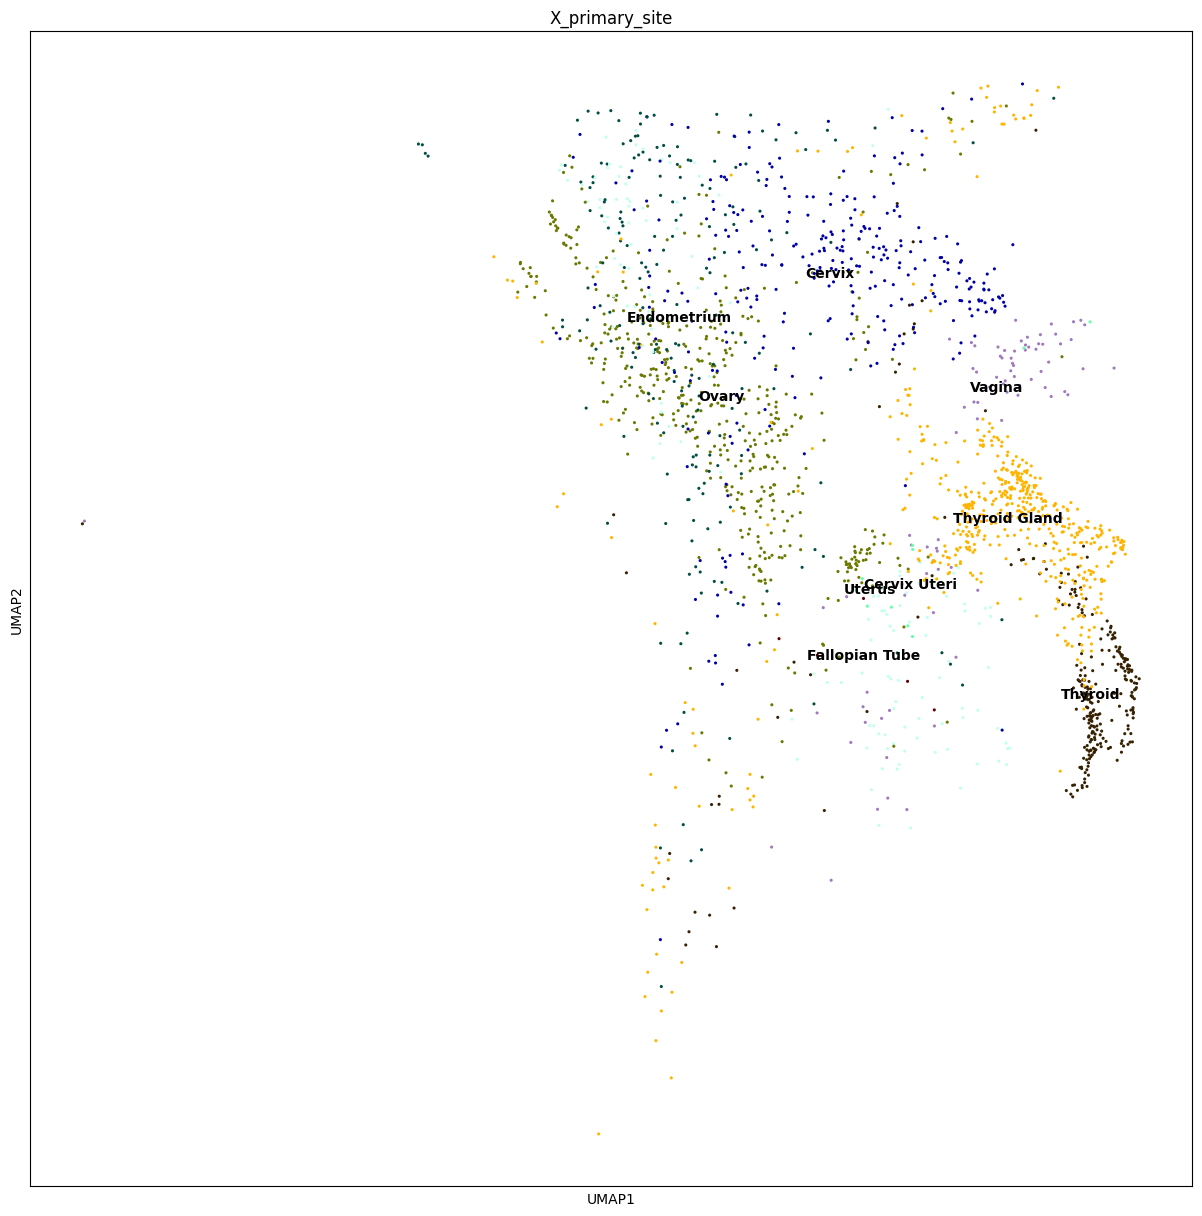

In [37]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
sc.pl.umap(adata[adata.obs.X_primary_site.str.lower().isin(tissues)], color=['X_primary_site'], legend_loc='on data', size=20, ncols=1, ax=ax)

In [ ]:
sc.pl.pca(adata, color=)

# Consensus Modules Enrichment

In [21]:
conditions = ('tumor', 'normal')
quantiles = ('perc25', 'median')

for condition in conditions:
    for quantile in quantiles:
        print(condition, quantile)
        enr = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{condition}/{quantile}/enrichment.csv')
        for module, df in enr.groupby('module'):
            top3 = df.sort_values(by='Adjusted P-value', ascending=True).head(3).Term.values.tolist()
            print(module, top3)
        print()

tumor perc25
0 ['Neuronal System', 'Sensory Perception', 'Metabolism of lipids']
1 ['Chromatin modifying enzymes', 'Chromatin organization', 'Gene expression (Transcription)']
2 ['Immune System', 'Innate Immune System', 'Adaptive Immune System']
3 ['Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.', 'Aerobic respiration and respiratory electron transport', 'Respiratory electron transport']
4 ['Complex I biogenesis', 'Respiratory electron transport', 'Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.']
5 ['Cell Cycle', 'Cell Cycle, Mitotic', 'Cell Cycle Checkpoints']
6 ['Signal Transduction', 'Extracellular matrix organization', 'Integrin cell surface interactions']
7 ['Gluconeogenesis', 'Cytosolic iron-sulfur cluster assembly', 'Glucose metabolism']
8 ['Eukaryotic Translation Elongation', 'Peptide chain elongation', 'Formation of a pool of free 40S subuni

In [5]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/TCGA_GTEX.h5ad')

print("Subsetting samples")

rename = {
    "X_study": "study",
    "X_gender": "gender",
    "X_sample_type": "type",
    "X_primary_site": "tissue",
    "primary_disease_or_tissue": "condition"
}

adata.obs.rename(columns=rename, inplace=True)
adata.obs.drop(columns="detailed_category", inplace=True)

adata = adata[adata.obs.type.isin(["Primary Tumor", "Normal Tissue"])]


Subsetting samples


In [6]:
# retrieve gene symbol of protein coding genes                                                                                
annot = pd.read_csv("~/resources/biomart/ensembl_to_symbol_filtered.csv.gz", index_col="Gene stable ID")                      
                                                                                                                              
# remove ensembl version                                                                                                      
adata.var["ensembl"] = adata.var_names.str.replace(r"\..*","", regex=True)                                                    
adata.var_names = adata.var["ensembl"].values                                                                                 
                                                                                                                              
# subset to genes in biomart                                                                                                  
adata = adata[:, adata.var_names.isin(annot.index)]                                                                           
                                                                                                                              
# add gene symbols                                                                                                            
adata.var["symbol"] = annot["Gene name"]                                                                                      
                                                                                                                              
# remove genes with missing symbol                                                                                            
adata = adata[:, ~adata.var.symbol.isna()]                                                                                    
                                                                                                                              
# set index to gene symbol                                                                                                    
adata.var_names = adata.var.symbol.values 

In [7]:
modules = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/median/consensus_modules.csv', index_col=0)

In [8]:
genes = modules.index

In [9]:
adata = adata[:, genes]

In [ ]:
adata.var['module'] = modules['module']

In [1]:
adata

NameError: name 'adata' is not defined